In [1]:
from gidnet.qubitreuse import GidNET

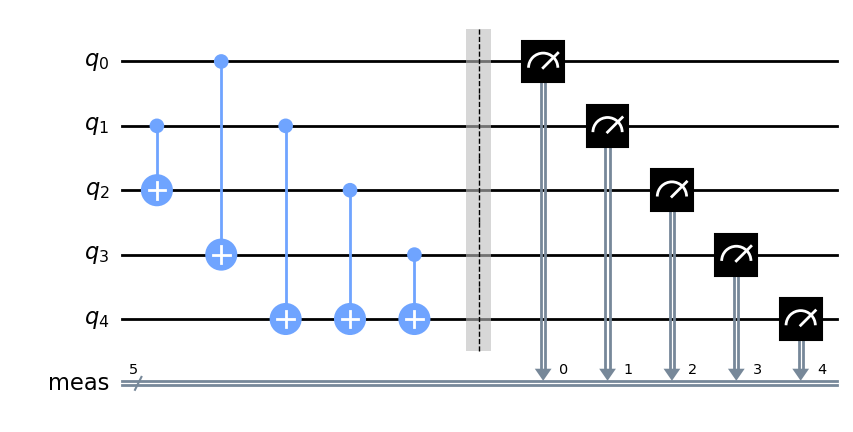

In [2]:
from qiskit import QuantumCircuit
circ = QuantumCircuit(5)

circ.cx(1,2)
circ.cx(0,3)

circ.cx(1,4)
circ.cx(2,4)
circ.cx(3,4)


circ.measure_all()

circ.draw('mpl')

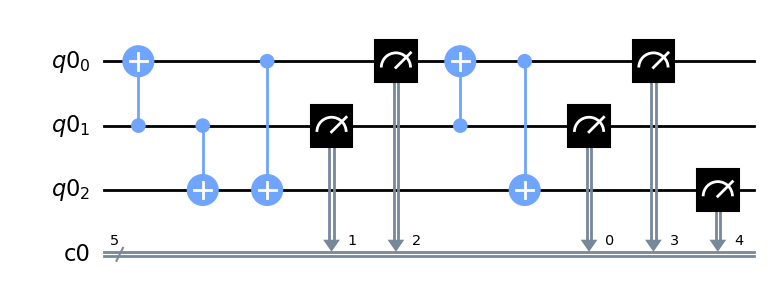

In [3]:
gidnet = GidNET(circ)
gidnet.compile_to_dynamic_circuit(draw=True)

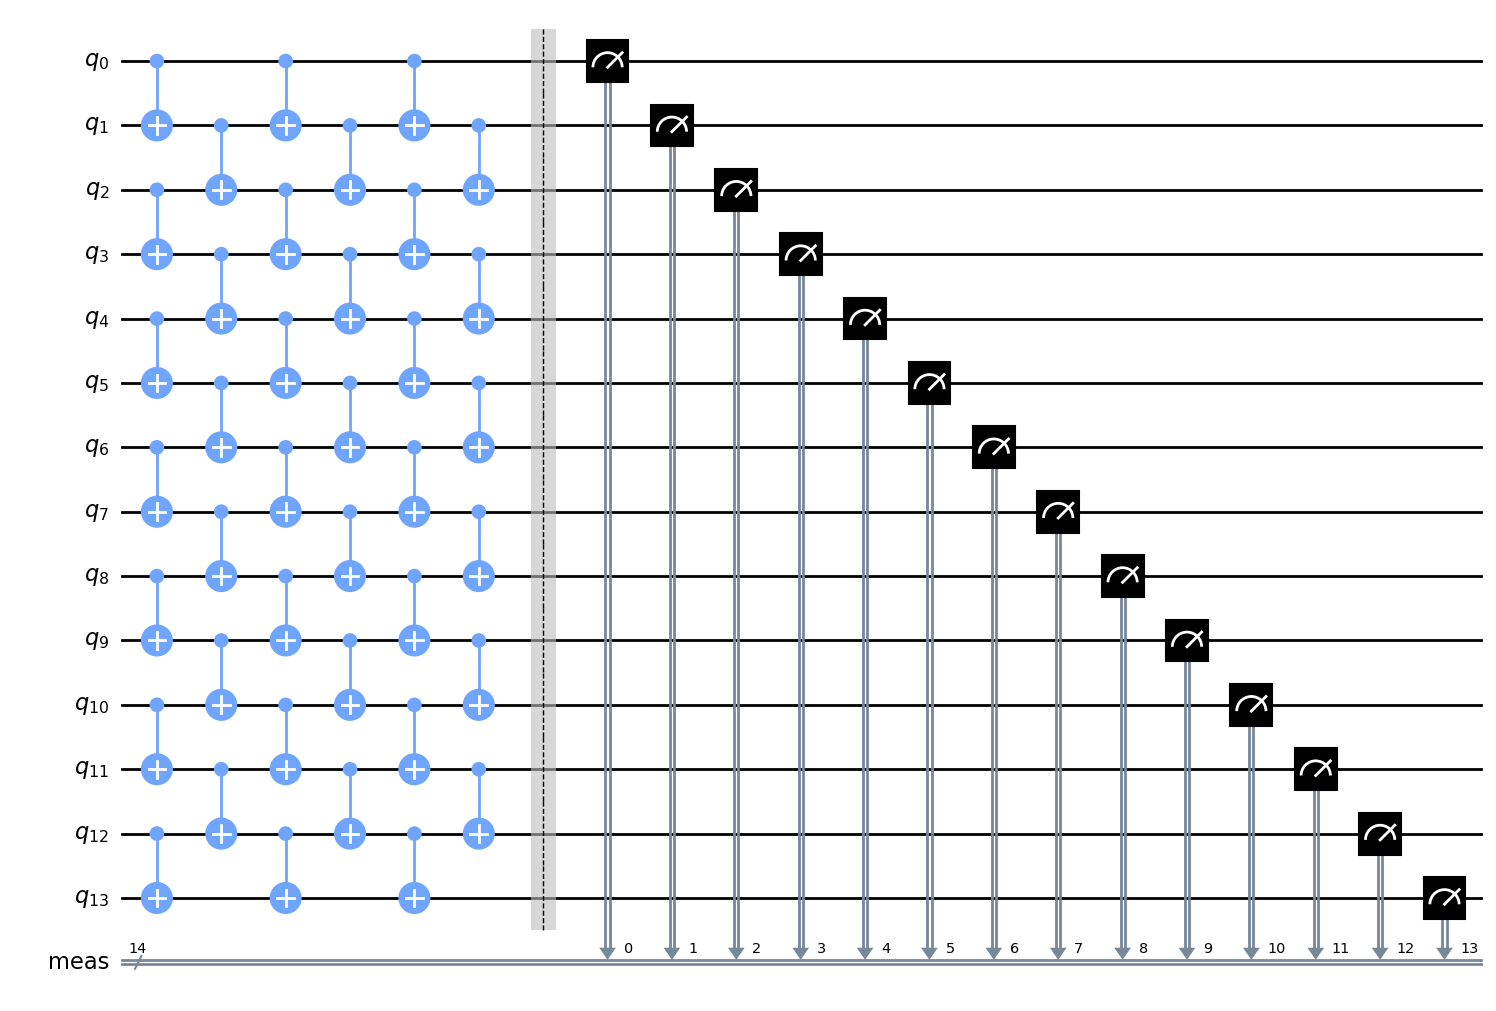

In [4]:
num_qubits = 14
k = 3
brick_circ = QuantumCircuit(num_qubits)

for i in range(k):
    for q in range(int(num_qubits/2)):
        brick_circ.cx(2*q, 2*q+1)
        
    for q in range(int(num_qubits/2)-1):
        brick_circ.cx(2*q+1, 2*q+2)
        
    # circ.barrier()

brick_circ.measure_all()

brick_circ.draw('mpl', fold=1)


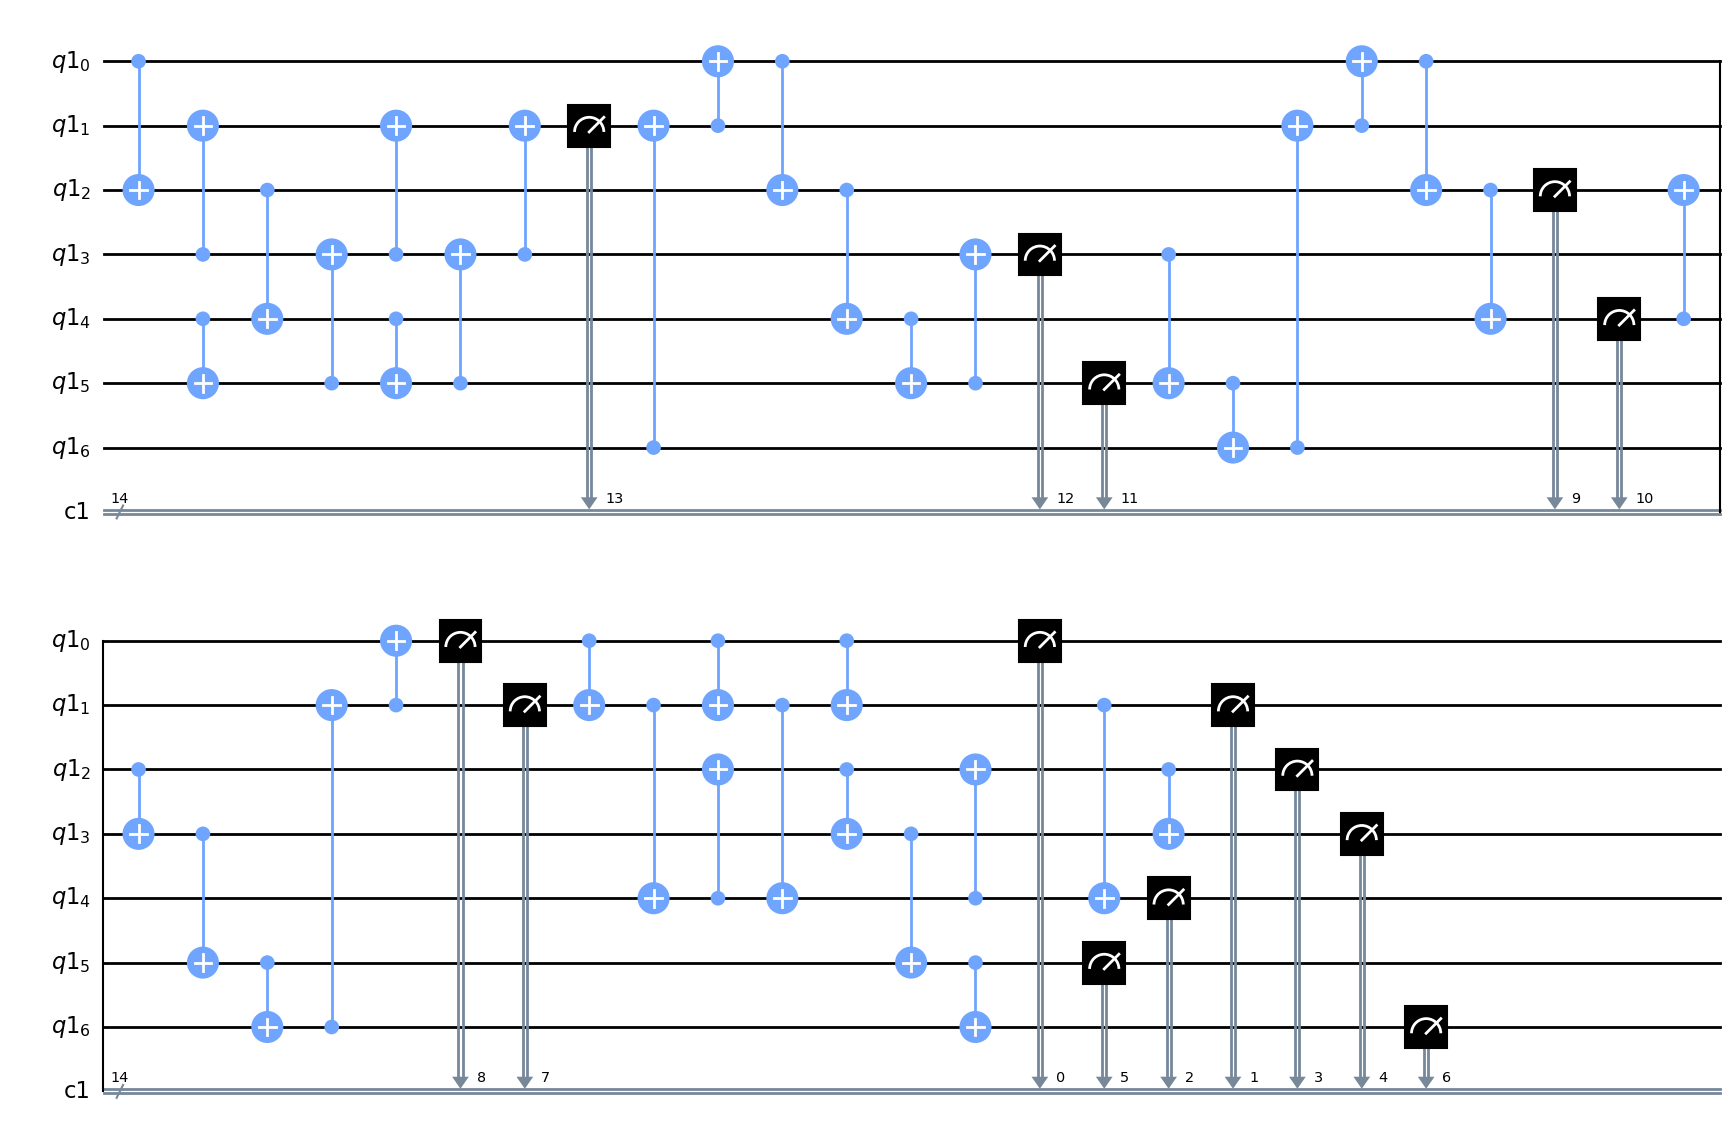

In [5]:
gidnet = GidNET(brick_circ)
gidnet.compile_to_dynamic_circuit(iterations=20, draw=True)

In [6]:
gidnet.dynamic_circuit_width

7

In [9]:
import numpy as np
import pandas as pd
import time
import logging
from pathlib import Path
from gidnet.qubitreuse import GidNET
from gidnet.utils import safe_eval
from benchmarks.qcg.helper_functions.benchmarks import generate_circ
from math import log, floor

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define parameters
depth = 11  # Change depth as needed
circuit_sizes = [16, 20, 25, 30, 36, 42, 49, 56, 64, 72, 81, 90, 100]  # Test cases

def compute_iteration_counts(n):
    """Computes different iteration values based on the circuit size n."""
    return [
        n,
        max(1, floor(n / 2)),  # Ensure at least 1 iteration
        max(1, floor(n / 4)),
        max(1, floor(log(n))),  # Log(n)
        max(1, floor(log(n / 2))),
        max(1, floor(log(n / 4))),
    ]

# Store results
results = []

# Run experiments
for circuit_size in circuit_sizes:
    logging.info(f"Running optimization test for circuit size {circuit_size}")
    
    # Generate test circuit
    circuit = generate_circ(
        num_qubits=circuit_size,
        depth=1,
        circuit_type="supremacy",
        reg_name="q",
        connected_only=True,
        seed=None,
    )
    circuit.measure_all()

    # Compute iteration counts
    iteration_values = compute_iteration_counts(circuit_size)

    for iterations in iteration_values:
        logging.info(f"Running GidNET with {iterations} iterations for circuit size {circuit_size}")
        
        gidnet = GidNET(circuit)
        runtimes = []
        min_width = int(1e10)

        for _ in range(10):  # Run multiple trials per iteration count
            start_time = time.time()
            gidnet.compile_to_dynamic_circuit(iterations)
            elapsed_time = time.time() - start_time

            runtimes.append(elapsed_time)
            min_width = min(min_width, gidnet.dynamic_circuit_width)

        # Store results
        results.append([circuit_size, iterations, np.mean(runtimes), np.std(runtimes), min_width])

# Convert results to DataFrame
df = pd.DataFrame(
    results,
    columns=["Circuit Size", "Iterations", "Mean Runtime", "Std Runtime", "Min Width"]
)

# Save results
output_path = Path("GRCS_result")
output_path.mkdir(parents=True, exist_ok=True)
df.to_csv(output_path / "gidnet_iterations_scaling_analysis.csv", index=False)

logging.info("Experiment completed. Results saved to CSV.")


Running optimization test for circuit size 16
Generating 4x4, 1+8+1 supremacy circuit
Running GidNET with 16 iterations for circuit size 16
Running GidNET with 8 iterations for circuit size 16
Running GidNET with 4 iterations for circuit size 16
Running GidNET with 2 iterations for circuit size 16
Running GidNET with 2 iterations for circuit size 16
Running GidNET with 1 iterations for circuit size 16
Running optimization test for circuit size 20
Generating 5x4, 1+8+1 supremacy circuit
Running GidNET with 20 iterations for circuit size 20
Running GidNET with 10 iterations for circuit size 20
Running GidNET with 5 iterations for circuit size 20
Running GidNET with 2 iterations for circuit size 20
Running GidNET with 2 iterations for circuit size 20
Running GidNET with 1 iterations for circuit size 20
Running optimization test for circuit size 25
Generating 5x5, 1+8+1 supremacy circuit
Running GidNET with 25 iterations for circuit size 25
Running GidNET with 12 iterations for circuit siz

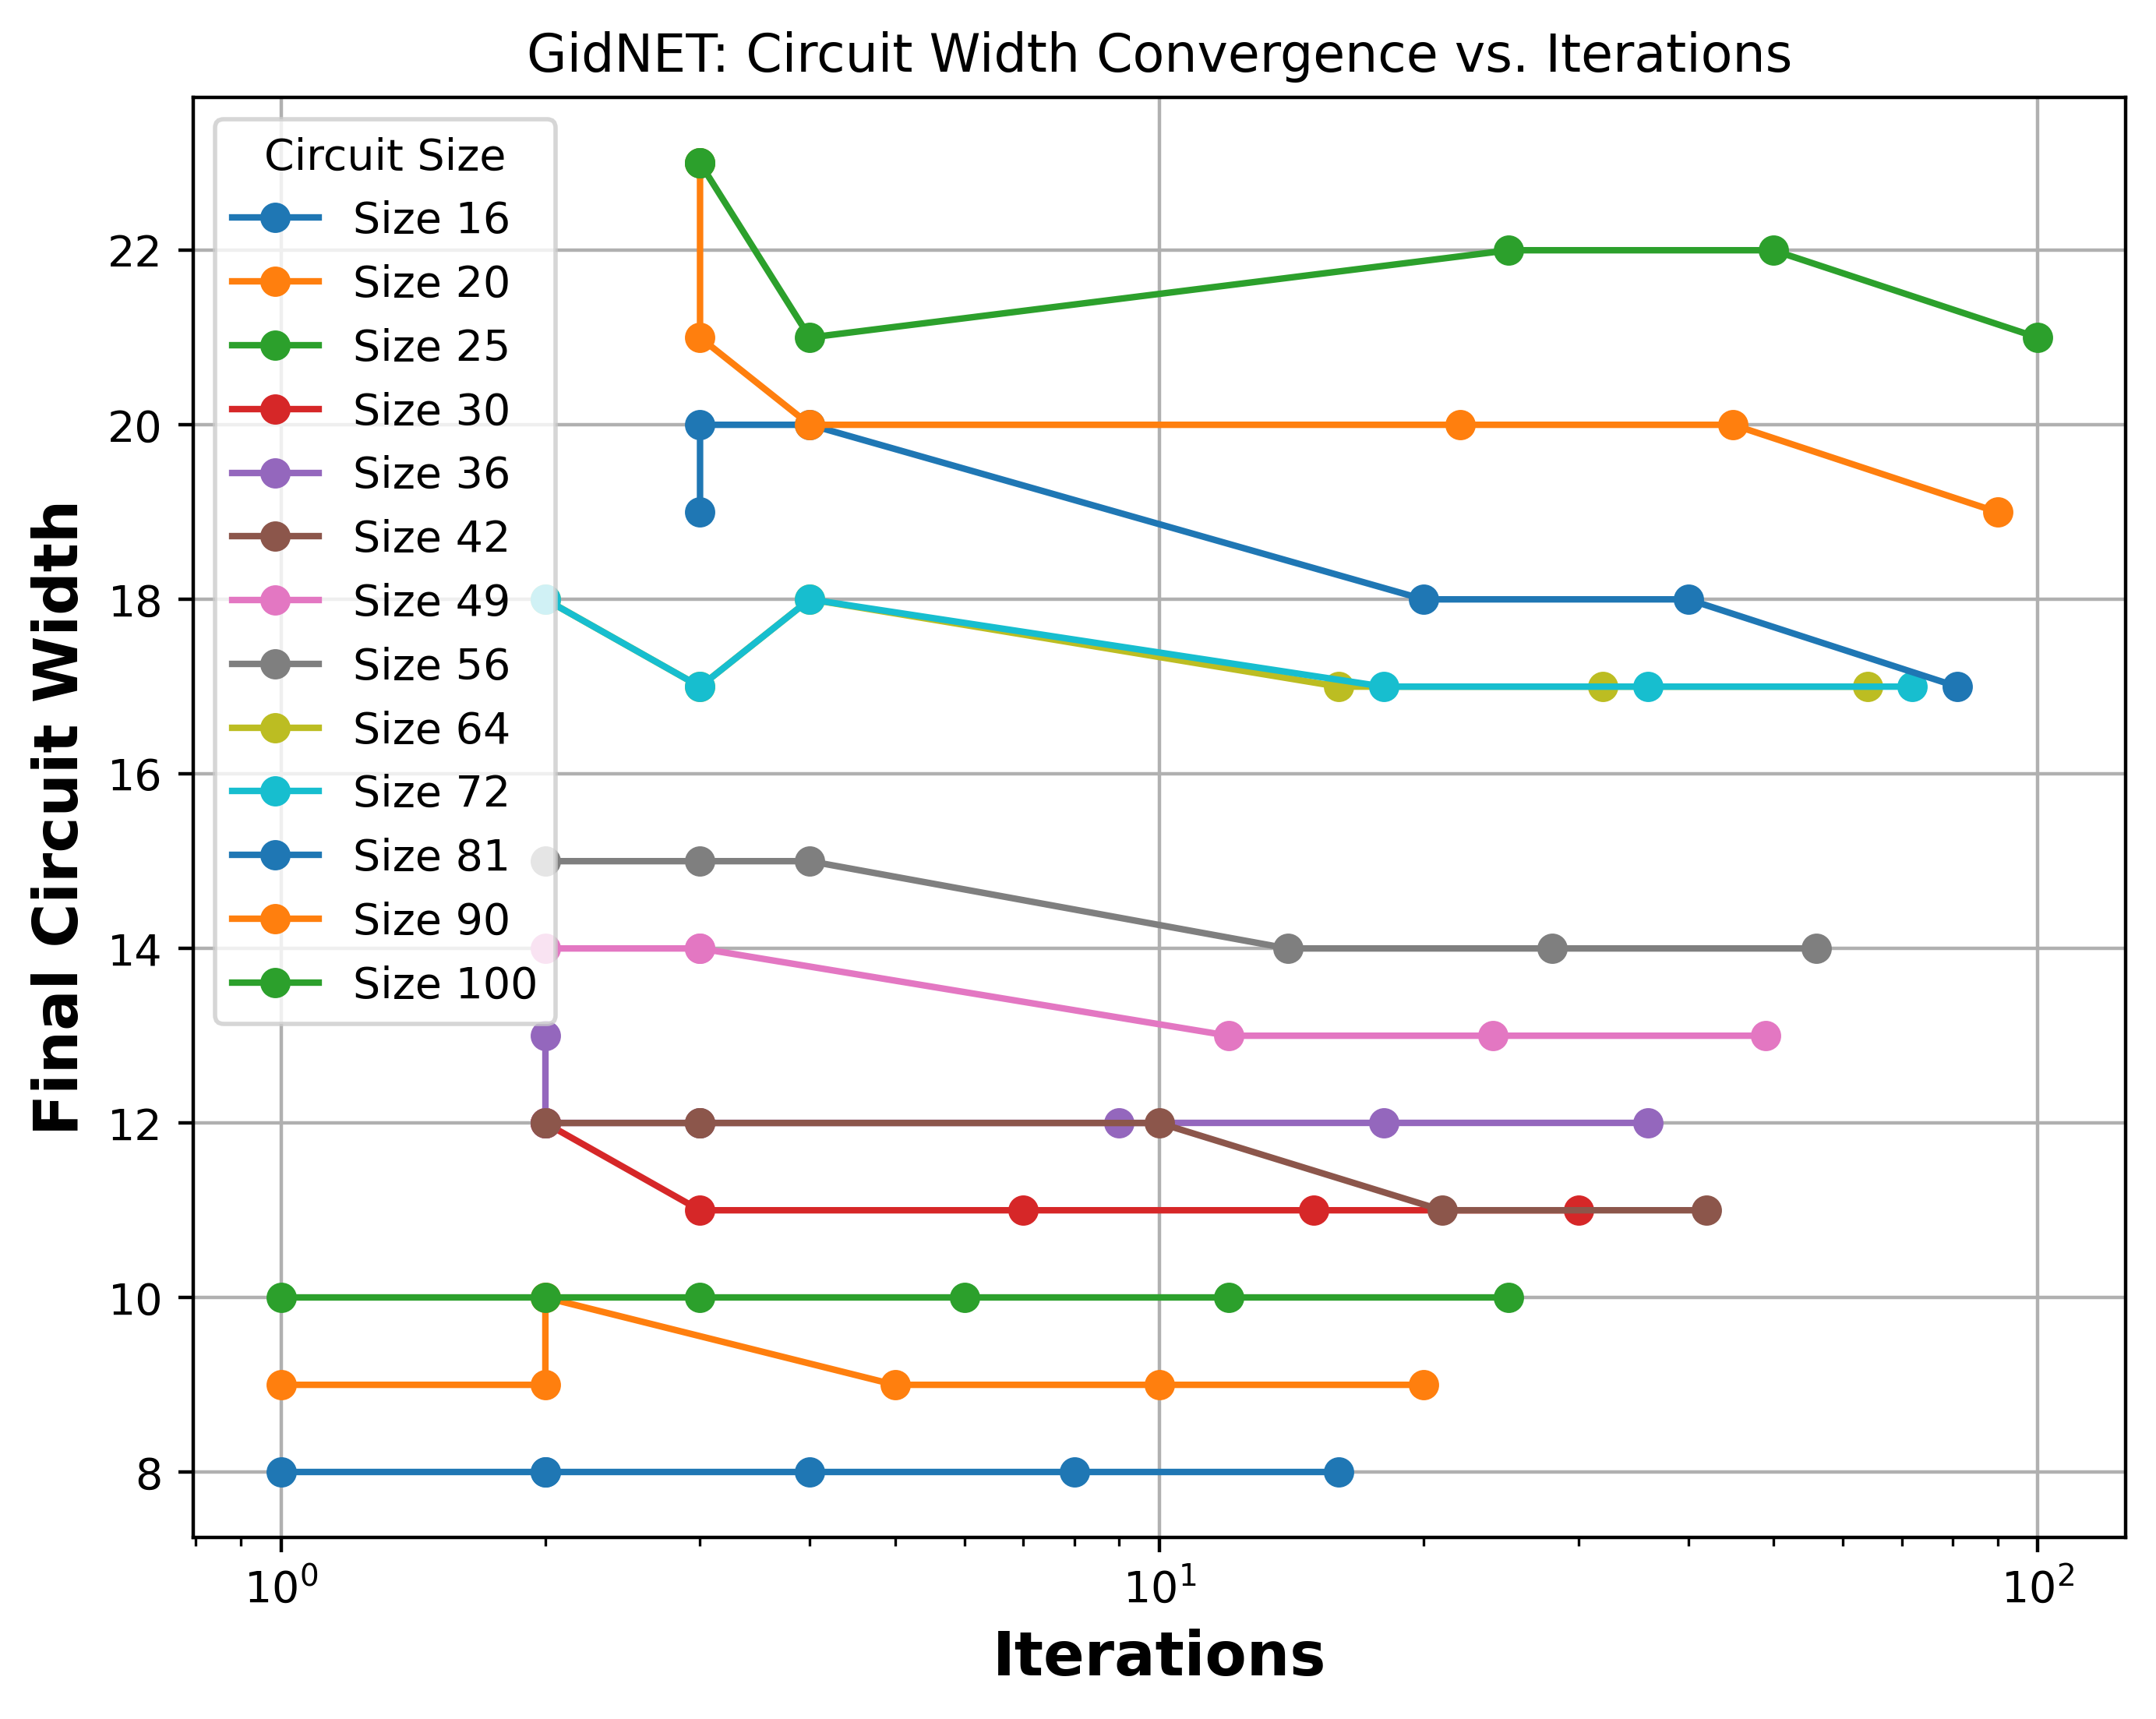

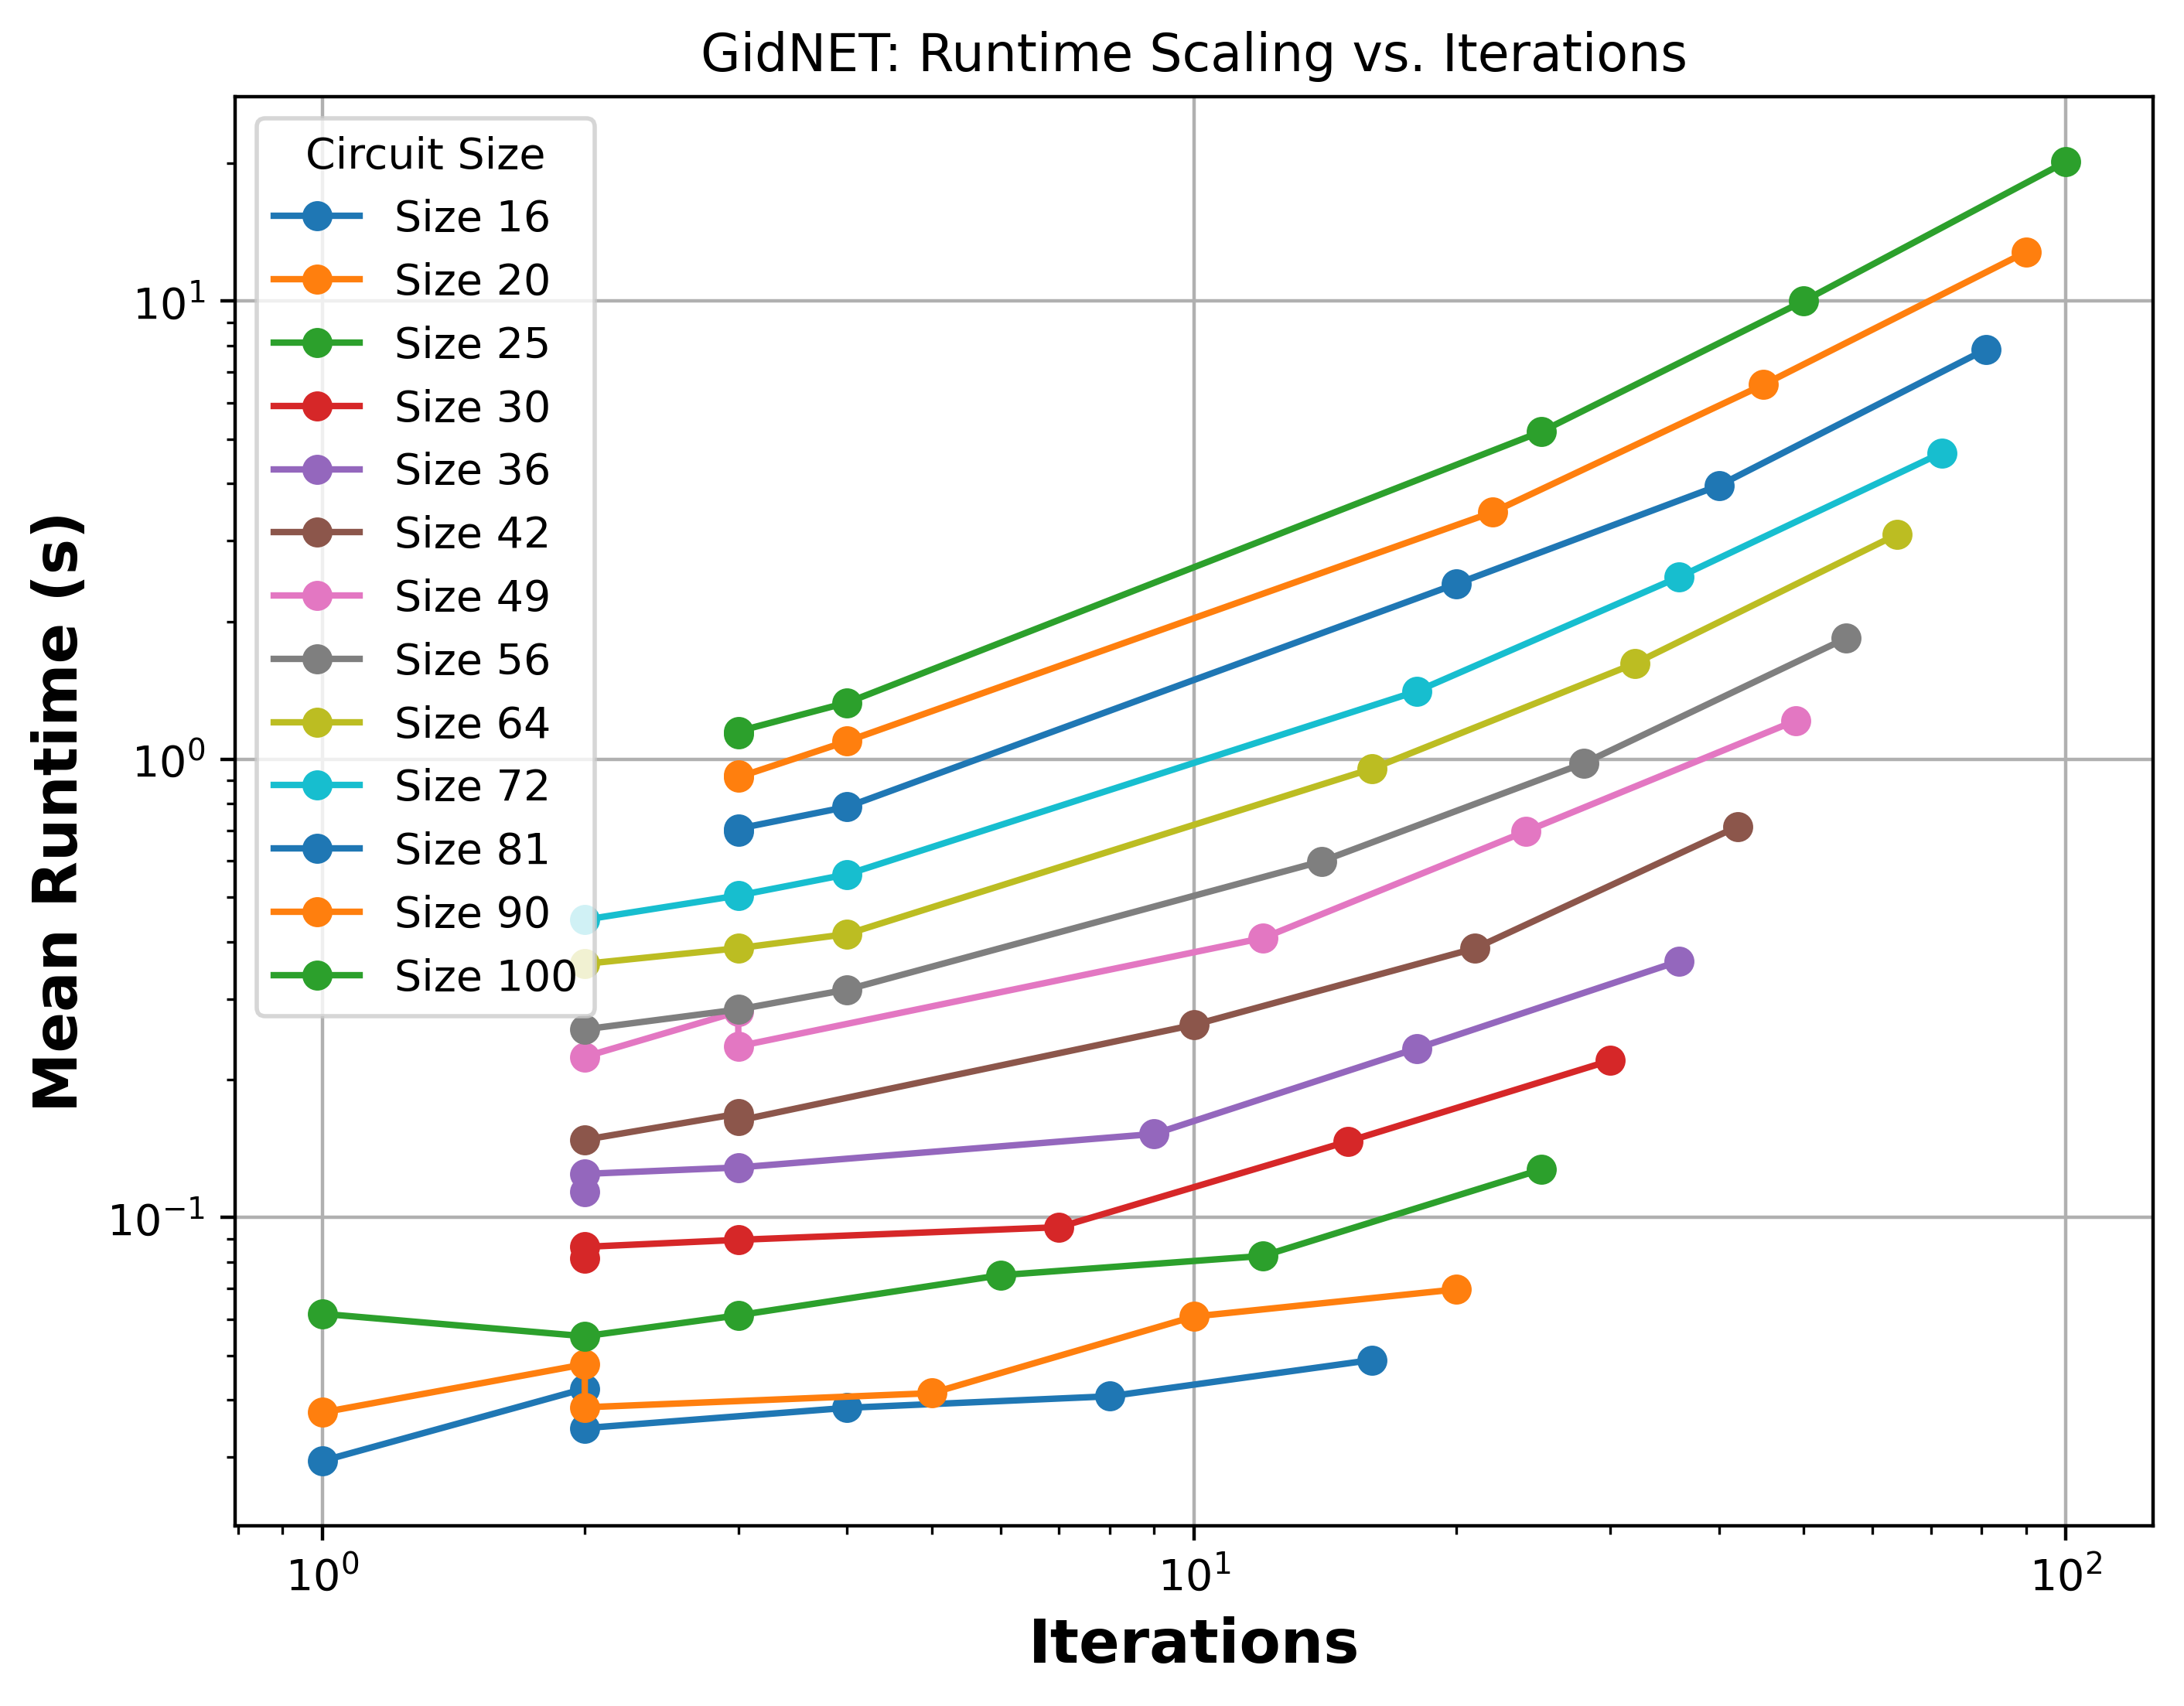

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
data_path = Path("GRCS_result/gidnet_iterations_scaling_analysis.csv")
df = pd.read_csv(data_path)

# Plot Circuit Width vs. Iterations
plt.figure(figsize=(8, 6), dpi=400)
for circuit_size in df["Circuit Size"].unique():
    subset = df[df["Circuit Size"] == circuit_size]
    plt.plot(subset["Iterations"], subset["Min Width"], marker="o", label=f"Size {circuit_size}")

plt.xlabel("Iterations", fontsize=14, fontweight="bold")
plt.ylabel("Final Circuit Width", fontsize=14, fontweight="bold")
plt.xscale("log")  # Log scale for better visualization
plt.legend(title="Circuit Size")
plt.grid(True)
plt.title("GidNET: Circuit Width Convergence vs. Iterations")
plt.savefig("GRCS_result/gidnet_width_vs_iterations.pdf", format="pdf", bbox_inches="tight")
plt.show()


# Plot Runtime vs. Iterations
plt.figure(figsize=(8, 6), dpi=400)
for circuit_size in df["Circuit Size"].unique():
    subset = df[df["Circuit Size"] == circuit_size]
    plt.plot(subset["Iterations"], subset["Mean Runtime"], marker="o", label=f"Size {circuit_size}")

plt.xlabel("Iterations", fontsize=14, fontweight="bold")
plt.ylabel("Mean Runtime (s)", fontsize=14, fontweight="bold")
plt.xscale("log")
plt.yscale("log")  # Log-log scale to detect polynomial scaling
plt.legend(title="Circuit Size")
plt.grid(True)
plt.title("GidNET: Runtime Scaling vs. Iterations")
plt.savefig("GRCS_result/gidnet_runtime_vs_iterations.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [11]:
import numpy as np
import pandas as pd
import time
import logging
from pathlib import Path
from gidnet.qubitreuse import GidNET
from gidnet.utils import safe_eval
from benchmarks.qcg.helper_functions.benchmarks import generate_circ
from math import log, floor
import matplotlib.pyplot as plt
import seaborn as sns

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define parameters
depth = 11  # Change depth as needed
circuit_sizes = [16, 20, 25, 30, 36, 42, 49, 56, 64, 72, 81, 90, 100]  # Test cases
num_trials = 30  # Number of trials per iteration setting

def compute_iteration_counts(n):
    """Computes different iteration values based on the circuit size n."""
    return [
        n,
        max(1, floor(n / 2)),  # Ensure at least 1 iteration
        max(1, floor(n / 4)),
        max(1, floor(log(n))),  # Log(n)
        max(1, floor(log(n / 2))),
        max(1, floor(log(n / 4))),
    ]

# Store results
results = []

# Run experiments
for circuit_size in circuit_sizes:
    logging.info(f"Running optimization test for circuit size {circuit_size}")
    
    # Generate test circuit
    circuit = generate_circ(
        num_qubits=circuit_size,
        depth=1,
        circuit_type="supremacy",
        reg_name="q",
        connected_only=True,
        seed=None,
    )
    circuit.measure_all()

    # Compute iteration counts
    iteration_values = compute_iteration_counts(circuit_size)

    for iterations in iteration_values:
        logging.info(f"Running GidNET with {iterations} iterations for circuit size {circuit_size}")
        
        gidnet = GidNET(circuit)
        width_distributions = []

        for _ in range(num_trials):  # Run multiple trials per iteration count
            gidnet.compile_to_dynamic_circuit(iterations)
            width_distributions.append(gidnet.dynamic_circuit_width)

        # Store results: circuit size, iterations, width distribution
        results.append([circuit_size, iterations, width_distributions])

# Convert results to DataFrame
df = pd.DataFrame(results, columns=["Circuit Size", "Iterations", "Width Distribution"])

# Save results
output_path = Path("GRCS_result")
output_path.mkdir(parents=True, exist_ok=True)
df.to_csv(output_path / "gidnet_width_distribution_analysis.csv", index=False)

logging.info("Experiment completed. Results saved to CSV.")


Running optimization test for circuit size 16
Generating 4x4, 1+8+1 supremacy circuit
Running GidNET with 16 iterations for circuit size 16
Running GidNET with 8 iterations for circuit size 16
Running GidNET with 4 iterations for circuit size 16
Running GidNET with 2 iterations for circuit size 16
Running GidNET with 2 iterations for circuit size 16
Running GidNET with 1 iterations for circuit size 16
Running optimization test for circuit size 20
Generating 5x4, 1+8+1 supremacy circuit
Running GidNET with 20 iterations for circuit size 20
Running GidNET with 10 iterations for circuit size 20
Running GidNET with 5 iterations for circuit size 20
Running GidNET with 2 iterations for circuit size 20
Running GidNET with 2 iterations for circuit size 20
Running GidNET with 1 iterations for circuit size 20
Running optimization test for circuit size 25
Generating 5x5, 1+8+1 supremacy circuit
Running GidNET with 25 iterations for circuit size 25
Running GidNET with 12 iterations for circuit siz

/tmp/ipykernel_678806/234094652.py:26: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(subset["Width"], label=f"Iterations = {iteration}", fill=True, alpha=0.3)


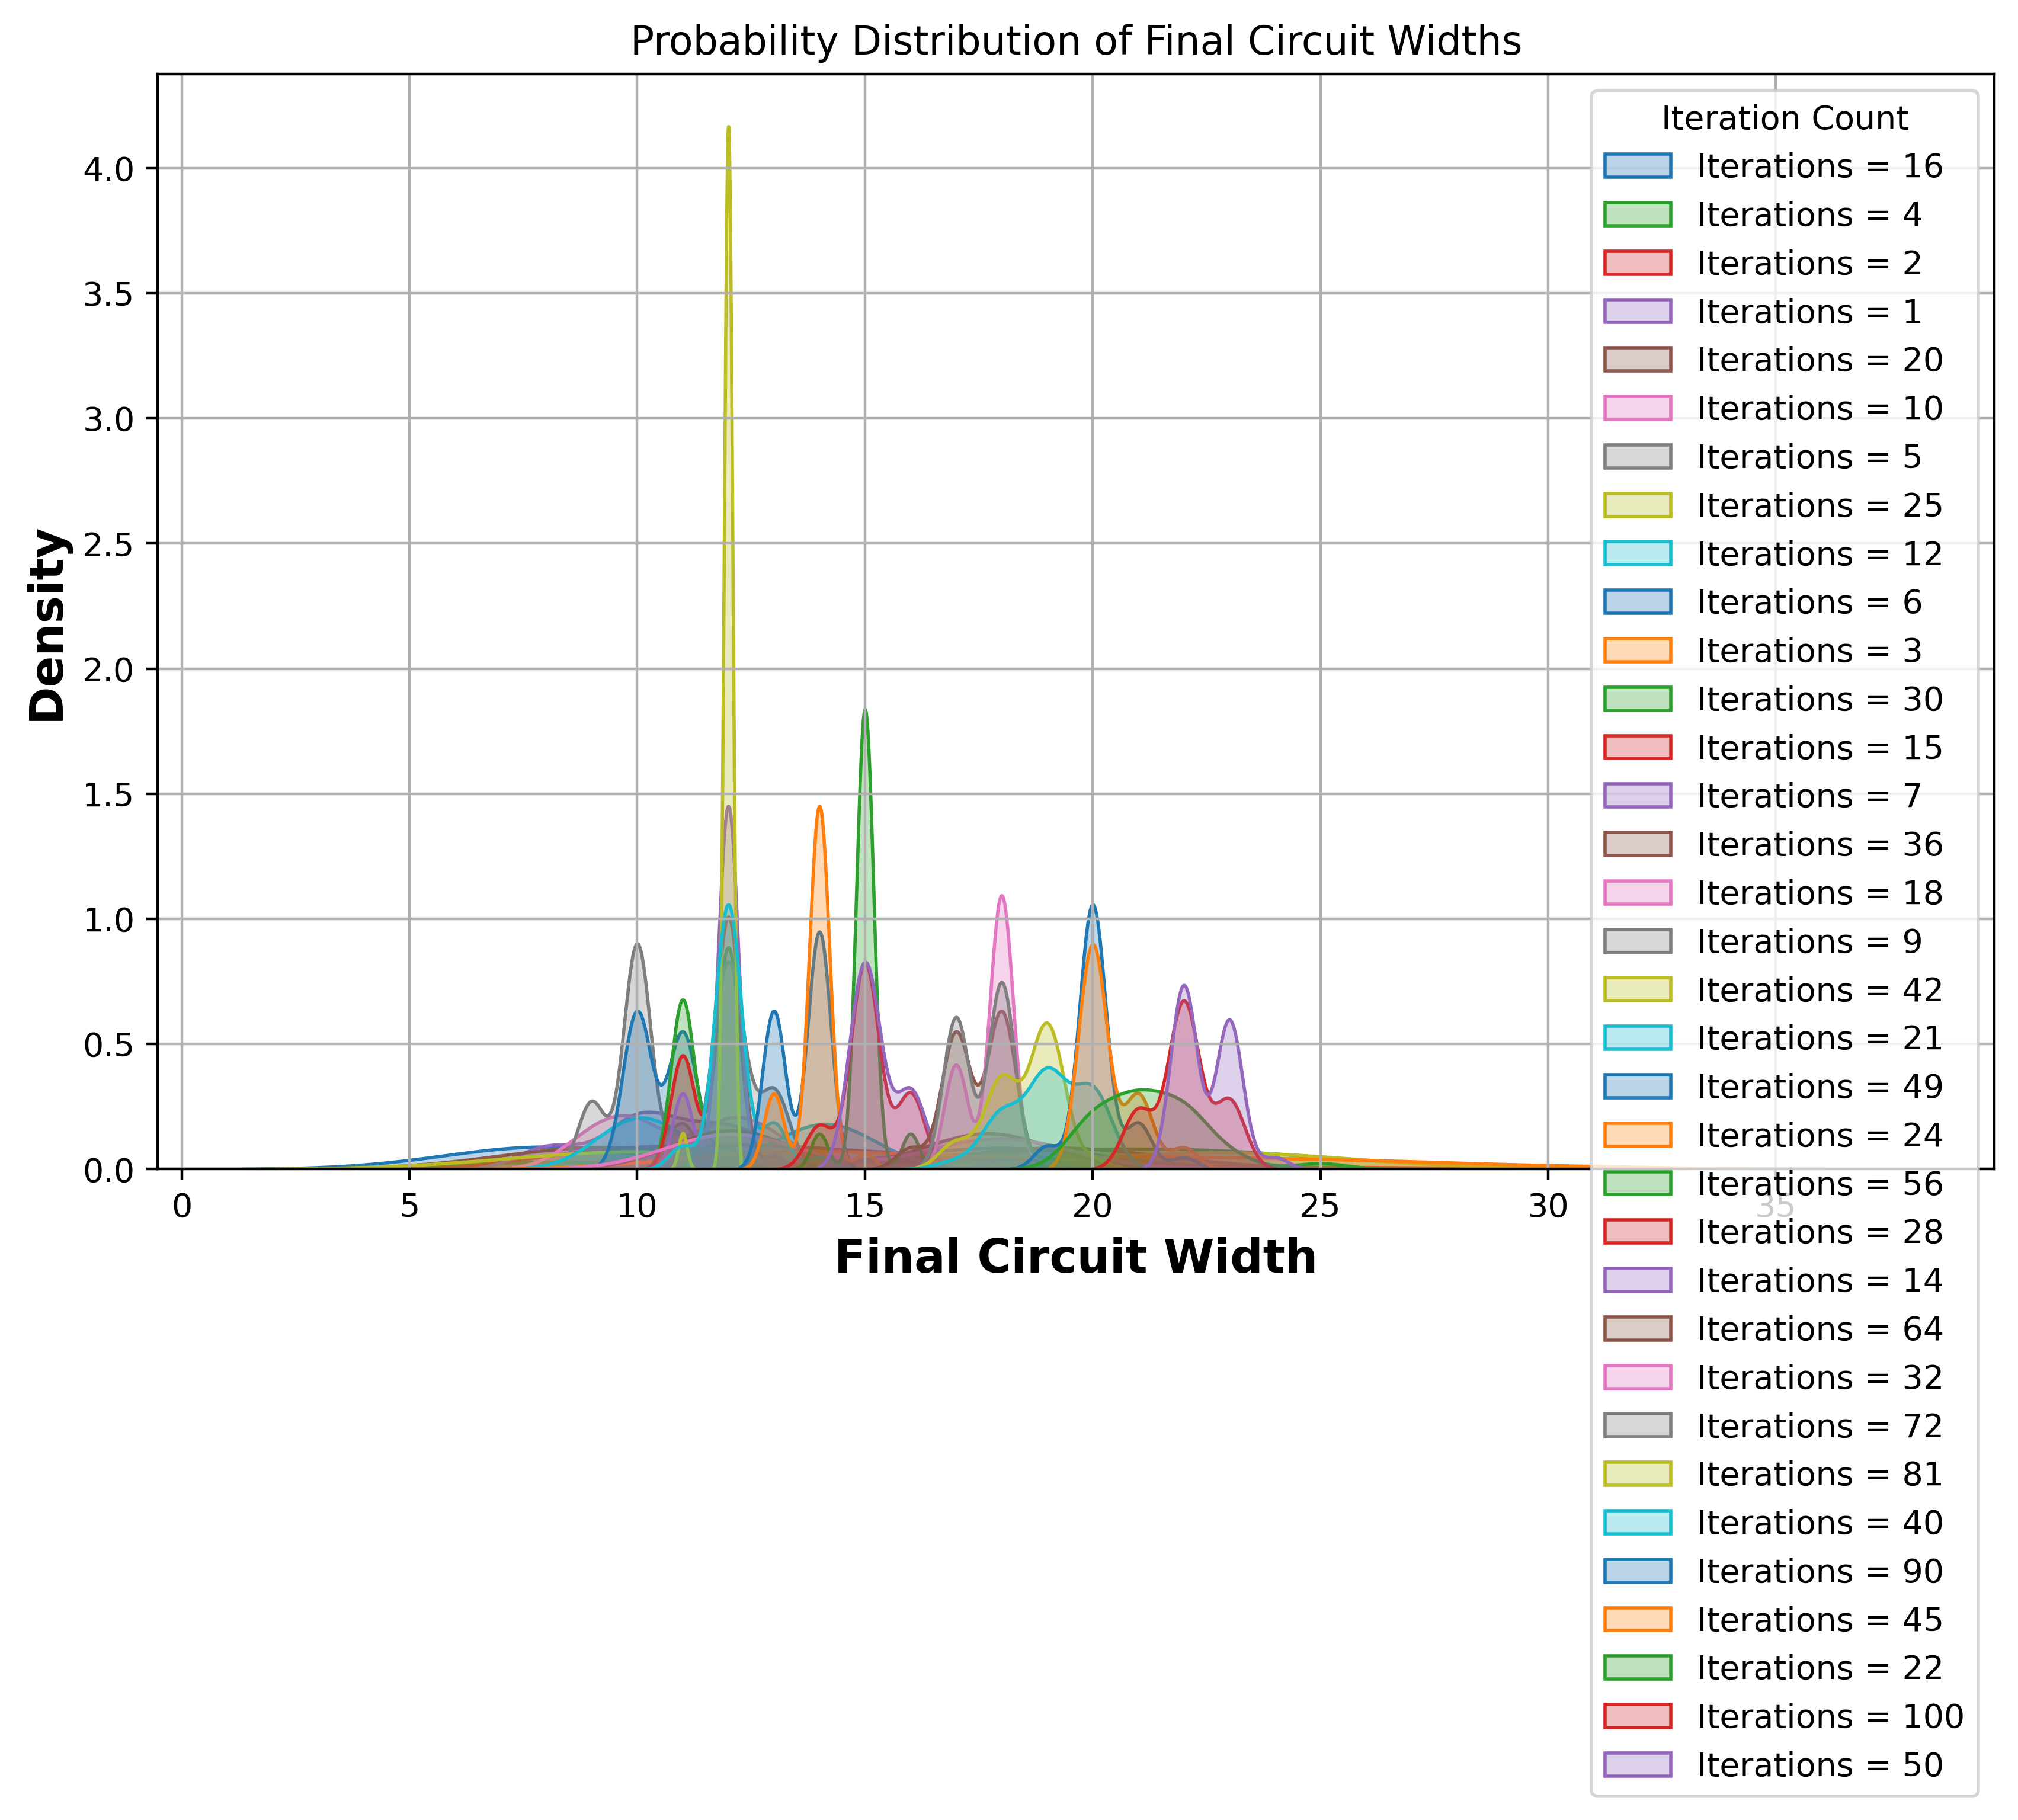

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from pathlib import Path

# Load the data
data_path = Path("GRCS_result/gidnet_width_distribution_analysis.csv")
df = pd.read_csv(data_path)

# Convert string representation of lists back to actual lists
df["Width Distribution"] = df["Width Distribution"].apply(ast.literal_eval)

# Flatten the dataset for plotting
expanded_data = []
for _, row in df.iterrows():
    for width in row["Width Distribution"]:
        expanded_data.append([row["Circuit Size"], row["Iterations"], width])

df_expanded = pd.DataFrame(expanded_data, columns=["Circuit Size", "Iterations", "Width"])

# Create probability distributions per iteration count
plt.figure(figsize=(10, 6), dpi=400)
for iteration in df_expanded["Iterations"].unique():
    subset = df_expanded[df_expanded["Iterations"] == iteration]
    sns.kdeplot(subset["Width"], label=f"Iterations = {iteration}", fill=True, alpha=0.3)

plt.xlabel("Final Circuit Width", fontsize=14, fontweight="bold")
plt.ylabel("Density", fontsize=14, fontweight="bold")
plt.legend(title="Iteration Count")
plt.grid(True)
plt.title("Probability Distribution of Final Circuit Widths")
plt.savefig("GRCS_result/gidnet_width_distribution_analysis.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [13]:
import numpy as np

# Find the most frequent minimum width per iteration count
min_width_summary = df_expanded.groupby("Iterations")["Width"].min()
optimal_iteration = min_width_summary.idxmin()

print(f"Optimal Iteration Count: {optimal_iteration}")


Optimal Iteration Count: 1


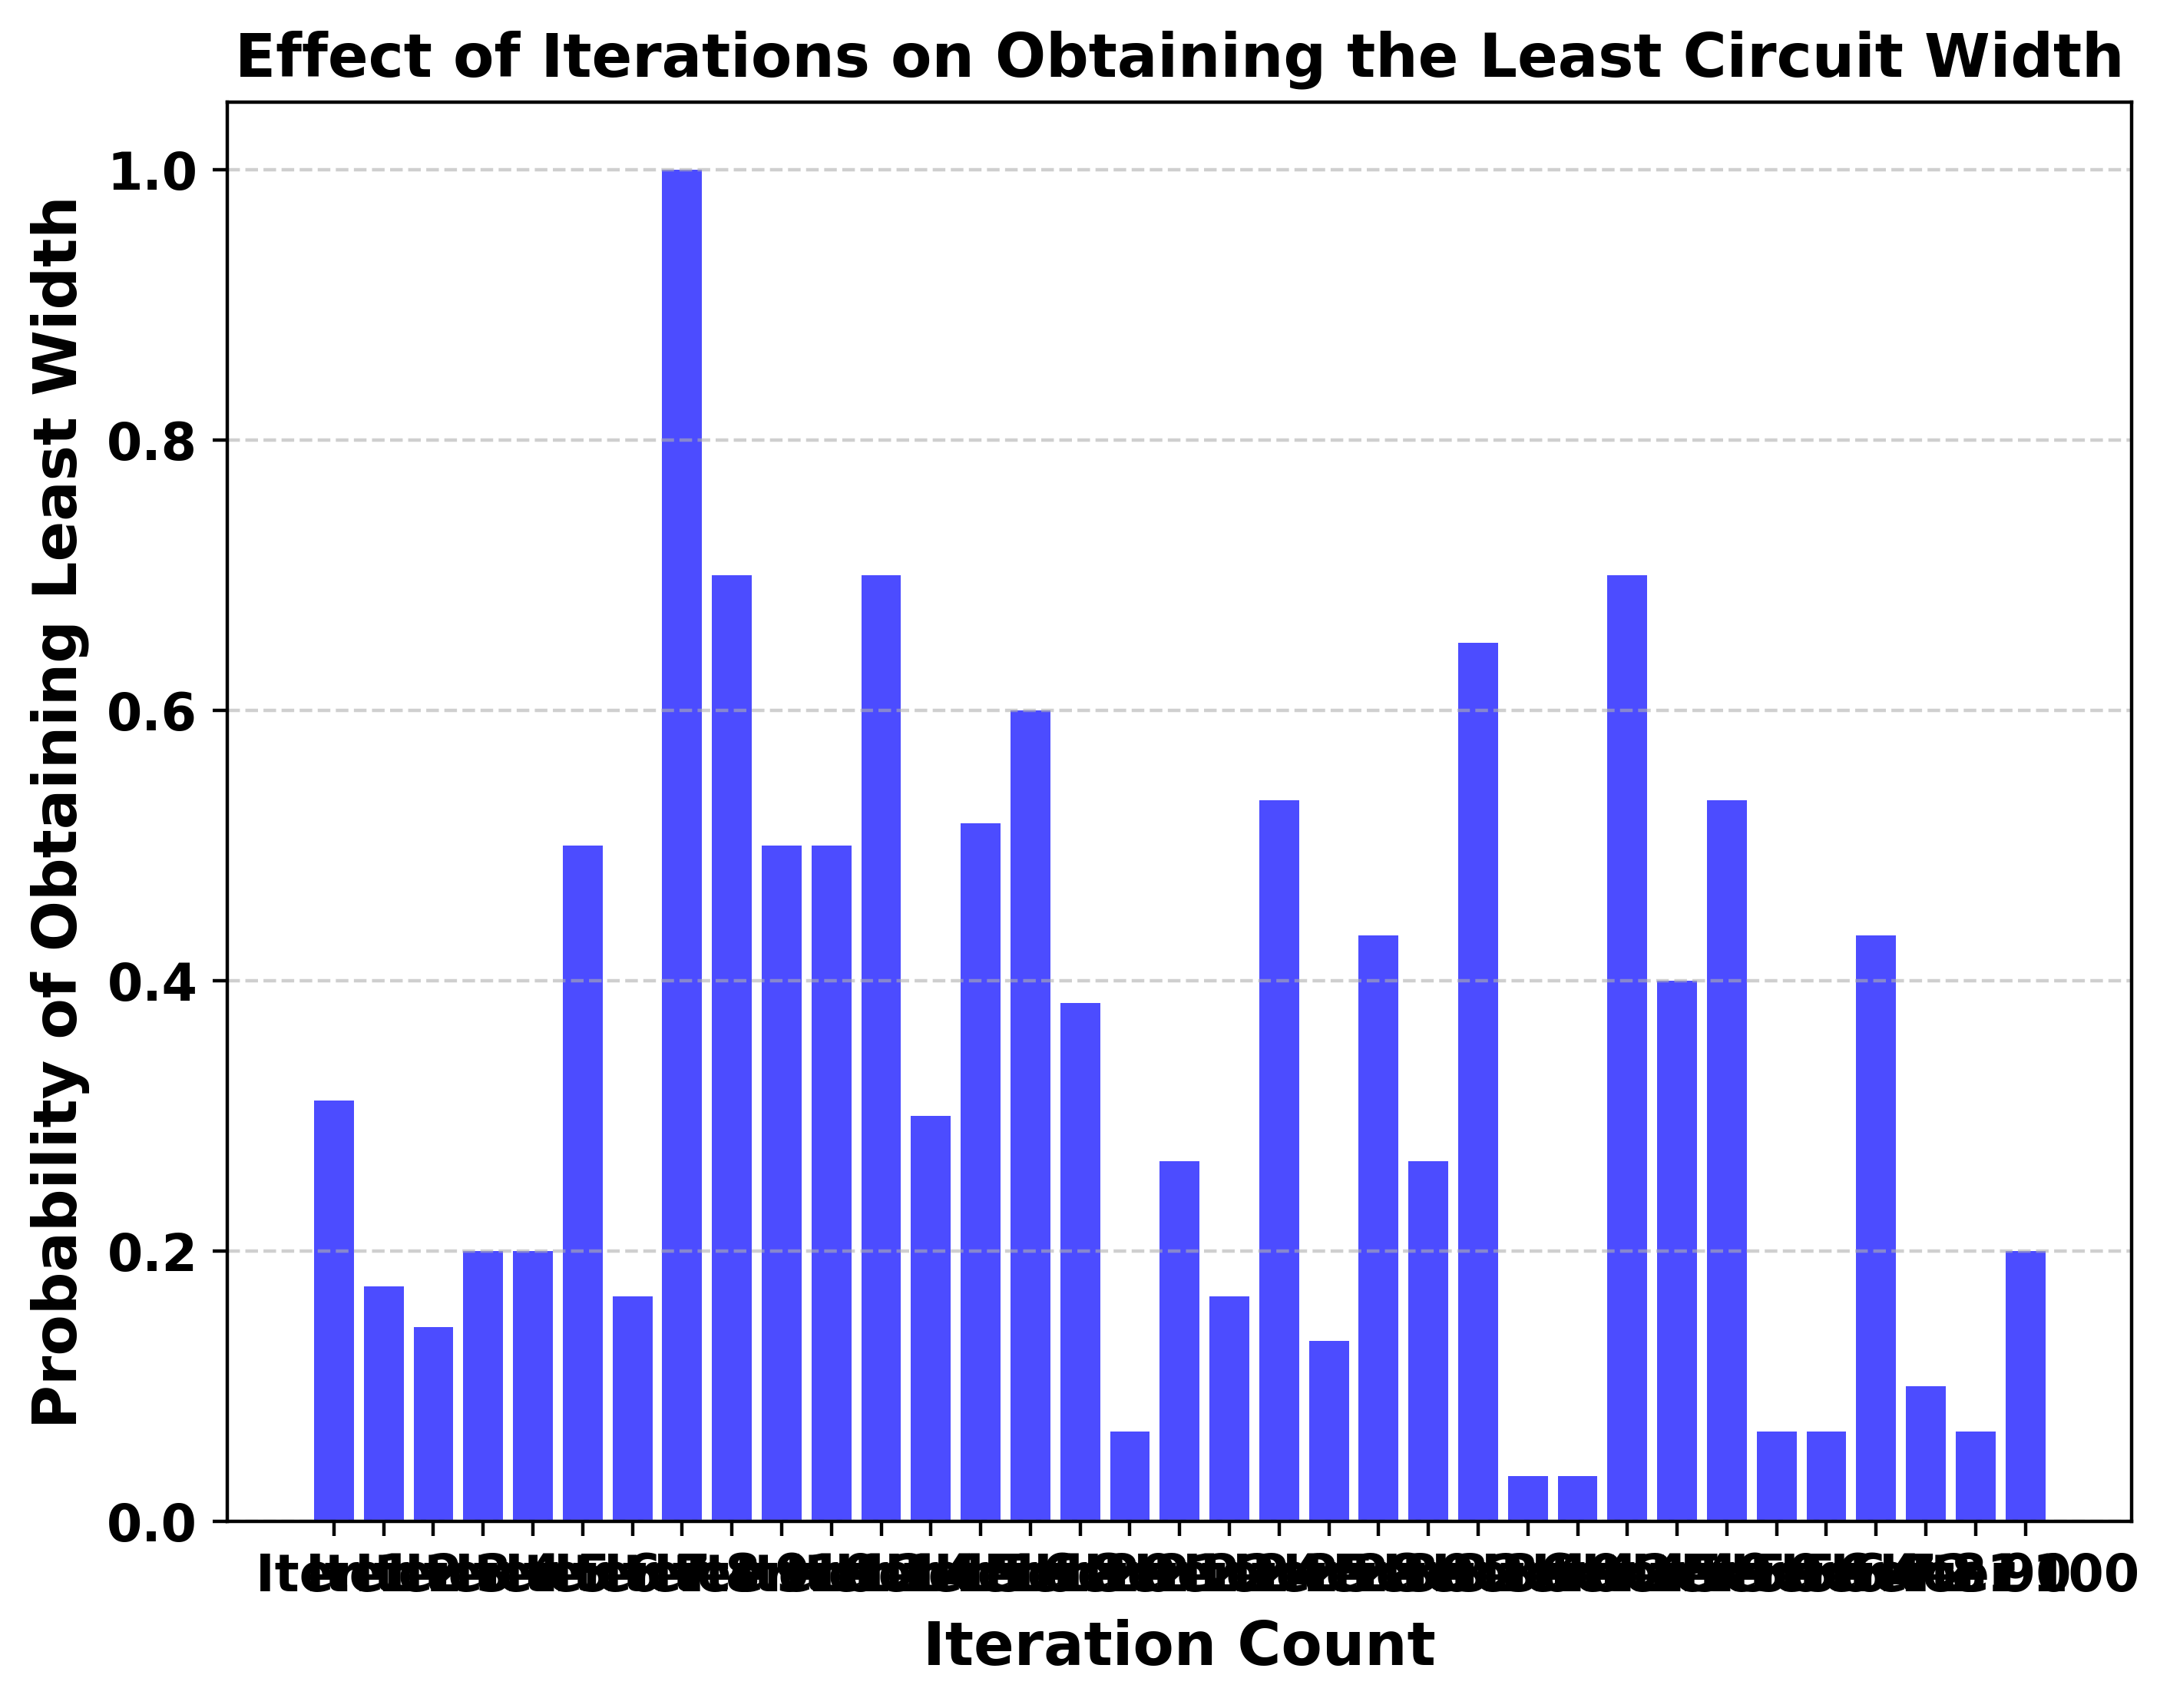

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np
from pathlib import Path

# Load the data
data_path = Path("GRCS_result/gidnet_width_distribution_analysis.csv")
df = pd.read_csv(data_path)

# Convert string representation of lists back to actual lists
df["Width Distribution"] = df["Width Distribution"].apply(ast.literal_eval)

# Compute the least width observed for each circuit size
df["Min Observed Width"] = df["Width Distribution"].apply(min)

# Flatten the dataset to count occurrences of the least width
expanded_data = []
for _, row in df.iterrows():
    for width in row["Width Distribution"]:
        expanded_data.append([row["Circuit Size"], row["Iterations"], width == row["Min Observed Width"]])  # Mark if it's the min width

df_expanded = pd.DataFrame(expanded_data, columns=["Circuit Size", "Iterations", "Is Min Width"])

# Compute the probability of obtaining the least width for each iteration count
probability_distribution = df_expanded.groupby("Iterations")["Is Min Width"].mean()

# Sort by iteration count
probability_distribution = probability_distribution.sort_index()

# Define x-axis labels
x_labels = ["n", "n/2", "n/4", "log(n)", "log(n/2)", "log(n/4)"]

# Ensure we match the labels correctly
if len(probability_distribution) != len(x_labels):
    x_labels = [f"Iter {i}" for i in probability_distribution.index]

# Plot the probability distribution as a bar chart
plt.figure(figsize=(8, 6), dpi=400)
plt.bar(x_labels, probability_distribution, color="blue", alpha=0.7)

# Formatting
plt.xlabel("Iteration Count", fontsize=14, fontweight="bold")
plt.ylabel("Probability of Obtaining Least Width", fontsize=14, fontweight="bold")
plt.title("Effect of Iterations on Obtaining the Least Circuit Width", fontsize=14, fontweight="bold")
plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Save the figure
plt.savefig("GRCS_result/gidnet_iteration_vs_min_width_probability.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()


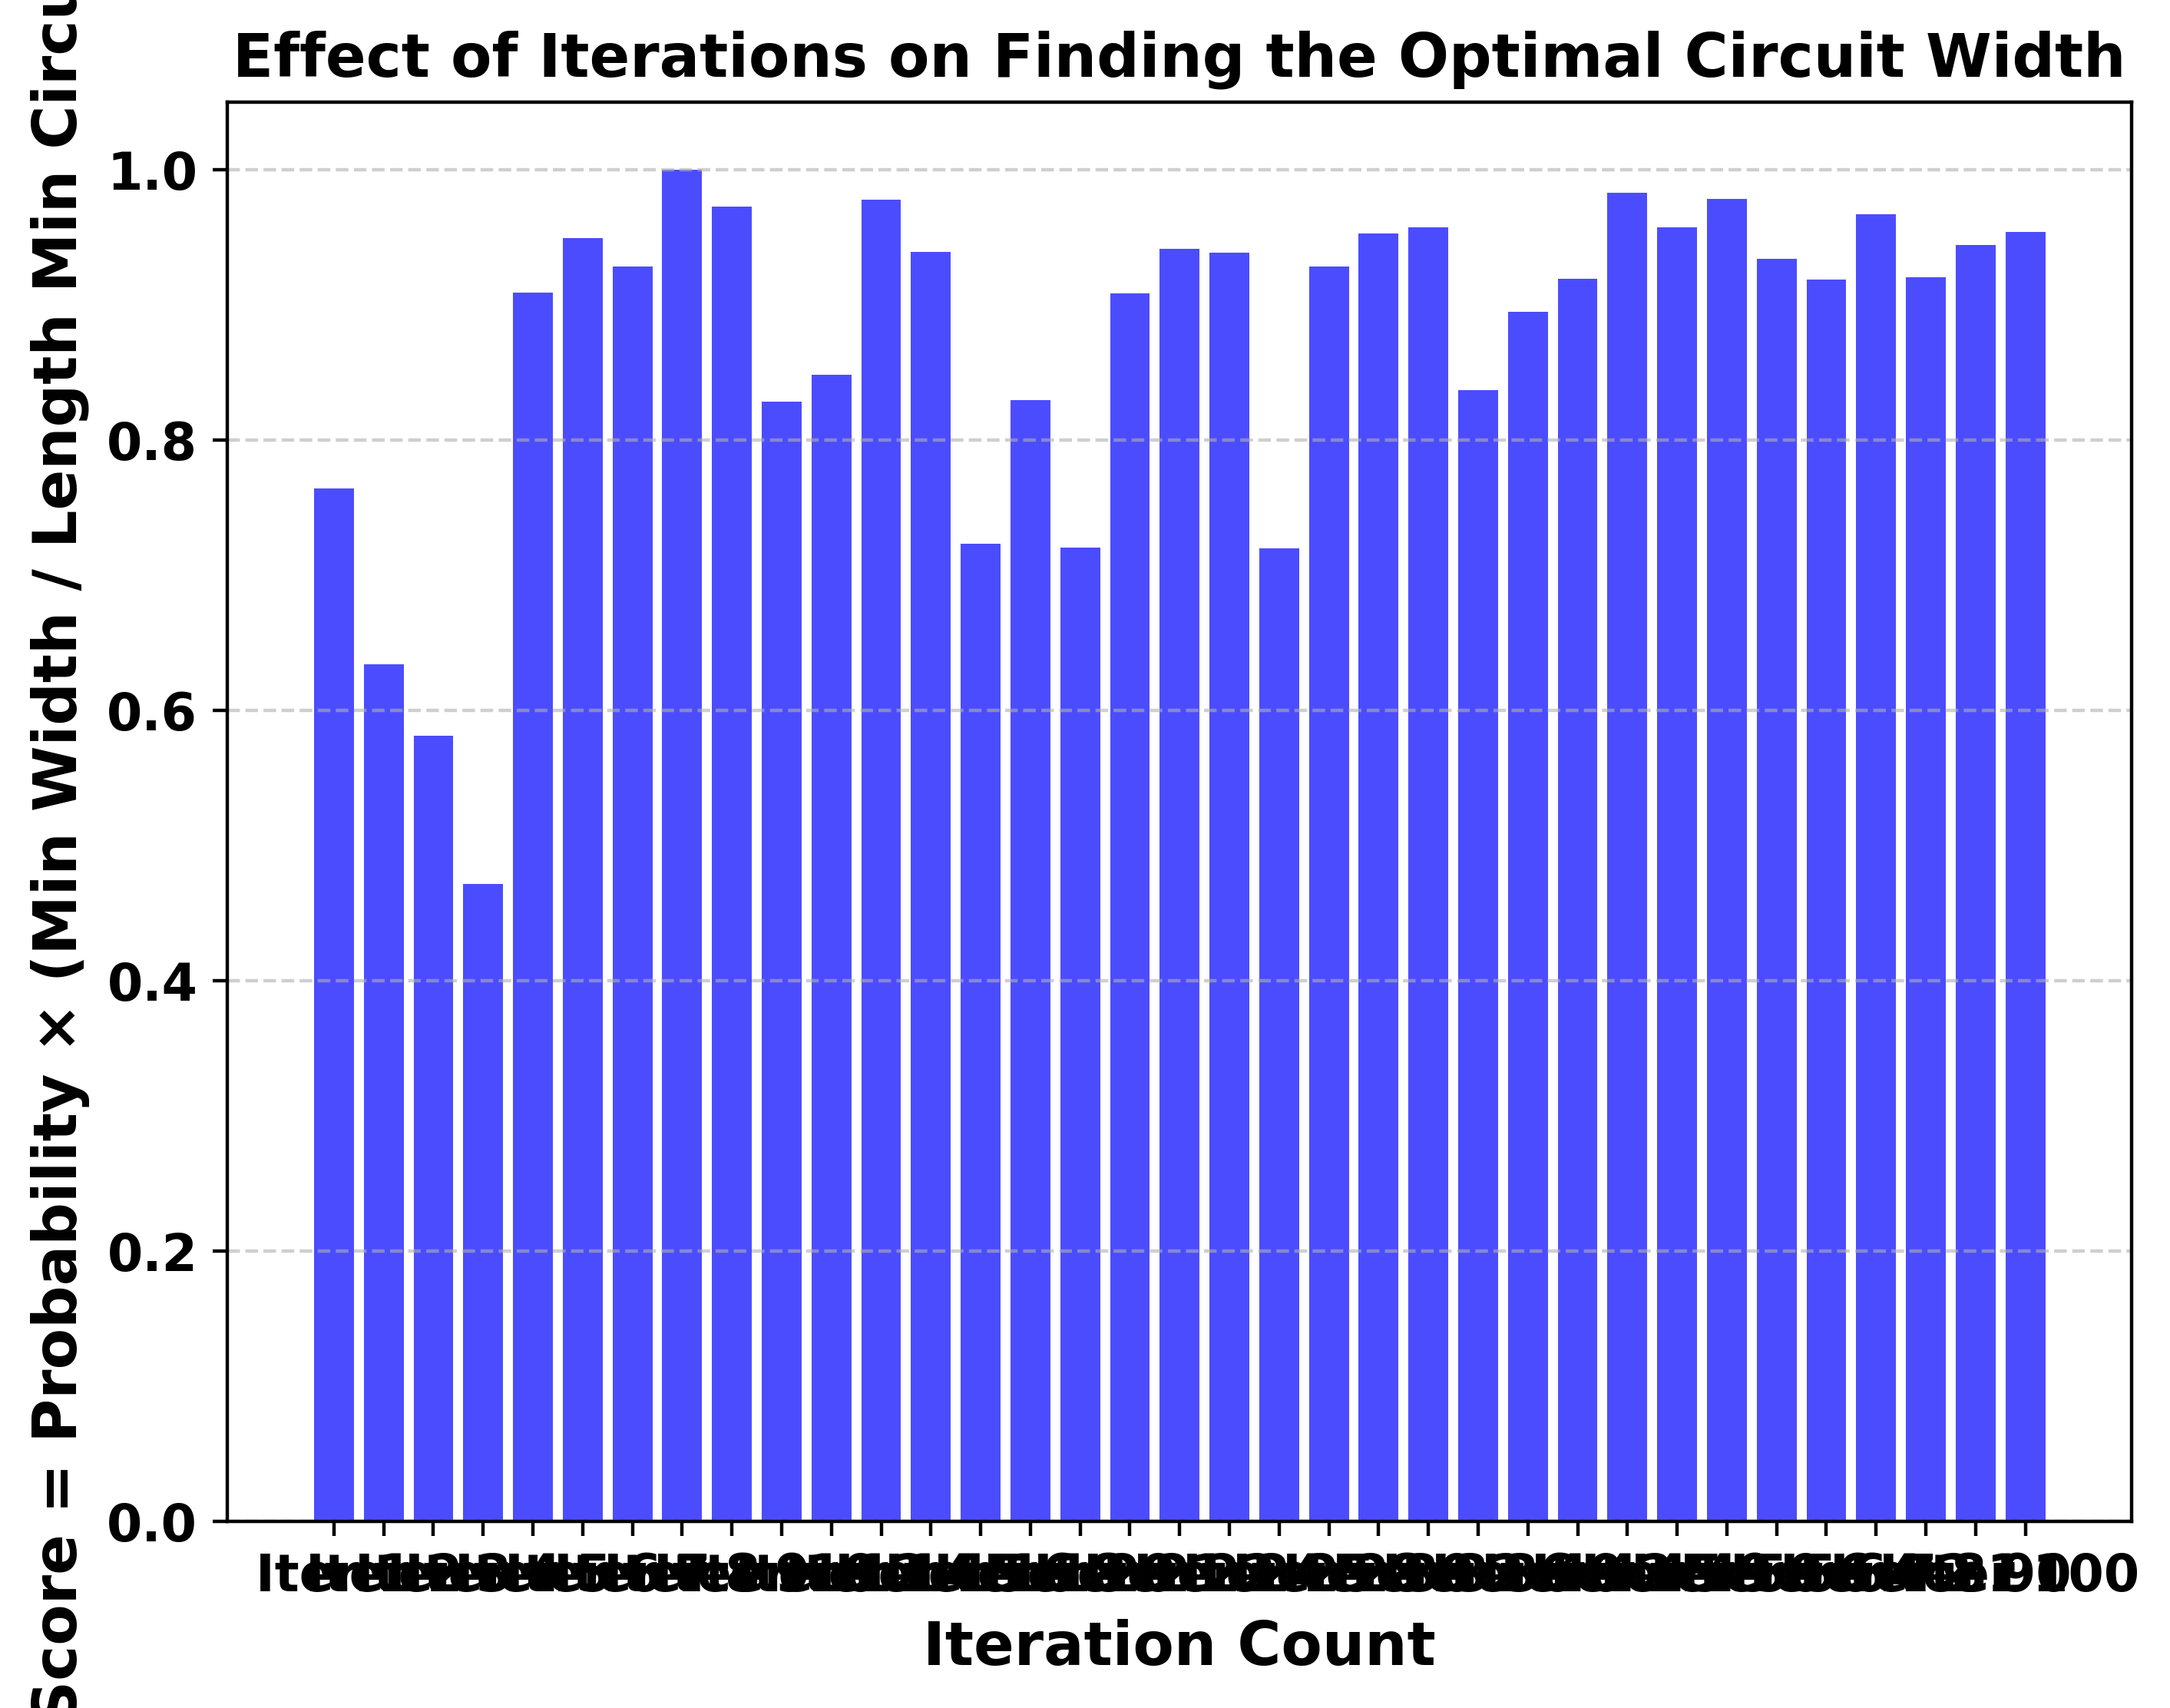

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np
from pathlib import Path

# Load the data
data_path = Path("GRCS_result/gidnet_width_distribution_analysis.csv")
df = pd.read_csv(data_path)

# Convert string representation of lists back to actual lists
df["Width Distribution"] = df["Width Distribution"].apply(ast.literal_eval)

# Compute the least width observed for each circuit size
df["Min Observed Width"] = df["Width Distribution"].apply(min)

# Flatten the dataset to count occurrences of the least width
expanded_data = []
for _, row in df.iterrows():
    for width in row["Width Distribution"]:
        expanded_data.append([row["Circuit Size"], row["Iterations"], width])  

df_expanded = pd.DataFrame(expanded_data, columns=["Circuit Size", "Iterations", "Width"])

# Compute probability of each width occurring per iteration count
width_counts = df_expanded.groupby(["Iterations", "Width"]).size()
total_counts = df_expanded.groupby("Iterations").size()
probability_distribution = (width_counts / total_counts).reset_index()
probability_distribution.columns = ["Iterations", "Width", "Probability"]

# Score function
def score_elements(elements):
    widths = [ele[0] for ele in elements]
    min_width = min(widths)
    scores = []
    for element in elements:
        length_min_circuit, probability = element
        score = probability * (min_width / length_min_circuit)  
        scores.append(score)
    return scores

# Apply the scoring function
iteration_scores = []
for iter_count, group in probability_distribution.groupby("Iterations"):
    elements = list(zip(group["Width"], group["Probability"]))
    scores = score_elements(elements)
    iteration_scores.append([iter_count, np.sum(scores)])  

df_scores = pd.DataFrame(iteration_scores, columns=["Iterations", "Score"])
df_scores = df_scores.sort_values("Iterations")

# Define x-axis labels
x_labels = ["n", "n/2", "n/4", "log(n)", "log(n/2)", "log(n/4)"]

# Ensure we match the labels correctly
if len(df_scores) != len(x_labels):
    x_labels = [f"Iter {i}" for i in df_scores["Iterations"]]

# Plot the probability distribution as a bar chart
plt.figure(figsize=(8, 6), dpi=400)
plt.bar(x_labels, df_scores["Score"], color="blue", alpha=0.7)

# Formatting
plt.xlabel("Iteration Count", fontsize=14, fontweight="bold")
plt.ylabel("Score = Probability × (Min Width / Length Min Circuit)", fontsize=14, fontweight="bold")
plt.title("Effect of Iterations on Finding the Optimal Circuit Width", fontsize=14, fontweight="bold")
plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Save the figure
plt.savefig("GRCS_result/gidnet_iteration_vs_optimal_width_score.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()


In [ ]:
def find_minimum_width_sets(A):
    """
    Finds and returns the elements in the main list that have the smallest length.

    Parameters:
    A (list of list of lists): The main list containing sublists of lists.

    Returns:
    list: A list containing the elements from A that have the smallest length.
    """
    
    # Step 1: Determine the length of each element in A
    lengths = [len(a) for a in A]

    # Step 2: Find the smallest length among the elements
    min_length = min(lengths)

    # Step 3: Collect all elements that match this smallest length
    smallest_length_elements = [a for a in A if len(a) == min_length]

    return smallest_length_elements

Processing Circuit: 10x11
Processing Circuit: 11x11
Processing Circuit: 11x12
Processing Circuit: 12x12
Iteration analysis completed and saved.


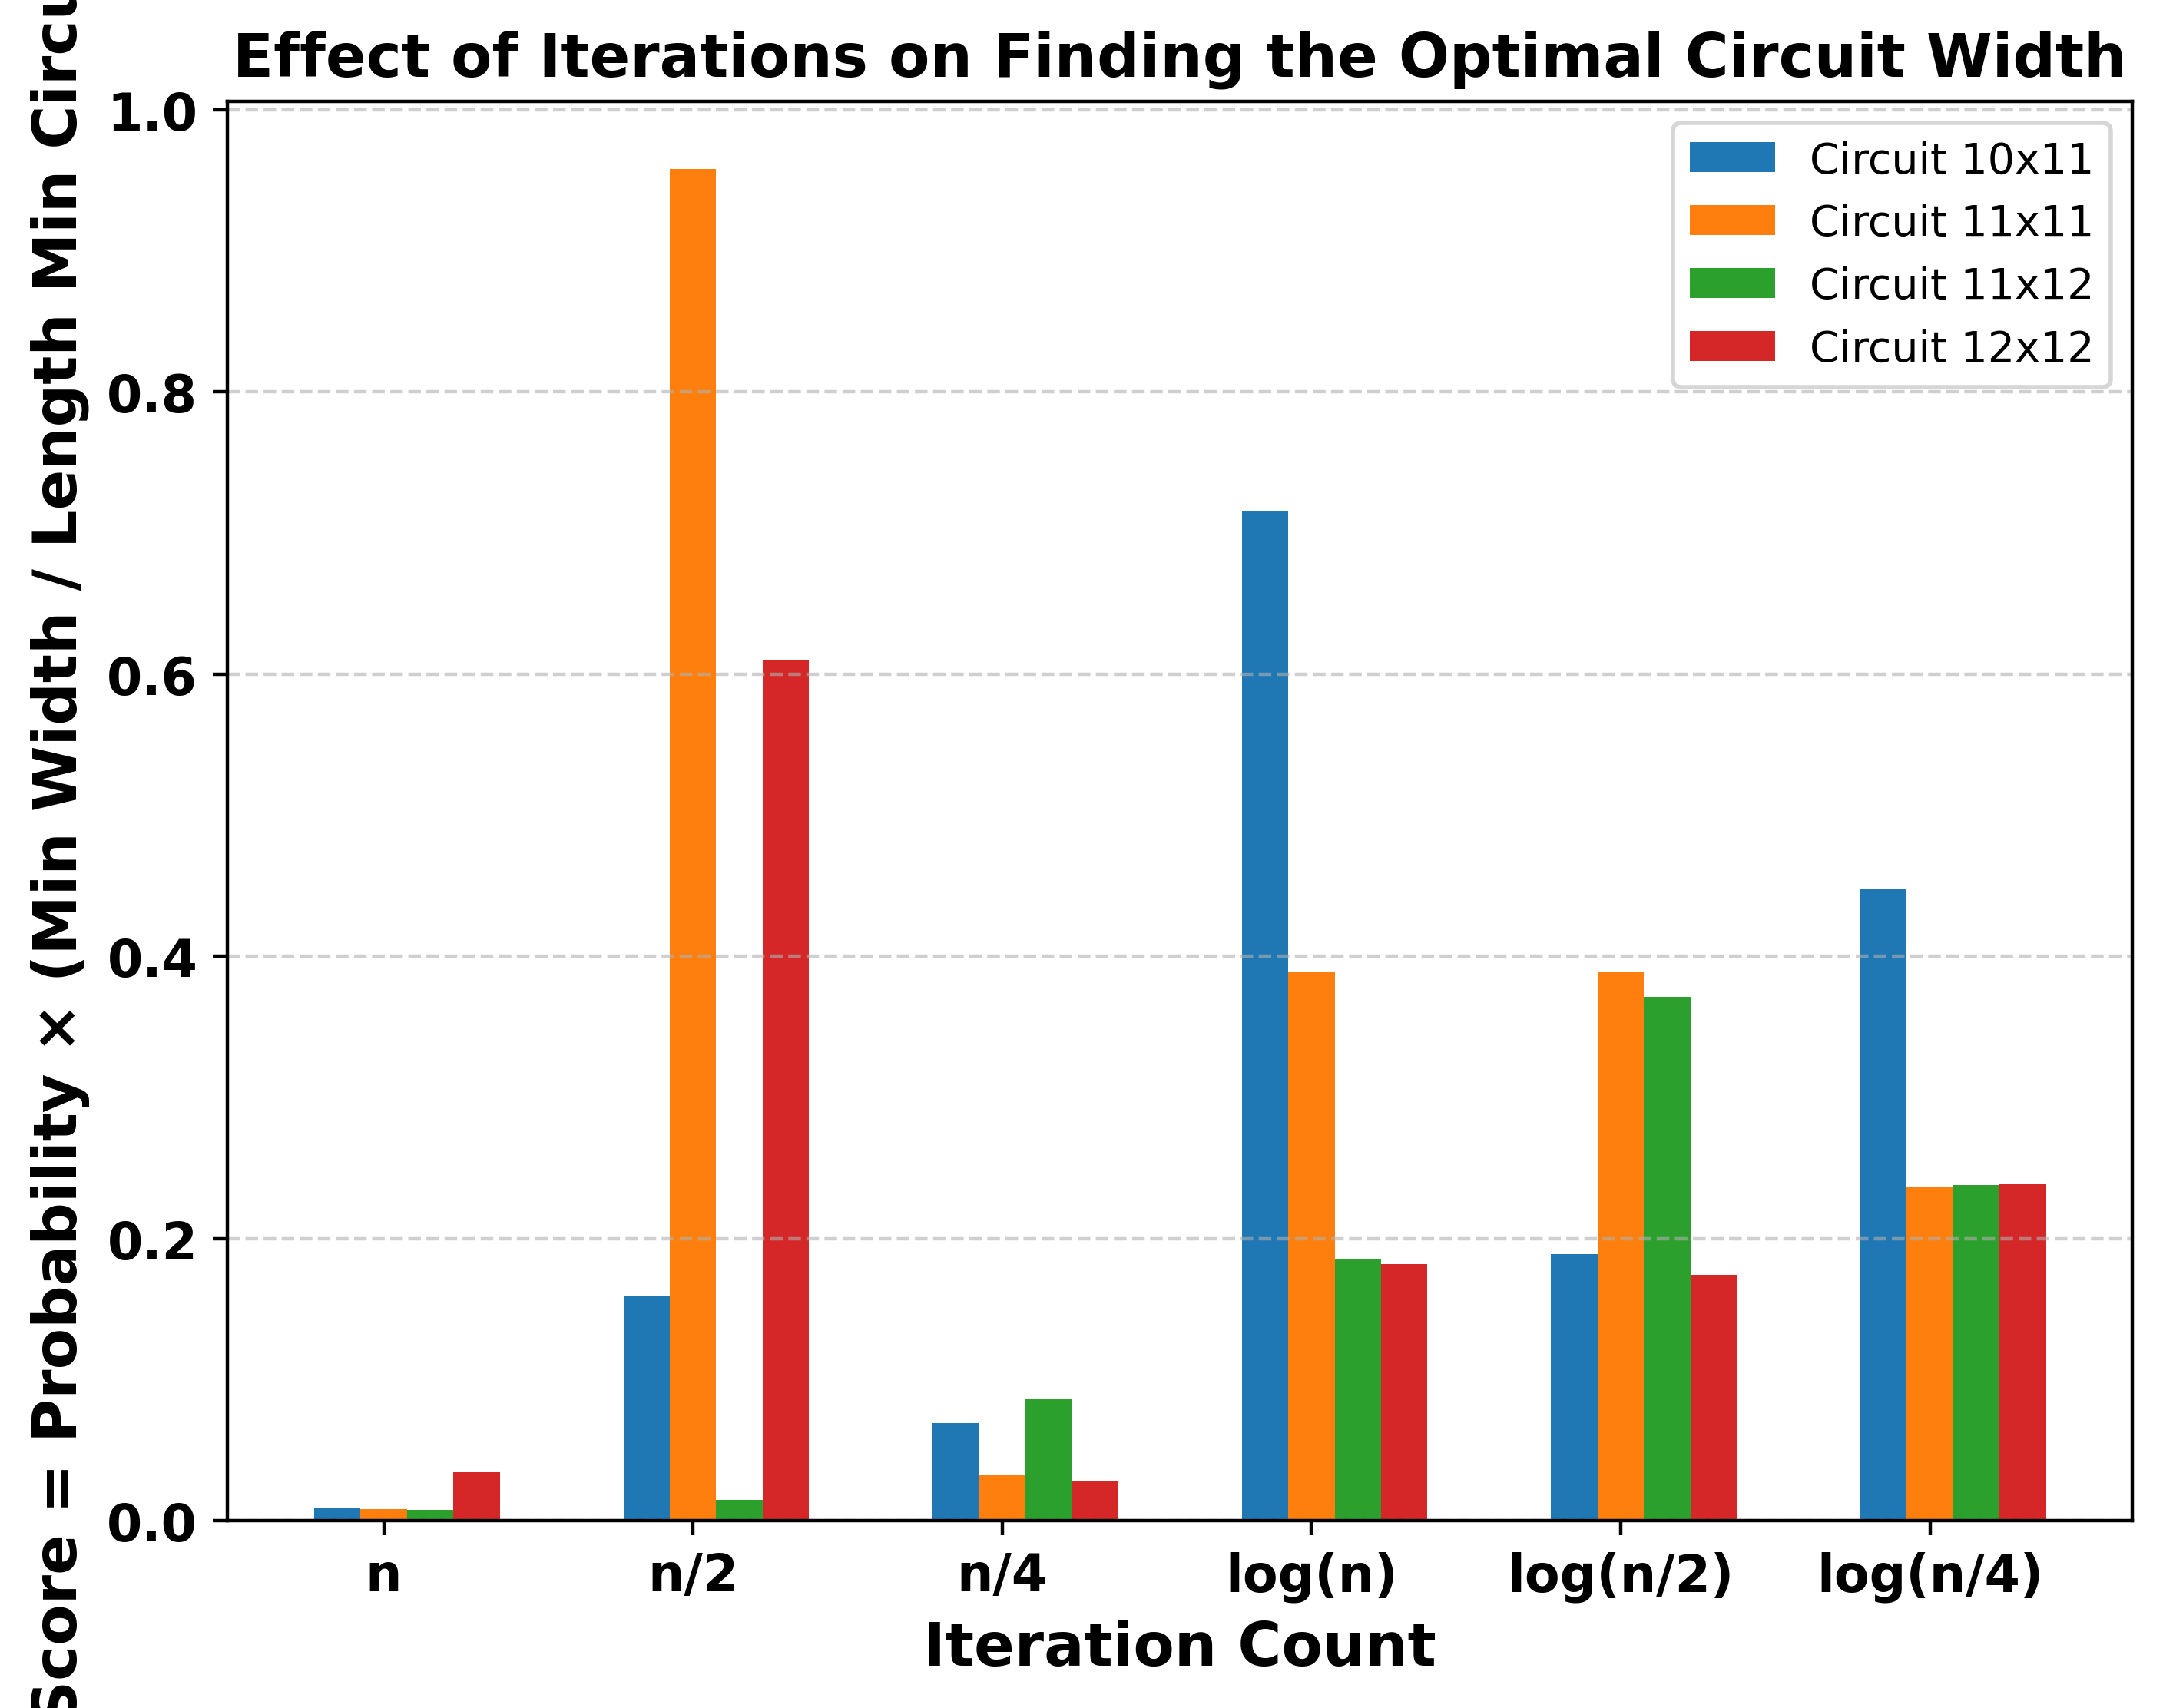

In [18]:
#!/usr/bin/env python3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from gidnet.qubitreuse import GidNET
from gidnet.utils import safe_eval, create_qiskit_and_qnet_GRCS_circuits
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Set the experiment parameters
circuit_sizes = ["10x11", "11x11", "11x12", "12x12"]  # Circuit sizes
cycle_num = 13  # Depth of circuits

# Get the current working directory (repo root if running from the repo)
repo_path = Path.cwd()

# Define the data directory path
directory_path = repo_path / "data" / "GRSC"
# directory_path = Path("data/GRCS")  # Data directory

# Define iteration settings
iteration_labels = ["n", "n/2", "n/4", "log(n)", "log(n/2)", "log(n/4)"]

# Scoring function
def score_elements(elements):
    """
    Compute scores for different iteration settings.

    Parameters:
    - elements (list of tuples): Each tuple contains (min width found, probability of finding it)

    Returns:
    - scores (list): Computed scores for each setting.
    """
    widths = [ele[0] for ele in elements]
    min_width = min(widths)
    scores = [prob * (min_width / width) for width, prob in elements]
    return scores

# Initialize results
gidnet_iteration_scores = []

# Run experiments
for circuit_size in circuit_sizes:
    logging.info(f"Processing Circuit: {circuit_size}")
    
    n = safe_eval(circuit_size)  # Convert "10x11" → numeric size
    iteration_counts = [n, n/2, n/4, np.log(n), np.log(n/2), np.log(n/4)]
    gidnet_results = []

    # Load circuit
    qiskit_circuit, _ = create_qiskit_and_qnet_GRCS_circuits(circuit_size, cycle_num, directory_path)

    for iter_count in iteration_counts:
        iter_count = int(np.ceil(iter_count))  # Round up to an integer
        gidnet = GidNET(qiskit_circuit)

        # Run GidNET multiple times to determine min width found
        min_widths = []
        for _ in range(iter_count):
            gidnet.compile_to_dynamic_circuit(iter_count)
            min_widths.append(gidnet.dynamic_circuit_width)

        # Compute probability of finding the min width
        min_width = min(min_widths)
        probability = min_widths.count(min_width) / len(min_widths)

        # Store results
        gidnet_results.append((min_width, probability))

    # Compute scores
    scores = score_elements(gidnet_results)
    gidnet_iteration_scores.append(scores)

# Convert results into DataFrame
df_scores = pd.DataFrame(gidnet_iteration_scores, columns=iteration_labels, index=circuit_sizes)

# Save results to CSV
df_scores.to_csv(directory_path / "gidnet_iteration_analysis.csv", index=True)
logging.info("Iteration analysis completed and saved.")

# Plot results
plt.figure(figsize=(8, 6), dpi=400)
x = np.arange(len(iteration_labels))  # X-axis positions

for i, (circuit_size, scores) in enumerate(df_scores.iterrows()):
    plt.bar(x + i * 0.15, scores, width=0.15, label=f"Circuit {circuit_size}")

# Formatting
plt.xlabel("Iteration Count", fontsize=14, fontweight="bold")
plt.ylabel("Score = Probability × (Min Width / Length Min Circuit)", fontsize=14, fontweight="bold")
plt.xticks(x + 0.15, iteration_labels, fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
plt.title("Effect of Iterations on Finding the Optimal Circuit Width", fontsize=14, fontweight="bold")
plt.legend(fontsize=10, loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Save plot
plt.savefig(directory_path / "gidnet_iteration_vs_optimal_width_score.pdf", format="pdf", bbox_inches="tight")
plt.show()


2025-02-12 11:04:44,255 - INFO - Processing Circuit: 10x11
2025-02-12 11:05:20,914 - INFO - Processing Circuit: 11x11
2025-02-12 11:06:14,732 - INFO - Processing Circuit: 11x12
2025-02-12 11:07:31,180 - INFO - Processing Circuit: 12x12
2025-02-12 11:09:18,960 - INFO - Iteration analysis completed and saved.


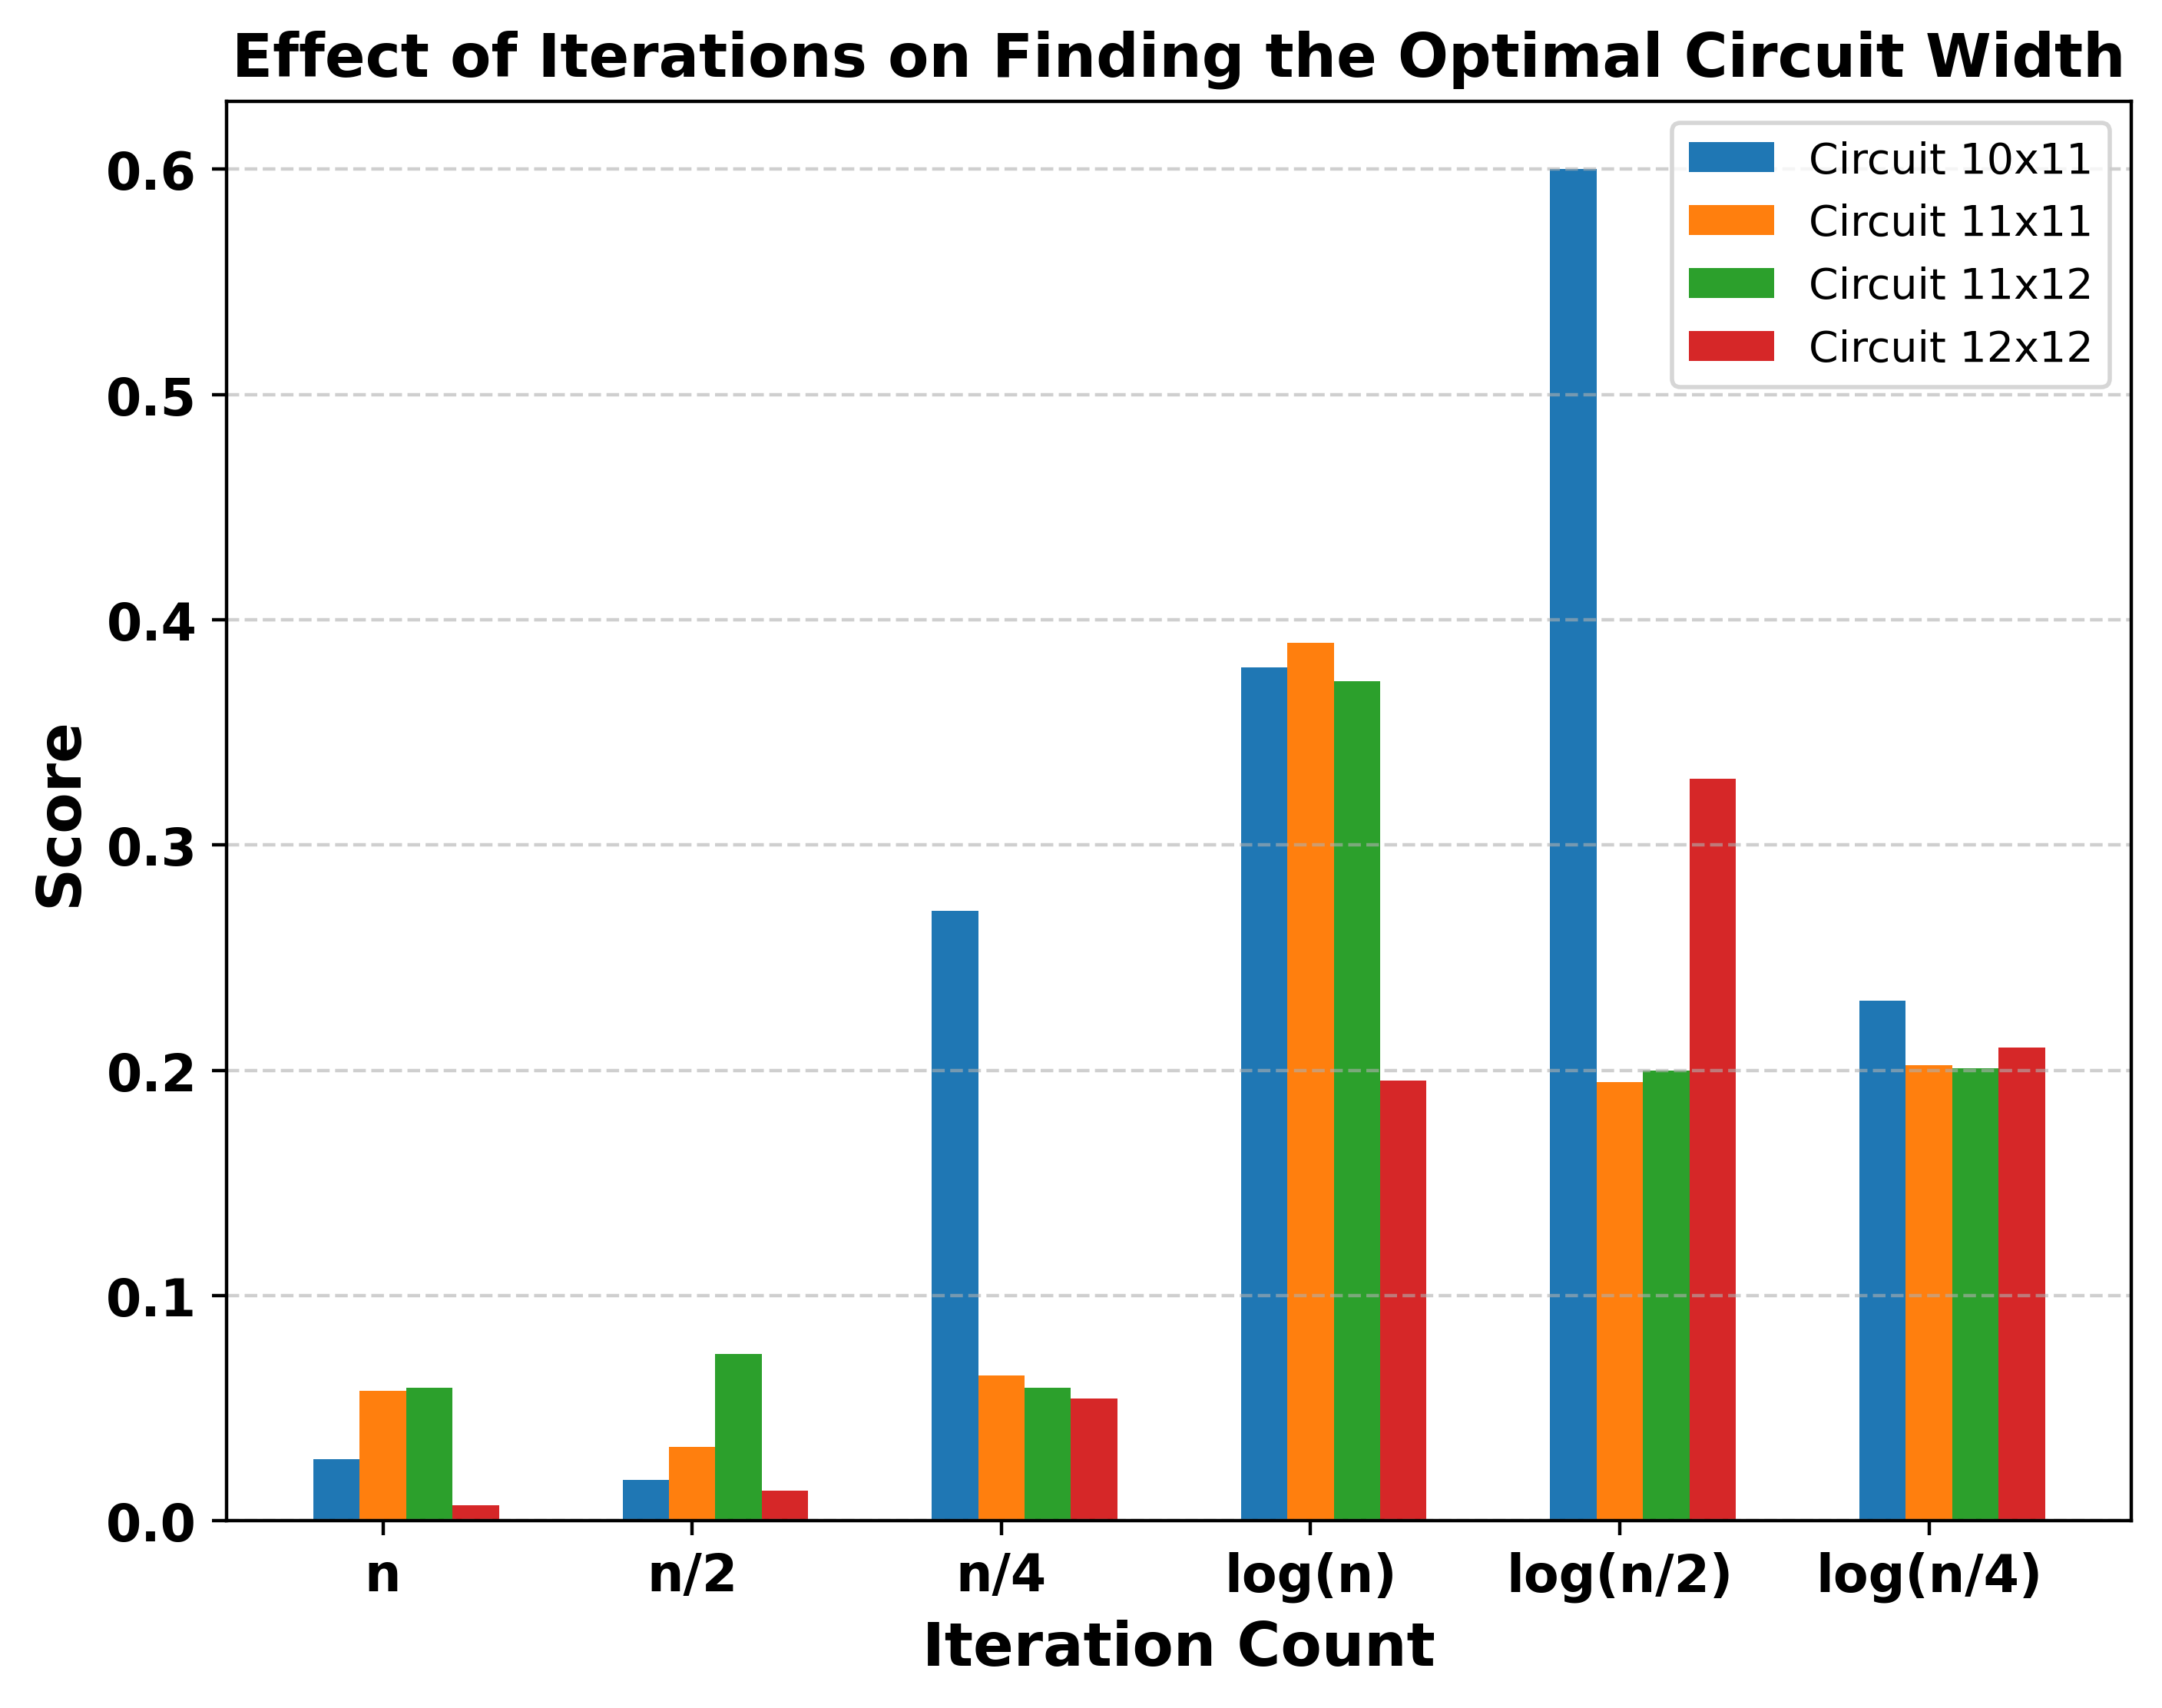

In [4]:
#!/usr/bin/env python3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from gidnet.qubitreuse import GidNET
from gidnet.utils import safe_eval, find_minimum_width_sets, iteration_score, create_qiskit_and_qnet_GRCS_circuits
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Set the experiment parameters
circuit_sizes = ["10x11", "11x11", "11x12", "12x12"]  # Circuit sizes
cycle_num = 13  # Depth of circuits

# Get the current working directory (repo root if running from the repo)
repo_path = Path.cwd()

# Define the data directory path
directory_path = repo_path / "data" / "GRSC"
# directory_path = Path("data/GRCS")  # Data directory

# Define iteration settings
iteration_labels = ["n", "n/2", "n/4", "log(n)", "log(n/2)", "log(n/4)"]

# # Scoring function for Number of iterations
# def iteration_score(elements):
#     """
#     Compute scores for different iteration settings.

#     Parameters:
#     - elements (list of tuples): Each tuple contains (min width found, probability of finding it)

#     Returns:
#     - scores (list): Computed scores for each setting.
#     """
#     widths = [ele[0] for ele in elements]
#     min_width = min(widths)
#     scores = [prob * (min_width / width) for width, prob in elements]
#     return scores

# Initialize results
gidnet_iteration_scores = []

# Run experiments
for circuit_size in circuit_sizes:
    logging.info(f"Processing Circuit: {circuit_size}")
    
    n = safe_eval(circuit_size)  # Convert "10x11" → numeric size
    iteration_counts = [n, n/2, n/4, np.log(n), np.log(n/2), np.log(n/4)]
    gidnet_results = []

    # Load circuit
    qiskit_circuit, _ = create_qiskit_and_qnet_GRCS_circuits(circuit_size, cycle_num, directory_path)

    for iter_count in iteration_counts:
        iter_count = int(np.ceil(iter_count))  # Round up to an integer
        gidnet = GidNET(qiskit_circuit)

        # Run GidNET multiple times to determine min width found
        # min_widths = []
        gidnet.compile_to_dynamic_circuit(iter_count)
        # min_widths.append(gidnet.dynamic_circuit_width)
        list_of_computed_reuse_sequences = gidnet.list_of_computed_reuse_sequences
        reuse_sequences_with_min_width = find_minimum_width_sets(list_of_computed_reuse_sequences)
        # min_width, prob = len(reuse_sequences_with_min_width[0]), len(reuse_sequences_with_min_width)/iter_count

        # Compute probability of finding the min width
        min_width = len(reuse_sequences_with_min_width[0])
        probability = len(reuse_sequences_with_min_width)/iter_count

        # Store results
        gidnet_results.append((min_width, probability))

    # Compute scores
    scores = iteration_score(gidnet_results)
    gidnet_iteration_scores.append(scores)

# Convert results into DataFrame
df_scores = pd.DataFrame(gidnet_iteration_scores, columns=iteration_labels, index=circuit_sizes)

# Save results to CSV
output_path = Path("Optimal_iterations")
output_path.mkdir(parents=True, exist_ok=True)
df_scores.to_csv(output_path / "gidnet_iteration_analysis.csv", index=True)
logging.info("Iteration analysis completed and saved.")

# Plot results
plt.figure(figsize=(8, 6), dpi=400)
x = np.arange(len(iteration_labels))  # X-axis positions

for i, (circuit_size, scores) in enumerate(df_scores.iterrows()):
    plt.bar(x + i * 0.15, scores, width=0.15, label=f"Circuit {circuit_size}")

# Formatting
plt.xlabel("Iteration Count", fontsize=14, fontweight="bold")
# plt.ylabel("Score = Probability × (Min Width / Length Min Circuit)", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=14, fontweight="bold")
plt.xticks(x + 0.15, iteration_labels, fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
plt.title("Effect of Iterations on Finding the Optimal Circuit Width", fontsize=14, fontweight="bold")
plt.legend(fontsize=10, loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Save plot
plt.savefig(output_path / "gidnet_iteration_vs_optimal_width_score.pdf", format="pdf", bbox_inches="tight")
plt.show()


/tmp/ipykernel_678806/980606998.py:67: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(x, y_gidnet, yerr=yerr_gidnet, label='GidNET Experimental', marker='o', color="green", fmt='-o', capsize=5)
/tmp/ipykernel_678806/980606998.py:69: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-^" (-> marker='^'). The keyword argument will take precedence.
  plt.errorbar(x, y_qnet, yerr=yerr_qnet, label='QNET Experimental', marker='^', color="blue", fmt='-^', capsize=5)
/tmp/ipykernel_678806/980606998.py:73: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-x" (-> marker='x'). The keyword argument will take precedence.
  plt.errorbar(x, data['Qiskit Mean Runtime'], yerr=data['Qiskit Stdev Runtime'], label='Qiskit Experimental', marker='x', color="red", fmt='-x', capsize=5)


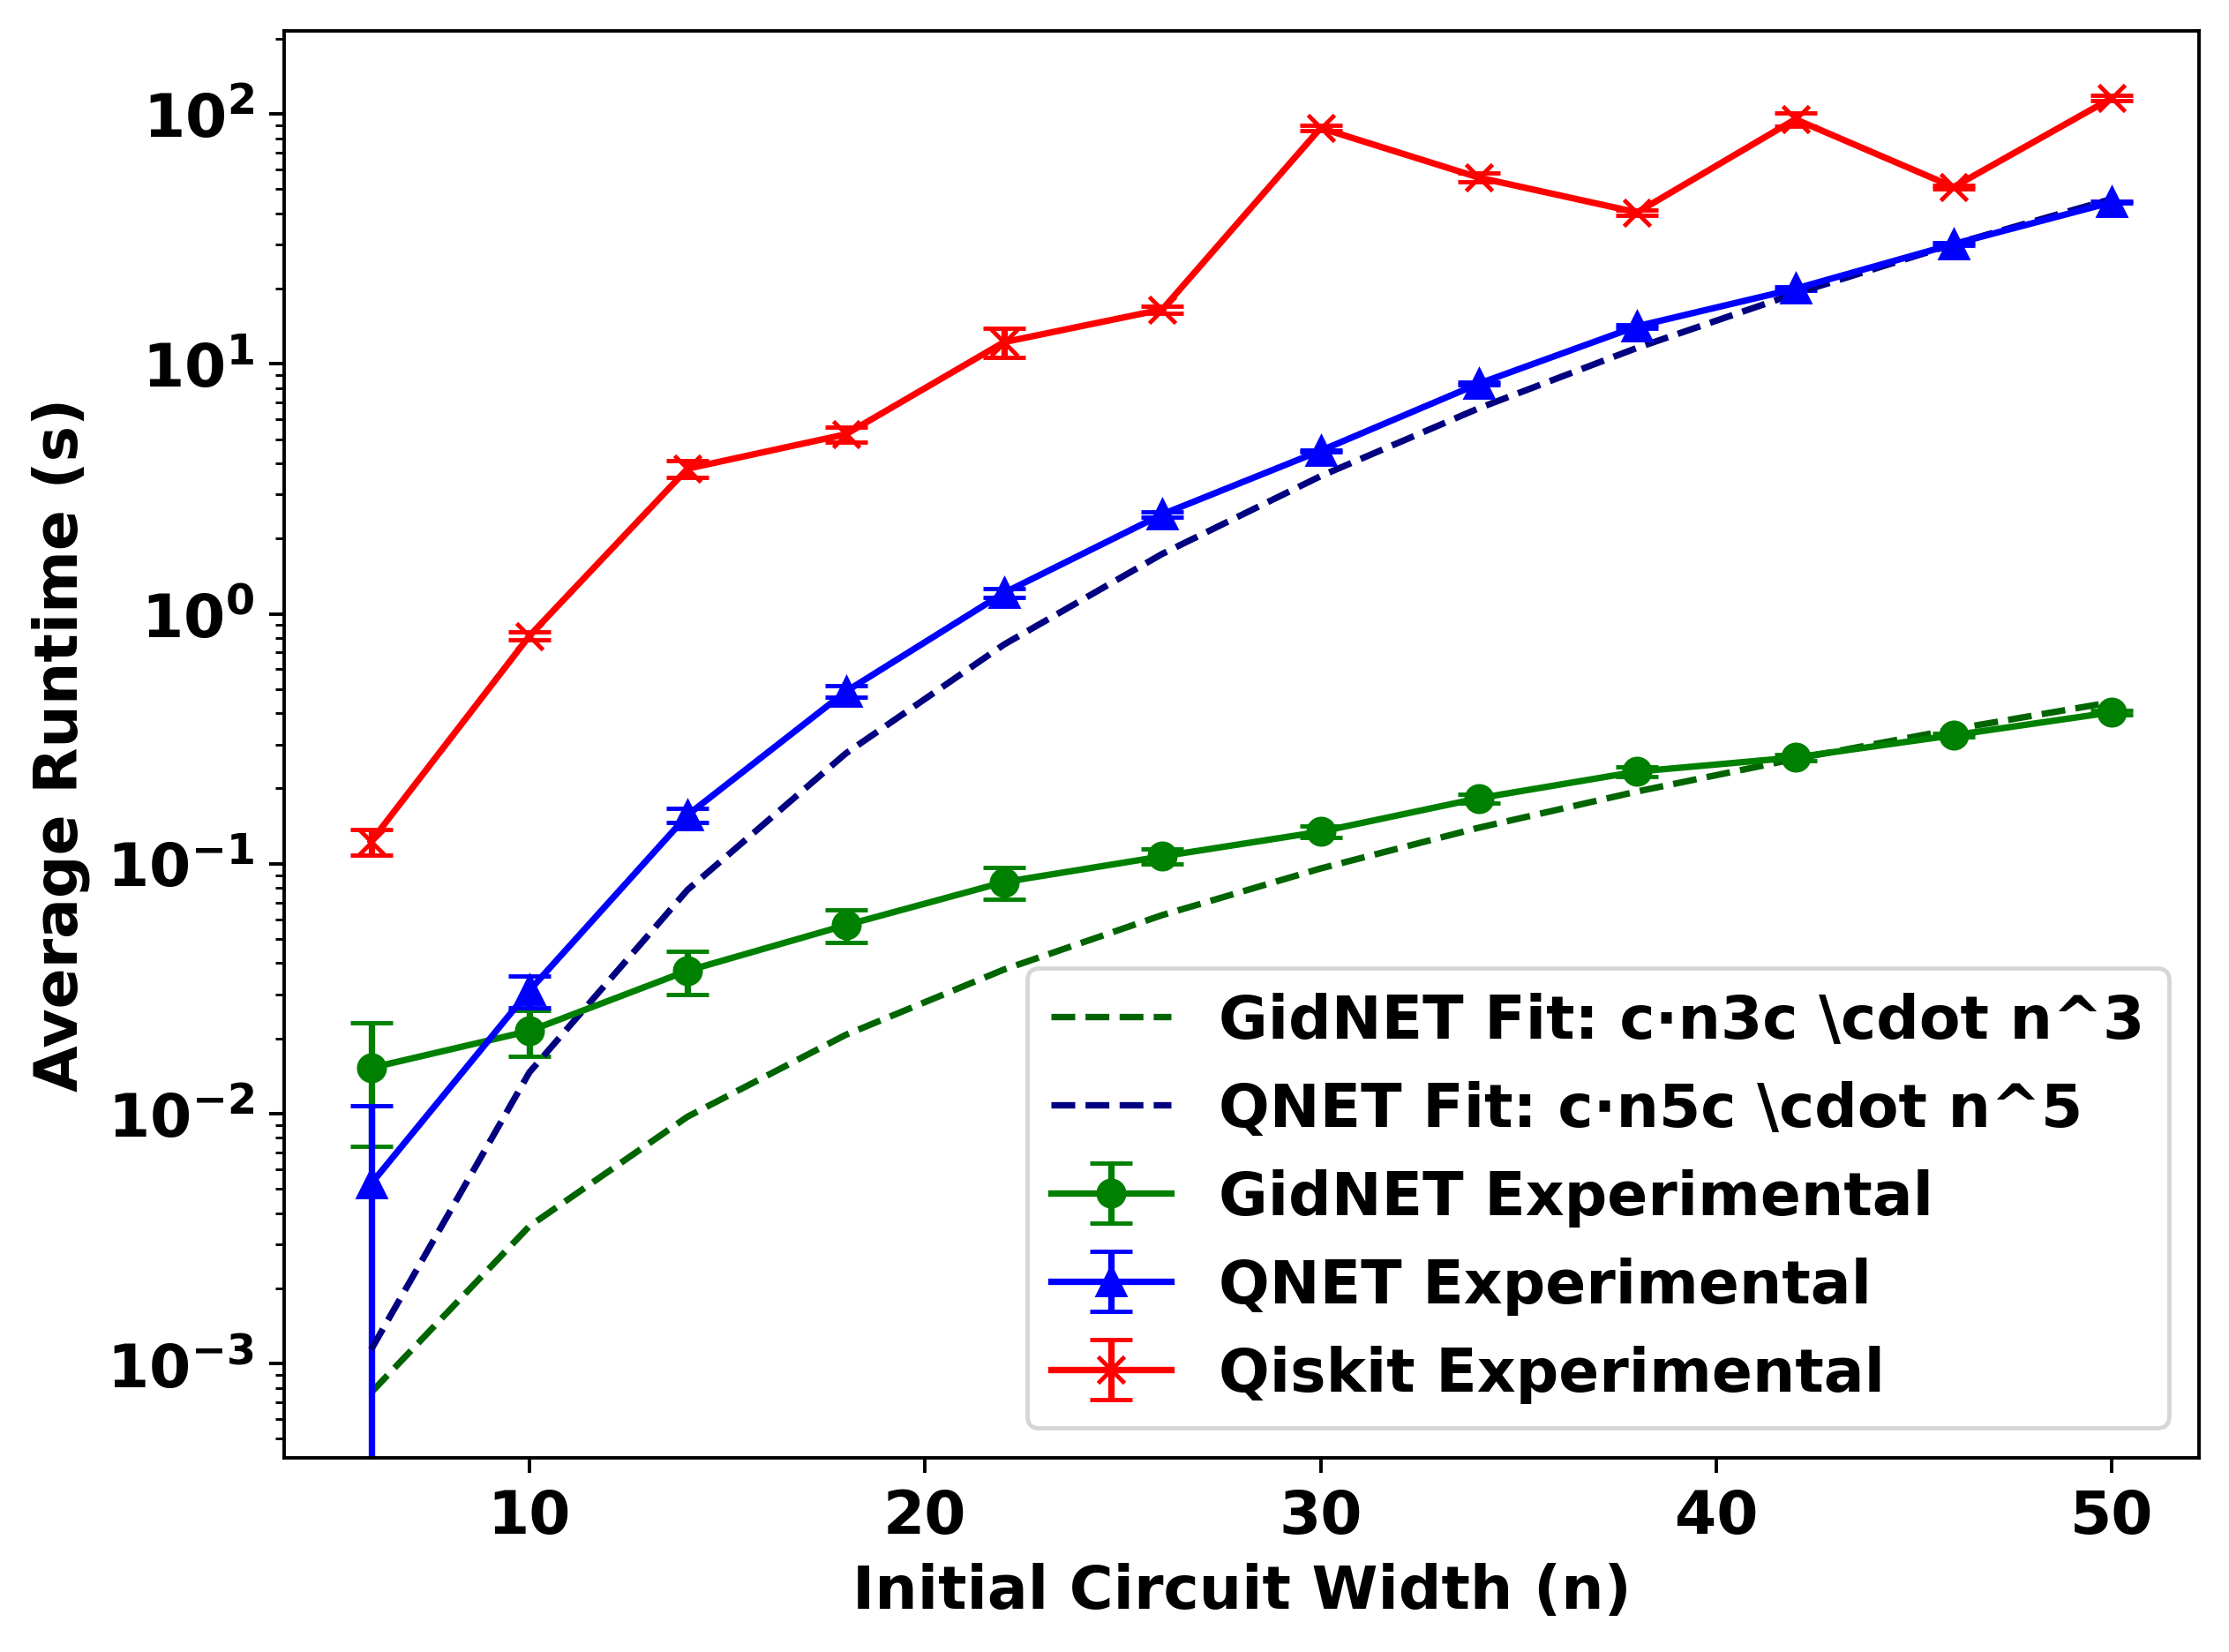

/tmp/ipykernel_678806/980606998.py:67: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(x, y_gidnet, yerr=yerr_gidnet, label='GidNET Experimental', marker='o', color="green", fmt='-o', capsize=5)
/tmp/ipykernel_678806/980606998.py:69: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-^" (-> marker='^'). The keyword argument will take precedence.
  plt.errorbar(x, y_qnet, yerr=yerr_qnet, label='QNET Experimental', marker='^', color="blue", fmt='-^', capsize=5)


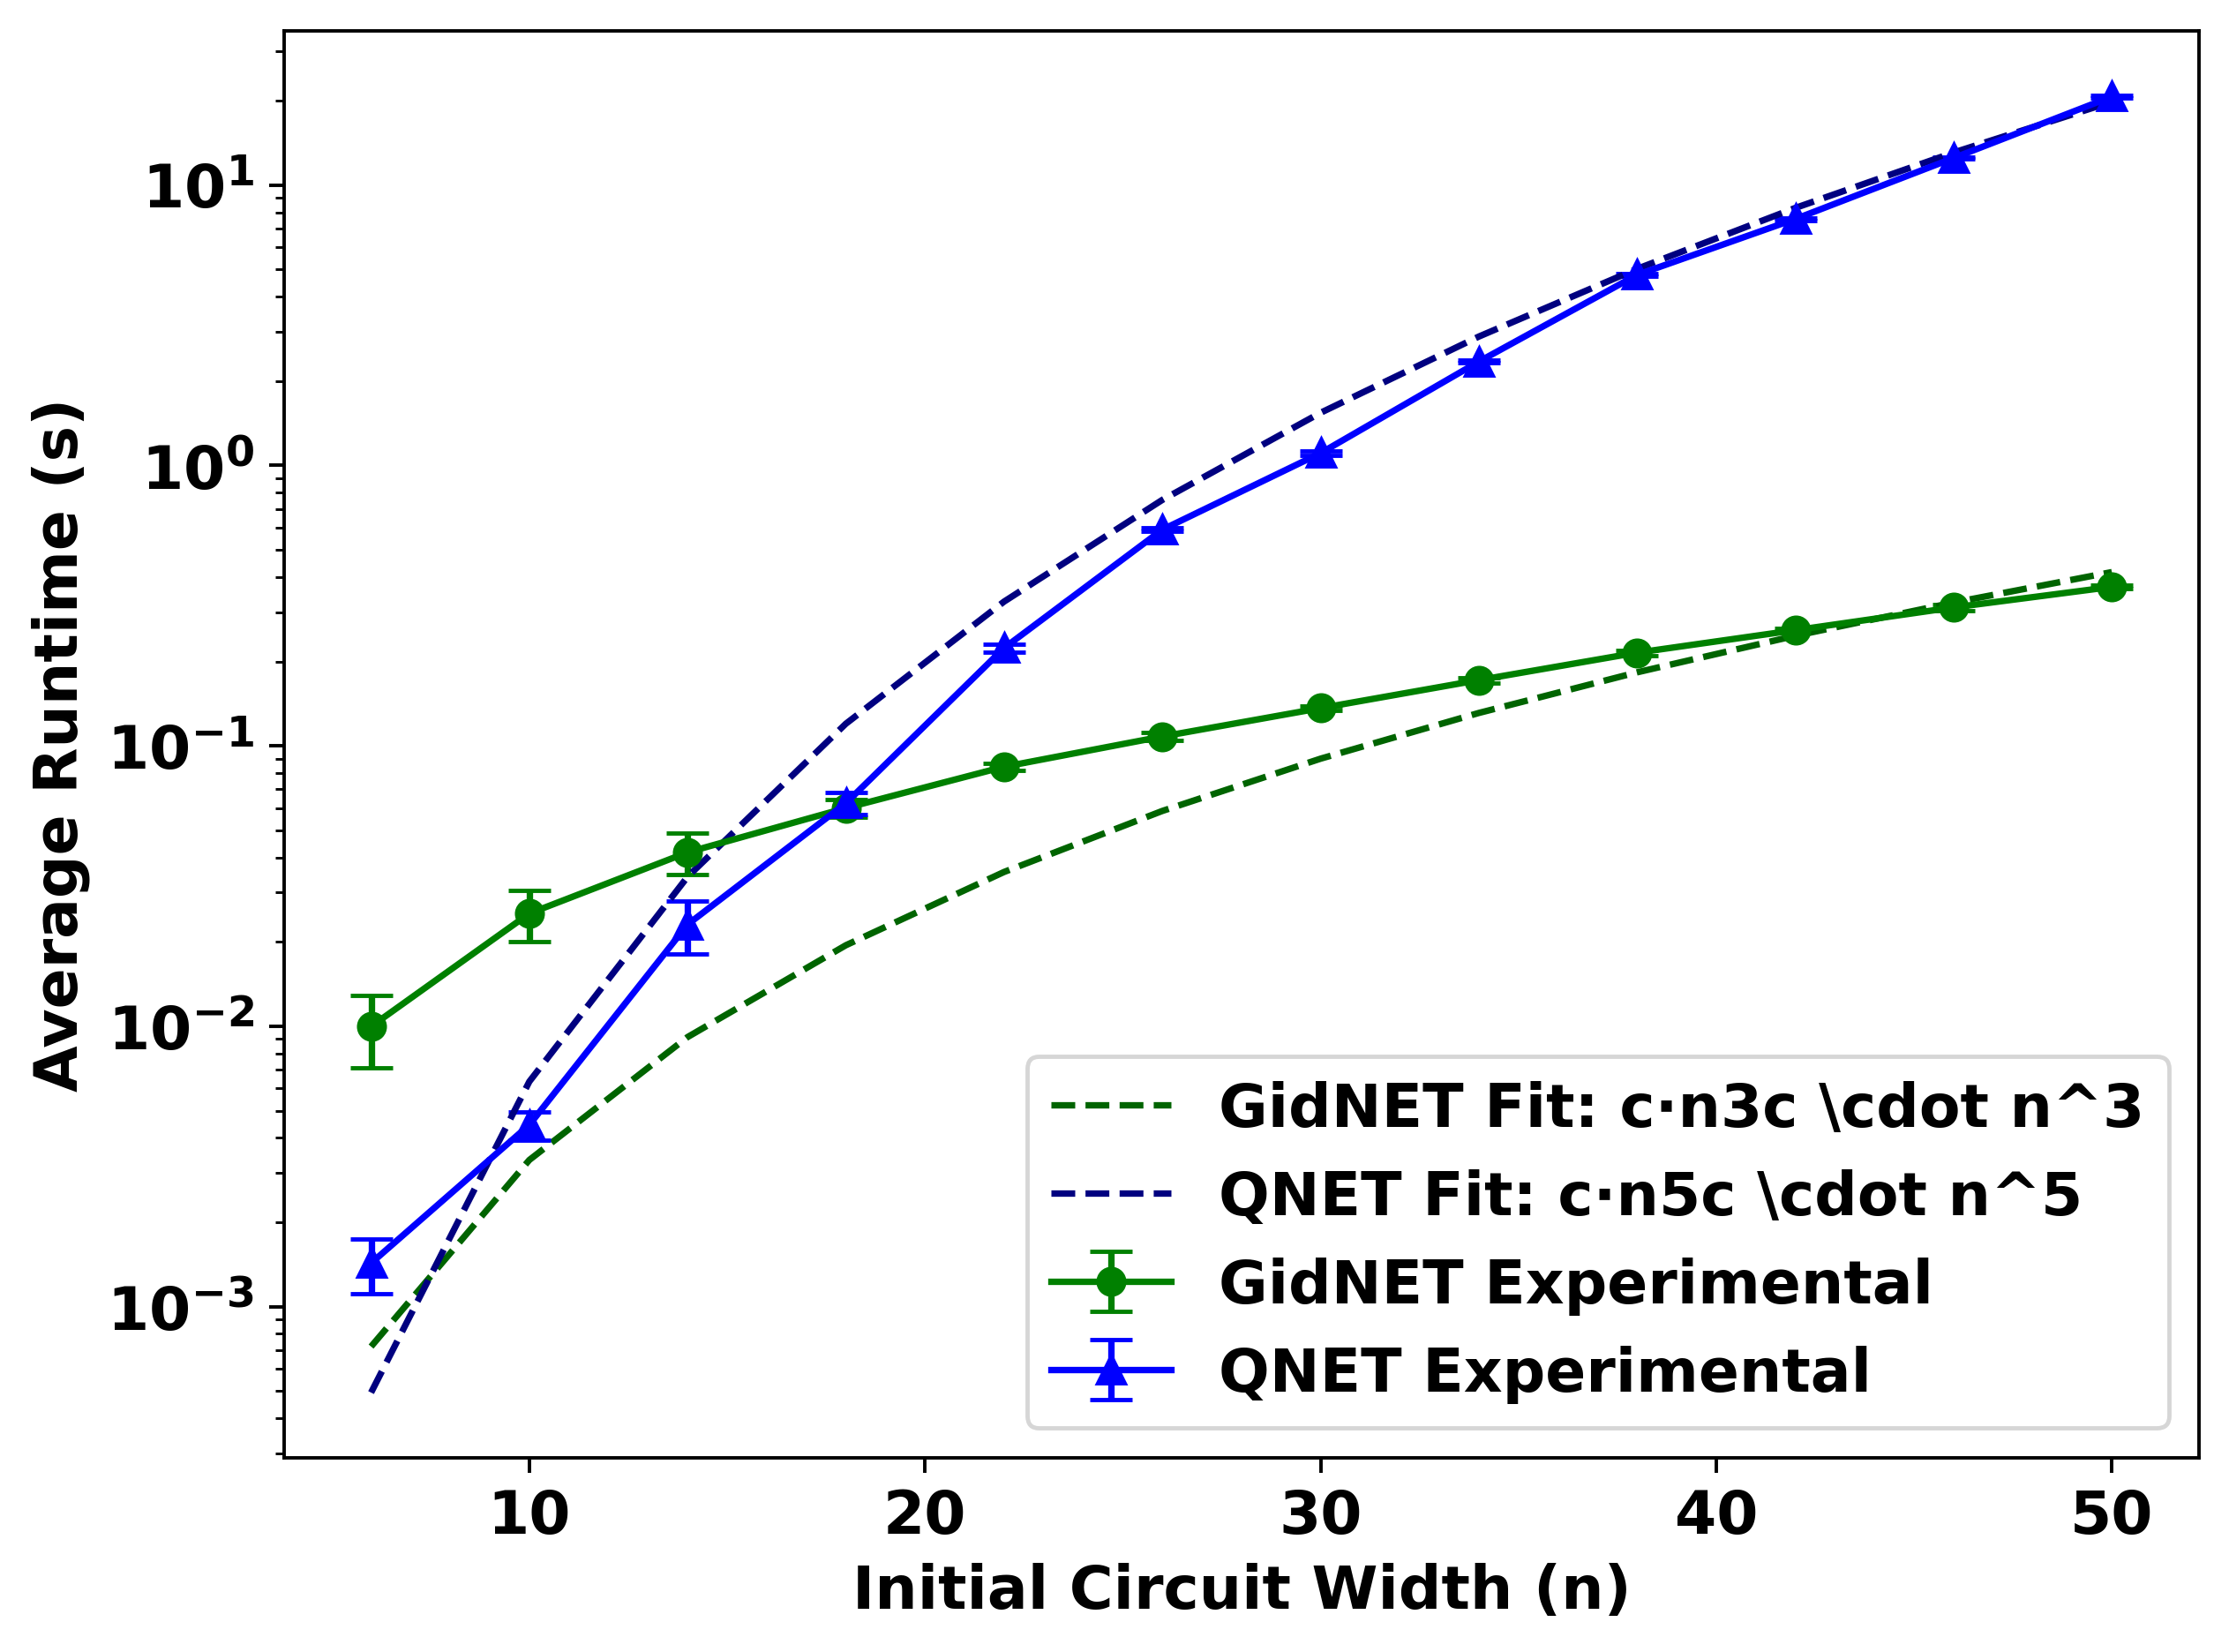

In [2]:
#!/usr/bin/env python3

import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pathlib import Path
from matplotlib.lines import Line2D

# Define polynomial model functions for fitting
def model_gidnet(n, c):
    return c * n**3

def model_qnet(n, c):
    return c * n**5

def process_qaoa_data(data_path: Path, layer: int):
    """
    Processes the QAOA experimental data for a given layer and extracts meaningful statistics.
    
    Args:
        data_path (Path): Path to the directory containing the experiment results.
        layer (int): The QAOA layer to process.
    
    Returns:
        pd.DataFrame: Processed DataFrame with mean, standard deviation, and min/max values.
    """
    df = pd.read_csv(data_path / f"width_and_runtime_QAOA_cct_P_{layer}.csv")
    
    processed_data = {
        'Circuit Size': df['Circuit Size'],
        'GidNET Mean Runtime': [np.mean(ast.literal_eval(time_list)) for time_list in df['GidNET Mean Runtime']],
        'GidNET Stdev Runtime': [np.std(ast.literal_eval(time_list)) for time_list in df['GidNET Stdev Runtime']],
        'GidNET Min Width': [np.min(ast.literal_eval(width_list)) for width_list in df['GidNET Min Width']],
        'QNET Mean Runtime': [np.mean(ast.literal_eval(time_list)) for time_list in df['QNET Mean Runtime']],
        'QNET Stdev Runtime': [np.std(ast.literal_eval(time_list)) for time_list in df['QNET Stdev Runtime']],
        'QNET Min Width': [np.min(ast.literal_eval(width_list)) for width_list in df['QNET Min Width']],
    }
    
    if 'Qiskit Mean Runtime' in df.columns:
        processed_data['Qiskit Mean Runtime'] = [np.mean(ast.literal_eval(time_list)) for time_list in df['Qiskit Mean Runtime']]
        processed_data['Qiskit Stdev Runtime'] = [np.std(ast.literal_eval(time_list)) for time_list in df['Qiskit Stdev Runtime']]
        processed_data['Qiskit Min Width'] = [np.min(ast.literal_eval(width_list)) for width_list in df['Qiskit Min Width']]
    
    processed_df = pd.DataFrame(processed_data)
    processed_df.to_csv(data_path / f"processed_QAOA_P_{layer}.csv", index=False)
    return processed_df

def plot_qaoa_runtime(data: pd.DataFrame, layer: int, output_path: Path):
    """
    Generates runtime comparison plots for QAOA experiments.
    
    Args:
        data (pd.DataFrame): Processed DataFrame containing experiment results.
        layer (int): The QAOA layer being plotted.
        output_path (Path): Path to save the plot.
    """
    x = data['Circuit Size'].astype(float)
    y_gidnet, yerr_gidnet = data['GidNET Mean Runtime'], data['GidNET Stdev Runtime']
    y_qnet, yerr_qnet = data['QNET Mean Runtime'], data['QNET Stdev Runtime']
    
    popt_gidnet, _ = curve_fit(model_gidnet, x, y_gidnet)
    popt_qnet, _ = curve_fit(model_qnet, x, y_qnet)
    
    plt.figure(figsize=(8, 6), dpi=350)
    plt.errorbar(x, y_gidnet, yerr=yerr_gidnet, label='GidNET Experimental', marker='o', color="green", fmt='-o', capsize=5)
    plt.plot(x, model_gidnet(x, *popt_gidnet), label=r'GidNET Fit: c⋅n3c \cdot n^3', color="darkgreen", linestyle='--')
    plt.errorbar(x, y_qnet, yerr=yerr_qnet, label='QNET Experimental', marker='^', color="blue", fmt='-^', capsize=5)
    plt.plot(x, model_qnet(x, *popt_qnet), label=r'QNET Fit: c⋅n5c \cdot n^5', color="navy", linestyle='--')
    
    if 'Qiskit Mean Runtime' in data.columns:
        plt.errorbar(x, data['Qiskit Mean Runtime'], yerr=data['Qiskit Stdev Runtime'], label='Qiskit Experimental', marker='x', color="red", fmt='-x', capsize=5)
    
    plt.xlabel('Initial Circuit Width (n)', fontsize=14, fontweight='bold')
    plt.ylabel('Average Runtime (s)', fontsize=14, fontweight='bold')
    plt.xticks(fontweight='bold', fontsize=14)
    plt.yticks(fontweight='bold', fontsize=14)
    plt.yscale('log')
    plt.legend(prop={'size': 14, 'weight': 'bold'})
    
    output_file = output_path / f'QAOA_P_{layer}_runtime_analysis.pdf'
    plt.savefig(output_file, format='pdf', bbox_inches='tight')
    plt.show()
    
# if __name__ == "__main__":
data_path = Path("QAOA_result")
output_path = Path("plots_qaoa")
output_path.mkdir(parents=True, exist_ok=True)

experiment_layers = [1, 2]
for layer in experiment_layers:
    df = process_qaoa_data(data_path, layer)
    plot_qaoa_runtime(df, layer, output_path)


In [3]:
#!/usr/bin/env python3

import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pathlib import Path
from matplotlib.lines import Line2D

# Define paths
data_path = Path("QAOA_result")  # Folder containing experiment results
plot_path = Path("plots_qaoa_cct")  # Folder to save plots
plot_path.mkdir(parents=True, exist_ok=True)

# Define the layers used in the experiment
experiment_layers = [1, 2]  # Modify this list if more layers are added

# Function to process raw experiment results
def process_experiment_data(layer: int) -> pd.DataFrame:
    """
    Processes the raw QAOA experiment data for a given layer.

    Args:
        layer (int): The QAOA layer number.

    Returns:
        pd.DataFrame: Processed dataframe containing mean, std, min, max values.
    """
    file_name = f"width_and_runtime_QAOA_cct_P_{layer}.csv"
    file_path = data_path / file_name

    if not file_path.exists():
        print(f"Warning: Data file for layer {layer} not found: {file_name}")
        return None

    df_raw = pd.read_csv(file_path)

    # Convert lists stored as strings into actual lists
    df_processed = pd.DataFrame({
        "Circuit Sizes": df_raw["Circuit Size"],
        "GidNET Mean Runtime": df_raw["GidNET Mean Runtime"].apply(ast.literal_eval).apply(np.mean),
        "GidNET Stdev Runtime": df_raw["GidNET Stdev Runtime"].apply(ast.literal_eval).apply(np.std),
        "GidNET Width": df_raw["GidNET Min Width"].apply(ast.literal_eval),
        "QNET Mean Runtime": df_raw["QNET Mean Runtime"].apply(ast.literal_eval).apply(np.mean),
        "QNET Stdev Runtime": df_raw["QNET Stdev Runtime"].apply(ast.literal_eval).apply(np.std),
        "QNET Width": df_raw["QNET Min Width"].apply(ast.literal_eval),
    })

    # Process Qiskit data only if it exists (for P=1)
    if "Qiskit Mean Runtime" in df_raw.columns:
        df_processed["Qiskit Mean Runtime"] = df_raw["Qiskit Mean Runtime"].apply(ast.literal_eval).apply(np.mean)
        df_processed["Qiskit Stdev Runtime"] = df_raw["Qiskit Stdev Runtime"].apply(ast.literal_eval).apply(np.std)
        df_processed["Qiskit Width"] = df_raw["Qiskit Min Width"].apply(ast.literal_eval)

    # Save the processed data
    processed_file = plot_path / f"processed_QAOA_results_P_{layer}.csv"
    df_processed.to_csv(processed_file, index=False)
    print(f"Processed data for P={layer} saved to {processed_file}")

    return df_processed


# Define polynomial model functions for runtime fitting
def model_gidnet(n, c):
    return c * n**3

def model_qnet(n, c):
    return c * n**5


# Plot runtime comparisons for different layers
def plot_runtime_analysis(df: pd.DataFrame, layer: int):
    """
    Plots runtime comparison for GidNET, QNET, and Qiskit (if available).

    Args:
        df (pd.DataFrame): Processed DataFrame.
        layer (int): QAOA layer.
    """
    plt.figure(figsize=(8, 6), dpi=350)

    # Fit the runtime data
    x = df["Circuit Sizes"].values.astype(float)
    y_gidnet = df["GidNET Mean Runtime"].values.astype(float)
    yerr_gidnet = df["GidNET Stdev Runtime"].values.astype(float)
    y_qnet = df["QNET Mean Runtime"].values.astype(float)
    yerr_qnet = df["QNET Stdev Runtime"].values.astype(float)

    popt_gidnet, _ = curve_fit(model_gidnet, x, y_gidnet)
    popt_qnet, _ = curve_fit(model_qnet, x, y_qnet)

    # Plot error bars and fitted models
    plt.errorbar(x, y_gidnet, yerr=yerr_gidnet, label="GidNET Experimental", marker="o", color="green", fmt="-o", capsize=5)
    plt.plot(x, model_gidnet(x, *popt_gidnet), label=r'GidNET Fit: c⋅n3\mathbf{c \cdot n^3}', color="darkgreen", linestyle="--")

    plt.errorbar(x, y_qnet, yerr=yerr_qnet, label="QNET Experimental", marker="^", color="blue", fmt="-^", capsize=5)
    plt.plot(x, model_qnet(x, *popt_qnet), label=r'QNET Fit: c⋅n5\mathbf{c \cdot n^5}', color="navy", linestyle="--")

    # Qiskit data (only for P=1)
    if "Qiskit Mean Runtime" in df.columns:
        plt.errorbar(df["Circuit Sizes"], df["Qiskit Mean Runtime"], yerr=df["Qiskit Stdev Runtime"], label="Qiskit Experimental", marker="x", color="red", fmt="-x", capsize=5)

    plt.xlabel("Initial Circuit Width (n)", fontsize=14, fontweight="bold")
    plt.ylabel("Average Runtime (s)", fontsize=14, fontweight="bold")
    plt.xticks(fontweight="bold", fontsize=14)
    plt.yticks(fontweight="bold", fontsize=14)
    plt.legend(prop={"size": 14, "weight": "bold"})
    plt.yscale("log")

    output_file = plot_path / f"QAOA_runtime_analysis_P_{layer}.pdf"
    plt.savefig(output_file, format="pdf", bbox_inches="tight")
    plt.show()
    print(f"Saved runtime analysis plot: {output_file}")


# Plot width boxplots (Corrected per your example)
def plot_width_boxplots(df: pd.DataFrame, layer: int):
    """
    Generates a boxplot for the final circuit widths of GidNET, QNET, and Qiskit (if available).

    Args:
        df (pd.DataFrame): Processed DataFrame.
        layer (int): QAOA layer.
    """
    # Convert width columns to lists
    df["GidNET Width"] = df["GidNET Width"].apply(ast.literal_eval)
    df["QNET Width"] = df["QNET Width"].apply(ast.literal_eval)

    if "Qiskit Width" in df.columns:
        df["Qiskit Width"] = df["Qiskit Width"].apply(ast.literal_eval)

    circuit_sizes_sorted = sorted(df["Circuit Sizes"].unique())

    # Prepare data for boxplot
    gidnet_widths = [df["GidNET Width"].iloc[i] for i in range(len(df))]
    qnet_widths = [df["QNET Width"].iloc[i] for i in range(len(df))]
    qiskit_widths = [df["Qiskit Width"].iloc[i] for i in range(len(df))] if "Qiskit Width" in df.columns else None

    fig, ax = plt.subplots(figsize=(8, 6), dpi=400)

    positions_gidnet = [x - 0.2 for x in range(len(circuit_sizes_sorted))]
    positions_qnet = [x for x in range(len(circuit_sizes_sorted))]
    positions_qiskit = [x + 0.2 for x in range(len(circuit_sizes_sorted))] if qiskit_widths else None

    box_gidnet = ax.boxplot(gidnet_widths, positions=positions_gidnet, widths=0.2, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
    box_qnet = ax.boxplot(qnet_widths, positions=positions_qnet, widths=0.2, patch_artist=True, boxprops=dict(facecolor="lightblue"))

    if qiskit_widths:
        box_qiskit = ax.boxplot(qiskit_widths, positions=positions_qiskit, widths=0.2, patch_artist=True, boxprops=dict(facecolor="salmon"))
        ax.legend([box_gidnet["boxes"][0], box_qnet["boxes"][0], box_qiskit["boxes"][0]], ["GidNET", "QNET", "Qiskit"], loc="upper left", prop={"weight": "bold"})

    ax.set_xlabel("Initial Circuit Width", fontsize=14, fontweight="bold")
    ax.set_ylabel("Final Circuit Width", fontsize=14, fontweight="bold")
    plt.xticks(fontweight="bold", fontsize=14)
    plt.yticks(fontweight="bold", fontsize=14)

    output_file = plot_path / f"QAOA_width_boxplot_P_{layer}.pdf"
    plt.savefig(output_file, format="pdf", bbox_inches="tight")
    plt.show()
    print(f"Saved width boxplot: {output_file}")


# if __name__ == "__main__":
data_path = Path("QAOA_result")
output_path = Path("plots_qaoa")
output_path.mkdir(parents=True, exist_ok=True)

experiment_layers = [1, 2]
for layer in experiment_layers:
    df = process_qaoa_data(data_path, layer)
    plot_qaoa_runtime(df, layer, output_path)


In [8]:
#!/usr/bin/env python3

import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pathlib import Path
from matplotlib.lines import Line2D

# Define paths
data_path = Path("QAOA_result")  # Folder containing experiment results
# plot_path = Path("plots_qaoa_cct")  # Folder to save plots
plot_path = Path("QAOA_result / plots_qaoa_cct")
plot_path.mkdir(parents=True, exist_ok=True)

# Define the layers used in the experiment
experiment_layers = [1, 2]  # Modify this list if more layers are added


def process_experiment_data(layer: int) -> pd.DataFrame:
    """
    Processes the raw QAOA experiment data for a given layer.

    Args:
        layer (int): The QAOA layer number.

    Returns:
        pd.DataFrame: Processed dataframe containing mean, std, min, max values.
    """
    file_name = f"width_and_runtime_QAOA_cct_P_{layer}.csv"
    file_path = data_path / file_name

    if not file_path.exists():
        print(f"Warning: Data file for layer {layer} not found: {file_name}")
        return None

    df_raw = pd.read_csv(file_path)

    df_processed = pd.DataFrame({
        "Circuit Sizes": df_raw["Circuit Size"],
        "GidNET Mean Runtime": df_raw["GidNET Mean Runtime"].apply(ast.literal_eval).apply(np.mean),
        "GidNET Stdev Runtime": df_raw["GidNET Stdev Runtime"].apply(ast.literal_eval).apply(np.std),
        "GidNET Width": df_raw["GidNET Min Width"].apply(ast.literal_eval),
        "QNET Mean Runtime": df_raw["QNET Mean Runtime"].apply(ast.literal_eval).apply(np.mean),
        "QNET Stdev Runtime": df_raw["QNET Stdev Runtime"].apply(ast.literal_eval).apply(np.std),
        "QNET Width": df_raw["QNET Min Width"].apply(ast.literal_eval),
    })

    # Process Qiskit data only if it exists (for P=1)
    if "Qiskit Mean Runtime" in df_raw.columns:
        df_processed["Qiskit Mean Runtime"] = df_raw["Qiskit Mean Runtime"].apply(ast.literal_eval).apply(np.mean)
        df_processed["Qiskit Stdev Runtime"] = df_raw["Qiskit Stdev Runtime"].apply(ast.literal_eval).apply(np.std)
        df_processed["Qiskit Width"] = df_raw["Qiskit Min Width"].apply(ast.literal_eval)

    # Save the processed data
    processed_file = plot_path / f"processed_QAOA_results_P_{layer}.csv"
    df_processed.to_csv(processed_file, index=False)
    print(f"Processed data for P={layer} saved to {processed_file}")

    return df_processed


# Define polynomial model functions for runtime fitting
def model_gidnet(n, c):
    return c * n**3

def model_qnet(n, c):
    return c * n**5


def plot_runtime_analysis(df: pd.DataFrame, layer: int):
    """
    Plots runtime comparison for GidNET, QNET, and Qiskit (if available).

    Args:
        df (pd.DataFrame): Processed DataFrame.
        layer (int): QAOA layer.
    """
    plt.figure(figsize=(8, 6), dpi=350)

    # Fit the runtime data
    x = df["Circuit Sizes"].values.astype(float)
    y_gidnet = df["GidNET Mean Runtime"].values.astype(float)
    yerr_gidnet = df["GidNET Stdev Runtime"].values.astype(float)
    y_qnet = df["QNET Mean Runtime"].values.astype(float)
    yerr_qnet = df["QNET Stdev Runtime"].values.astype(float)

    popt_gidnet, _ = curve_fit(model_gidnet, x, y_gidnet)
    popt_qnet, _ = curve_fit(model_qnet, x, y_qnet)

    # Plot error bars and fitted models
    plt.errorbar(x, y_gidnet, yerr=yerr_gidnet, label="GidNET Experimental", marker="o", color="green", fmt="-o", capsize=5)
    plt.plot(x, model_gidnet(x, *popt_gidnet), label=r'GidNET Fit: c⋅n3\mathbf{c \cdot n^3}', color="darkgreen", linestyle="--")

    plt.errorbar(x, y_qnet, yerr=yerr_qnet, label="QNET Experimental", marker="^", color="blue", fmt="-^", capsize=5)
    plt.plot(x, model_qnet(x, *popt_qnet), label=r'QNET Fit: c⋅n5\mathbf{c \cdot n^5}', color="navy", linestyle="--")

    if "Qiskit Mean Runtime" in df.columns:
        plt.errorbar(df["Circuit Sizes"], df["Qiskit Mean Runtime"], yerr=df["Qiskit Stdev Runtime"], label="Qiskit Experimental", marker="x", color="red", fmt="-x", capsize=5)

    plt.xlabel("Initial Circuit Width (n)", fontsize=14, fontweight="bold")
    plt.ylabel("Average Runtime (s)", fontsize=14, fontweight="bold")
    plt.xticks(fontweight="bold", fontsize=14)
    plt.yticks(fontweight="bold", fontsize=14)
    plt.legend(prop={"size": 14, "weight": "bold"})
    plt.yscale("log")

    output_file = plot_path / f"QAOA_runtime_analysis_P_{layer}.pdf"
    plt.savefig(output_file, format="pdf", bbox_inches="tight")
    plt.show()
    print(f"Saved runtime analysis plot: {output_file}")


def plot_width_boxplots(df: pd.DataFrame, layer: int):
    """
    Generates a boxplot for the final circuit widths of GidNET, QNET, and Qiskit (if available).

    Args:
        df (pd.DataFrame): Processed DataFrame.
        layer (int): QAOA layer.
    """
    # Convert string lists to actual lists if necessary
    if isinstance(df["GidNET Width"].iloc[0], str):
        df["GidNET Width"] = df["GidNET Width"].apply(ast.literal_eval)
    
    if isinstance(df["QNET Width"].iloc[0], str):
        df["QNET Width"] = df["QNET Width"].apply(ast.literal_eval)

    if "Qiskit Width" in df.columns and isinstance(df["Qiskit Width"].iloc[0], str):
        df["Qiskit Width"] = df["Qiskit Width"].apply(ast.literal_eval)

    # Sort circuit sizes for proper ordering in the plot
    circuit_sizes_sorted = sorted(df["Circuit Sizes"].unique())

    # Prepare data for boxplot
    gidnet_widths = [df["GidNET Width"].iloc[i] for i in range(len(df))]
    qnet_widths = [df["QNET Width"].iloc[i] for i in range(len(df))]
    qiskit_widths = [df["Qiskit Width"].iloc[i] for i in range(len(df))] if "Qiskit Width" in df.columns else None

    fig, ax = plt.subplots(figsize=(8, 6), dpi=400)

    positions_gidnet = [x - 0.2 for x in range(len(circuit_sizes_sorted))]
    positions_qnet = [x for x in range(len(circuit_sizes_sorted))]
    positions_qiskit = [x + 0.2 for x in range(len(circuit_sizes_sorted))] if qiskit_widths else None

    # Plot boxplots for each algorithm
    box_gidnet = ax.boxplot(gidnet_widths, positions=positions_gidnet, widths=0.2, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
    box_qnet = ax.boxplot(qnet_widths, positions=positions_qnet, widths=0.2, patch_artist=True, boxprops=dict(facecolor="lightblue"))

    if qiskit_widths:
        box_qiskit = ax.boxplot(qiskit_widths, positions=positions_qiskit, widths=0.2, patch_artist=True, boxprops=dict(facecolor="salmon"))
        ax.legend([box_gidnet["boxes"][0], box_qnet["boxes"][0], box_qiskit["boxes"][0]], ["GidNET", "QNET", "Qiskit"], loc="upper left", prop={"weight": "bold"})
    else:
        ax.legend([box_gidnet["boxes"][0], box_qnet["boxes"][0]], ["GidNET", "QNET"], loc="upper left", prop={"weight": "bold"})

    # Formatting
    ax.set_xlabel("Initial Circuit Width", fontsize=14, fontweight="bold")
    ax.set_ylabel("Final Circuit Width", fontsize=14, fontweight="bold")
    plt.xticks(range(len(circuit_sizes_sorted)), labels=circuit_sizes_sorted, fontweight="bold", fontsize=14)
    plt.yticks(fontweight="bold", fontsize=14)

    # Save the plot
    output_file = plot_path / f"QAOA_width_boxplot_P_{layer}.pdf"
    plt.savefig(output_file, format="pdf", bbox_inches="tight")
    plt.show()
    print(f"Saved width boxplot: {output_file}")



if __name__ == "__main__":
for layer in experiment_layers:
    df = process_experiment_data(layer)
    if df is not None:
        plot_runtime_analysis(df, layer)
        plot_width_boxplots(df, layer)


IndentationError: expected an indented block after 'if' statement on line 171 (604651214.py, line 172)

In [3]:
import numpy as np
import pandas as pd
import logging
import time
from pathlib import Path
from benchmarks.biadu_qnet_qubit_reuse.baidu_qnet_qr import (
    compute_qnet_qubit_reuse_list,
    from_qiskit_to_qnet,
    compute_qnet_qubit_reuse_list_timing
)
from gidnet.qubitreuse import GidNET
from gidnet.utils import safe_eval, apply_qiskit_qubit_reuse, create_qiskit_and_qnet_QAOA_circuits
from qiskit import QuantumCircuit

from typing import List, Union

def group_data_by_column(data: List[List[Union[int, float]]], columns: List[str]) -> pd.DataFrame:
    """
    Groups data by the first column and aggregates the remaining columns into lists.

    Parameters:
        data (List[List[Union[int, float]]]): 
            A nested list where each inner list represents a row of data.
        columns (List[str]): 
            A list of column names. The first column is used for grouping, and the others are aggregated.

    Returns:
        pd.DataFrame: A pandas DataFrame where the first column contains unique group keys, 
                      and the other columns contain aggregated lists.
                      
    Example:
        >>> data = [
                [[6, 0.01, 0.02, 4], [6, 0.02, 0.03, 4]],
                [[10, 0.05, 0.01, 6], [10, 0.04, 0.02, 5]]
            ]
        >>> columns = ["Circuit Size", "GidNET Mean Runtime", "GidNET Stdev Runtime", "GidNET Min Width"]
        >>> group_data_by_column(data, columns)
    """
    # Validate input
    if not data or not columns:
        raise ValueError("Data and columns must not be empty.")
    if len(columns) < 2:
        raise ValueError("At least two columns are required: one for grouping and one or more for aggregation.")

    # Initialize a dictionary to group data
    grouped_data = {}
    for dataset in data:
        for row in dataset:
            group_key = row[0]  # Use the first column for grouping
            if group_key not in grouped_data:
                grouped_data[group_key] = {col: [] for col in columns[1:]}
            for i, col in enumerate(columns[1:], start=1):
                grouped_data[group_key][col].append(row[i])
    
    # Convert the grouped data into a DataFrame
    grouped_df = pd.DataFrame(
        [
            {
                columns[0]: group_key,
                **aggregated_values,
            }
            for group_key, aggregated_values in grouped_data.items()
        ]
    )

    return grouped_df


circuit_sizes = [6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50]
circuit_sizes = [6, 10]

gidnet_results = []
qnet_results = []
qiskit_results = []



# Set the number of random graph for each qubit number
seed_num = 20 # this should be set to 20

# Set the number of the random greedy algorithm
iterations = 10

# Set the number of QAOA unitary layers
# layers = 1

experiment_layers = {1: [6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50],
                     2: [6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50]}

experiment_layers = {1: [6, 10],
                     2: [6, 10]}

# experiment_layers = {2: [6, 10]}

def run_qaoa_experiment(layers, circuit_sizes):
    for i, circuit_size in enumerate(circuit_sizes):
        print("circuit", i+1, "running")
        # create temporary data holders for intermediate results
        tmp_gidnet_results = []
        tmp_qnet_results = []
        tmp_qiskit_results = []
    
        circuits, _ = create_qiskit_and_qnet_QAOA_circuits(circuit_size, seed_num, layers)
    
        for circuit in circuits:
            # GidNET Experiment
            gidnet = GidNET(circuit)
            runtimes = []
            min_width = int(1e10)
            for _ in range(iterations):
                start_time = time.time()
                gidnet.compile_to_dynamic_circuit(iterations)
                runtimes.append(time.time() - start_time)
                min_width = min(min_width, gidnet.dynamic_circuit_width)
            tmp_gidnet_results.append([circuit_size, np.mean(runtimes), np.std(runtimes), min_width])
    
            # QNET Experiment
            qnet_circuit = from_qiskit_to_qnet(circuit)
            runtimes = []
            min_width = int(1e10)
            for _ in range(iterations):
                start_time = time.time()
                qnet_result = compute_qnet_qubit_reuse_list(qnet_circuit, method="random", shots=iterations)
                runtimes.append(time.time() - start_time)
                min_width = min(min_width, len(qnet_result))
            tmp_qnet_results.append([circuit_size, np.mean(runtimes), np.std(runtimes), min_width])
            
            # Qiskit Experiment
            if layers == 1: # don't run for greater layers to since it takes long to run
                runtimes = []
                min_width = int(1e10)
                for _ in range(iterations):
                    start_time = time.time()
                    compiled_qiskit_circuit = apply_qiskit_qubit_reuse(circuit)
                    runtimes.append(time.time() - start_time)
                    min_width = min(min_width, compiled_qiskit_circuit.num_qubits)
                tmp_qiskit_results.append([circuit_size, np.mean(runtimes), np.std(runtimes), min_width])
    
        
    
        # Data colation
        gidnet_results.append(tmp_gidnet_results)
        qnet_results.append(tmp_qnet_results)
        if layers == 1:
            qiskit_results.append(tmp_qiskit_results)
    
    df_gidnet = group_data_by_column(gidnet_results, columns=["Circuit Size", "GidNET Mean Runtime", "GidNET Stdev Runtime", "GidNET Min Width"])
    df_qnet = group_data_by_column(qnet_results, columns=["Circuit Size", "QNET Mean Runtime", "QNET Stdev Runtime", "QNET Min Width"])
    if layers == 1:
        df_qiskit = group_data_by_column(qiskit_results, columns=["Circuit Size", "Qiskit Mean Runtime", "Qiskit Stdev Runtime", "Qiskit Min Width"])
    
    df = pd.merge(df_gidnet, df_qnet, on="Circuit Size")
    if layers == 1:
        df = pd.merge(df, df_qiskit, on="Circuit Size")
    
    output_path = Path("QAOA_result")
    output_path.mkdir(parents=True, exist_ok=True)
    df.to_csv(output_path / f"width_and_runtime_QAOA_cct_P_{layers}.csv", index=False)
    logging.info(f"Experiment for P = {layers} completed and data saved.")

if __name__ == "__main__":
    for layers, sizes in experiment_layers.items():
        run_qaoa_experiment(layers, sizes)

circuit 1 running
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions di

2025-02-07 19:43:28,099 - INFO - Experiment for P = 1 completed and data saved.


circuit 1 running
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions di

2025-02-07 19:43:42,276 - INFO - Experiment for P = 2 completed and data saved.


ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1


In [8]:
#!/usr/bin/env python3

import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pathlib import Path
from matplotlib.lines import Line2D

# Define paths
data_path = Path("QAOA_result")  # Folder containing experiment results
plot_path = Path("plots_qaoa_cct")  # Folder to save plots
plot_path.mkdir(parents=True, exist_ok=True)

# Define the layers used in the experiment
experiment_layers = [1, 2]  # Modify this list if more layers are added

# Function to process raw experiment results
def process_experiment_data(layer: int) -> pd.DataFrame:
    """
    Processes the raw QAOA experiment data for a given layer.

    Args:
        layer (int): The QAOA layer number.

    Returns:
        pd.DataFrame: Processed dataframe containing mean, std, min, max values.
    """
    file_name = f"width_and_runtime_QAOA_cct_P_{layer}.csv"
    file_path = data_path / file_name

    if not file_path.exists():
        print(f"Warning: Data file for layer {layer} not found: {file_name}")
        return None

    df_raw = pd.read_csv(file_path)

    # Convert lists stored as strings into actual lists
    df_processed = pd.DataFrame({
        "Circuit Sizes": df_raw["Circuit Size"],
        "GidNET Mean Runtime": df_raw["GidNET Mean Runtime"].apply(ast.literal_eval).apply(np.mean),
        "GidNET Stdev Runtime": df_raw["GidNET Stdev Runtime"].apply(ast.literal_eval).apply(np.std),
        "GidNET Width": df_raw["GidNET Min Width"].apply(ast.literal_eval),
        "QNET Mean Runtime": df_raw["QNET Mean Runtime"].apply(ast.literal_eval).apply(np.mean),
        "QNET Stdev Runtime": df_raw["QNET Stdev Runtime"].apply(ast.literal_eval).apply(np.std),
        "QNET Width": df_raw["QNET Min Width"].apply(ast.literal_eval),
    })

    # Process Qiskit data only if it exists (for P=1)
    if "Qiskit Mean Runtime" in df_raw.columns:
        df_processed["Qiskit Mean Runtime"] = df_raw["Qiskit Mean Runtime"].apply(ast.literal_eval).apply(np.mean)
        df_processed["Qiskit Stdev Runtime"] = df_raw["Qiskit Stdev Runtime"].apply(ast.literal_eval).apply(np.std)
        df_processed["Qiskit Width"] = df_raw["Qiskit Min Width"].apply(ast.literal_eval)

    # Save the processed data
    processed_file = plot_path / f"processed_QAOA_results_P_{layer}.csv"
    df_processed.to_csv(processed_file, index=False)
    print(f"Processed data for P={layer} saved to {processed_file}")

    return df_processed


# Define polynomial model functions for runtime fitting
def model_gidnet(n, c):
    return c * n**3

def model_qnet(n, c):
    return c * n**5


# Plot runtime comparisons for different layers
def plot_runtime_analysis(df: pd.DataFrame, layer: int):
    """
    Plots runtime comparison for GidNET, QNET, and Qiskit (if available).

    Args:
        df (pd.DataFrame): Processed DataFrame.
        layer (int): QAOA layer.
    """
    plt.figure(figsize=(8, 6), dpi=350)

    # Fit the runtime data
    x = df["Circuit Sizes"].values.astype(float)
    y_gidnet = df["GidNET Mean Runtime"].values.astype(float)
    yerr_gidnet = df["GidNET Stdev Runtime"].values.astype(float)
    y_qnet = df["QNET Mean Runtime"].values.astype(float)
    yerr_qnet = df["QNET Stdev Runtime"].values.astype(float)

    popt_gidnet, _ = curve_fit(model_gidnet, x, y_gidnet)
    popt_qnet, _ = curve_fit(model_qnet, x, y_qnet)

    # Plot error bars and fitted models
    plt.errorbar(x, y_gidnet, yerr=yerr_gidnet, label="GidNET Experimental", marker="o", color="green", fmt="-o", capsize=5)
    plt.plot(x, model_gidnet(x, *popt_gidnet), label=r'GidNET Fit: c⋅n3\mathbf{c \cdot n^3}', color="darkgreen", linestyle="--")

    plt.errorbar(x, y_qnet, yerr=yerr_qnet, label="QNET Experimental", marker="^", color="blue", fmt="-^", capsize=5)
    plt.plot(x, model_qnet(x, *popt_qnet), label=r'QNET Fit: c⋅n5\mathbf{c \cdot n^5}', color="navy", linestyle="--")

    # Qiskit data (only for P=1)
    if "Qiskit Mean Runtime" in df.columns:
        plt.errorbar(df["Circuit Sizes"], df["Qiskit Mean Runtime"], yerr=df["Qiskit Stdev Runtime"], label="Qiskit Experimental", marker="x", color="red", fmt="-x", capsize=5)

    plt.xlabel("Initial Circuit Width (n)", fontsize=14, fontweight="bold")
    plt.ylabel("Average Runtime (s)", fontsize=14, fontweight="bold")
    plt.xticks(fontweight="bold", fontsize=14)
    plt.yticks(fontweight="bold", fontsize=14)
    plt.legend(prop={"size": 14, "weight": "bold"})
    plt.yscale("log")

    output_file = plot_path / f"QAOA_runtime_analysis_P_{layer}.pdf"
    plt.savefig(output_file, format="pdf", bbox_inches="tight")
    plt.show()
    print(f"Saved runtime analysis plot: {output_file}")


# Plot width boxplots (Corrected per your example)
def plot_width_boxplots(df: pd.DataFrame, layer: int):
    """
    Generates a boxplot for the final circuit widths of GidNET, QNET, and Qiskit (if available).

    Args:
        df (pd.DataFrame): Processed DataFrame.
        layer (int): QAOA layer.
    """
    # Convert width columns to lists
    df["GidNET Width"] = df["GidNET Width"].apply(ast.literal_eval)
    df["QNET Width"] = df["QNET Width"].apply(ast.literal_eval)

    if "Qiskit Width" in df.columns:
        df["Qiskit Width"] = df["Qiskit Width"].apply(ast.literal_eval)

    circuit_sizes_sorted = sorted(df["Circuit Sizes"].unique())

    # Prepare data for boxplot
    gidnet_widths = [df["GidNET Width"].iloc[i] for i in range(len(df))]
    qnet_widths = [df["QNET Width"].iloc[i] for i in range(len(df))]
    qiskit_widths = [df["Qiskit Width"].iloc[i] for i in range(len(df))] if "Qiskit Width" in df.columns else None

    fig, ax = plt.subplots(figsize=(8, 6), dpi=400)

    positions_gidnet = [x - 0.2 for x in range(len(circuit_sizes_sorted))]
    positions_qnet = [x for x in range(len(circuit_sizes_sorted))]
    positions_qiskit = [x + 0.2 for x in range(len(circuit_sizes_sorted))] if qiskit_widths else None

    box_gidnet = ax.boxplot(gidnet_widths, positions=positions_gidnet, widths=0.2, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
    box_qnet = ax.boxplot(qnet_widths, positions=positions_qnet, widths=0.2, patch_artist=True, boxprops=dict(facecolor="lightblue"))

    if qiskit_widths:
        box_qiskit = ax.boxplot(qiskit_widths, positions=positions_qiskit, widths=0.2, patch_artist=True, boxprops=dict(facecolor="salmon"))
        ax.legend([box_gidnet["boxes"][0], box_qnet["boxes"][0], box_qiskit["boxes"][0]], ["GidNET", "QNET", "Qiskit"], loc="upper left", prop={"weight": "bold"})

    ax.set_xlabel("Initial Circuit Width", fontsize=14, fontweight="bold")
    ax.set_ylabel("Final Circuit Width", fontsize=14, fontweight="bold")
    plt.xticks(fontweight="bold", fontsize=14)
    plt.yticks(fontweight="bold", fontsize=14)

    output_file = plot_path / f"QAOA_width_boxplot_P_{layer}.pdf"
    plt.savefig(output_file, format="pdf", bbox_inches="tight")
    plt.show()
    print(f"Saved width boxplot: {output_file}")


In [1]:
import pandas as pd
from typing import List, Union
def group_data_by_column(data: List[List[Union[int, float]]], columns: List[str]) -> pd.DataFrame:
    """
    Groups data by the first column and aggregates the remaining columns into lists.

    Parameters:
        data (List[List[Union[int, float]]]): 
            A nested list where each inner list represents a row of data.
        columns (List[str]): 
            A list of column names. The first column is used for grouping, and the others are aggregated.

    Returns:
        pd.DataFrame: A pandas DataFrame where the first column contains unique group keys, 
                      and the other columns contain aggregated lists.
                      
    Example:
        >>> data = [
                [[6, 0.01, 0.02, 4], [6, 0.02, 0.03, 4]],
                [[10, 0.05, 0.01, 6], [10, 0.04, 0.02, 5]]
            ]
        >>> columns = ["Circuit Size", "GidNET Mean Runtime", "GidNET Stdev Runtime", "GidNET Min Width"]
        >>> group_data_by_column(data, columns)
    """
    # Validate input
    if not data or not columns:
        raise ValueError("Data and columns must not be empty.")
    if len(columns) < 2:
        raise ValueError("At least two columns are required: one for grouping and one or more for aggregation.")

    # Initialize a dictionary to group data
    grouped_data = {}
    for dataset in data:
        for row in dataset:
            group_key = row[0]  # Use the first column for grouping
            if group_key not in grouped_data:
                grouped_data[group_key] = {col: [] for col in columns[1:]}
            for i, col in enumerate(columns[1:], start=1):
                grouped_data[group_key][col].append(row[i])
    
    # Convert the grouped data into a DataFrame
    grouped_df = pd.DataFrame(
        [
            {
                columns[0]: group_key,
                **aggregated_values,
            }
            for group_key, aggregated_values in grouped_data.items()
        ]
    )

    return grouped_df

In [14]:
df_gidnet = group_data_by_column(gidnet_results, columns=["Circuit Size", "GidNET Mean Runtime", "GidNET Stdev Runtime", "GidNET Min Width"])
df_qnet = group_data_by_column(qnet_results, columns=["Circuit Size", "QNET Mean Runtime", "QNET Stdev Runtime", "QNET Min Width"])
df_qiskit = group_data_by_column(qiskit_results, columns=["Circuit Size", "Qiskit Mean Runtime", "Qiskit Stdev Runtime", "Qiskit Min Width"])

df = pd.merge(df_gidnet, df_qnet, on="Circuit Size")
df = pd.merge(df, df_qiskit, on="Circuit Size")

output_path = Path("QAOA_result")
output_path.mkdir(parents=True, exist_ok=True)
df.to_csv(output_path / f"width_and_runtime_QAOA_cct_P_{layer_num}.csv", index=False)
logging.info(f"Experiment for P = {layer_num} completed and data saved.")

2025-02-07 17:05:43,089 - INFO - Experiment for P = 1 completed and data saved.


In [12]:
df

Circuit Size                                GidNET Mean Runtime  \
0             6  [0.016280317306518556, 0.012441658973693847, 0...   
1            10  [0.02402994632720947, 0.02580881118774414, 0.0...   

                                GidNET Stdev Runtime  \
0  [0.007505025599125379, 0.0024001528834892796, ...   
1  [0.005471922006337653, 0.005338977005923136, 0...   

                                    GidNET Min Width  \
0  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, ...   
1  [6, 5, 5, 5, 6, 6, 4, 4, 5, 6, 4, 5, 5, 6, 6, ...   

                                   QNET Mean Runtime  \
0  [0.005864143371582031, 0.0064821004867553714, ...   
1  [0.04125800132751465, 0.04001173973083496, 0.0...   

                                  QNET Stdev Runtime  \
0  [0.005833444214245102, 0.0069418590071876, 0.0...   
1  [0.010817648700120405, 0.009546841096269612, 0...   

                                      QNET Min Width  \
0  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, ...   
1  [6, 5, 5, 5, 6, 6, 4, 4, 5, 6, 4, 5, 5, 6, 6, ...   

                                 Qiskit Mean Runtime  \
0  [0.060206127166748044, 0.07924385070800781, 0....   
1  [0.16133222579956055, 0.21093952655792236, 2.1...   

                                Qiskit Stdev Runtime  \
0  [0.012731190895017298, 0.01761991205635296, 0....   
1  [0.033471507361539796, 0.02400619503512829, 0....   

                                    Qiskit Min Width  
0  [4, 5, 4, 5, 5, 4, 4, 4, 5, 5, 4, 4, 5, 5, 4, ...  
1  [7, 7, 5, 5, 6, 6, 4, 4, 5, 6, 5, 6, 5, 7, 7, ...

In [7]:
from results import run_GRCS_experiments

In [8]:
%run run_GRCS_experiments.py

2025-02-07 09:34:44,305 - INFO - Running experiments for circuit size: 16 at depth 11


Generating 4x4, 1+8+1 supremacy circuit
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1


2025-02-07 09:34:48,399 - INFO - Running experiments for circuit size: 20 at depth 11


Generating 5x4, 1+8+1 supremacy circuit
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1


2025-02-07 09:34:56,890 - INFO - Experiment for depth 11 completed and data saved.
2025-02-07 09:34:56,892 - INFO - Running experiments for circuit size: 4x4 at depth 12


ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1


2025-02-07 09:35:00,165 - INFO - Running experiments for circuit size: 4x5 at depth 12


ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1


2025-02-07 09:35:07,768 - INFO - Experiment for depth 12 completed and data saved.
2025-02-07 09:35:07,775 - INFO - Running experiments for circuit size: 4x4 at depth 15


ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1


2025-02-07 09:35:10,816 - INFO - Running experiments for circuit size: 4x5 at depth 15


ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1


2025-02-07 09:35:16,179 - INFO - Experiment for depth 15 completed and data saved.


plt.legend([r'${}\Delta G_{} = {}$'.format('', 0, 1),
            r'${}\Delta G_{} = {}$'.format('', 0, 2),
            r'${}\Delta G_{} = {}$'.format('', 0, 3)])


In [ ]:
U0U_0

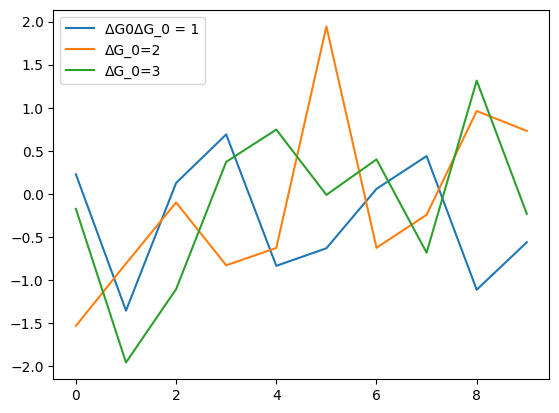

In [4]:
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure()
for _ in range(3):
    plt.plot(range(10), np.random.randn(10))
plt.legend([r'{} = 1'.format(ΔG0ΔG_0),r'ΔG_0=2',r'ΔG_0=3'])

plt.show()

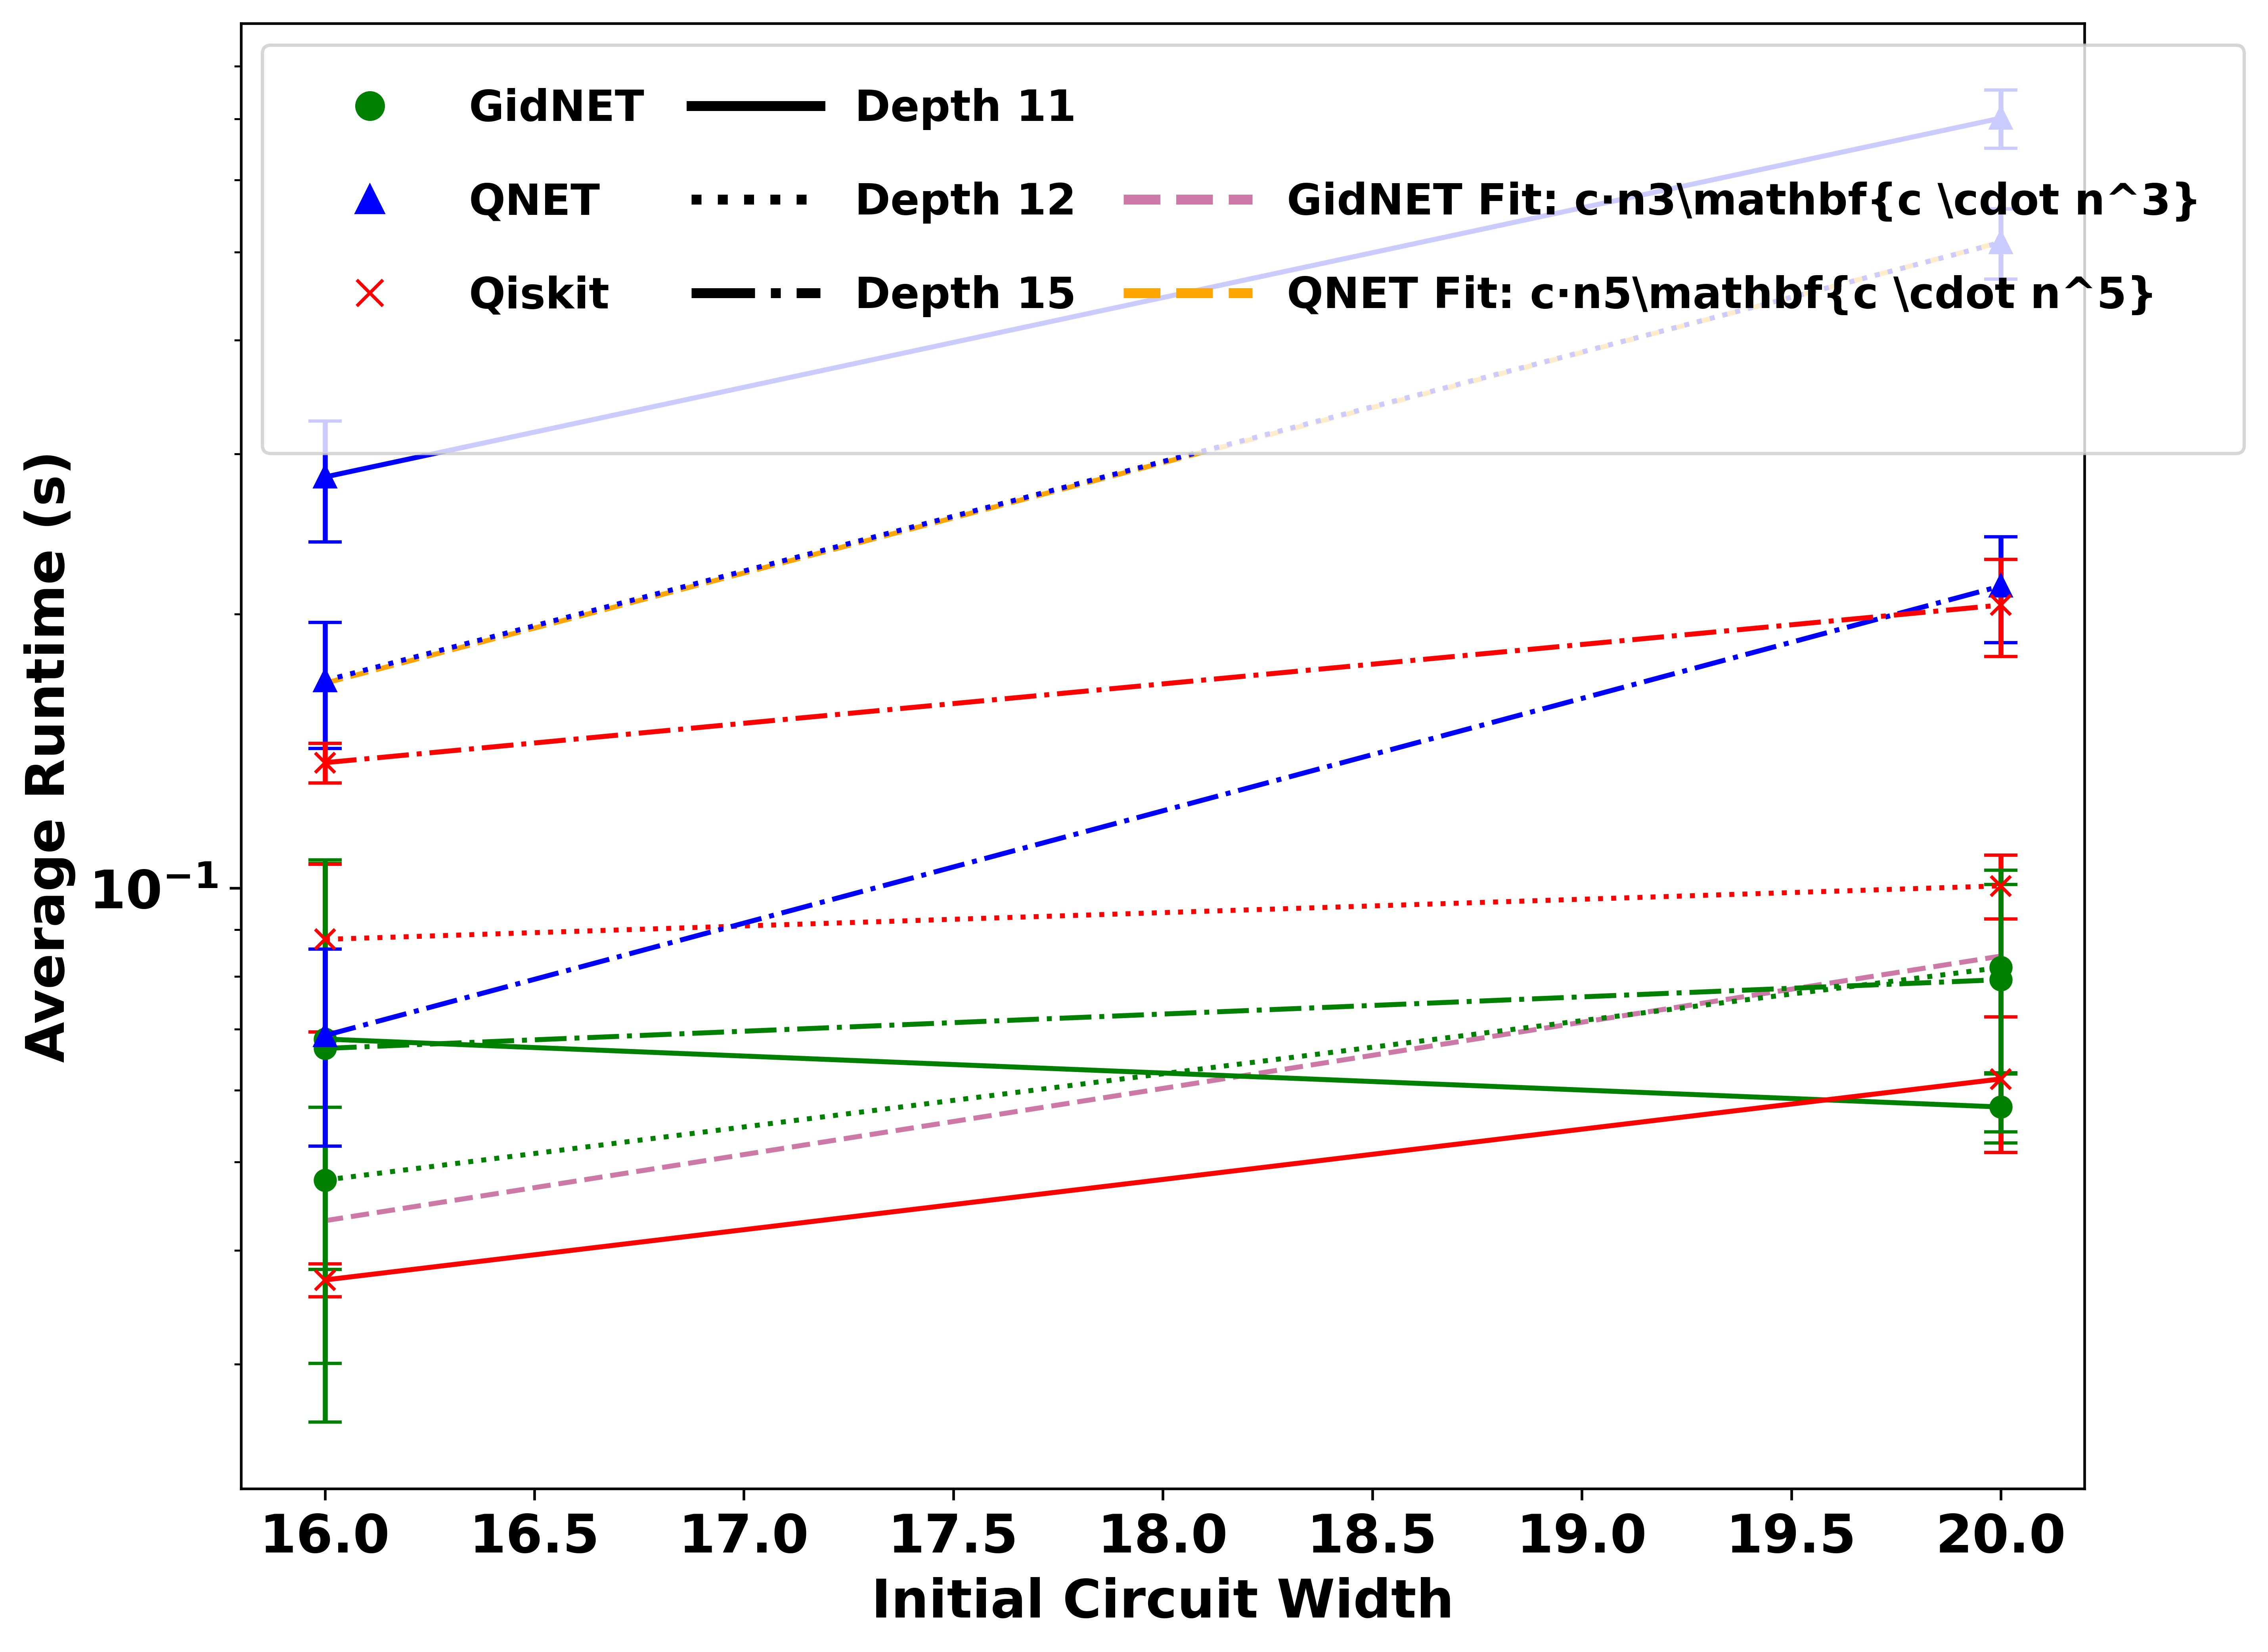

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D

# Define model functions for polynomial fitting
def model_gidnet(n, c):
    # return c * np.log2(n) * n**3
    return c * n**3

def model_qnet(n, c):
    return c * n**5

# Load data for each depth
data_path = Path("GRCS_result")
df11 = pd.read_csv(data_path / "width_and_runtime_GRCS_cct_depth_11.csv")
df12 = pd.read_csv(data_path / "width_and_runtime_GRCS_cct_depth_12.csv")
df15 = pd.read_csv(data_path / "width_and_runtime_GRCS_cct_depth_15.csv")

# Figure settings
plt.figure(figsize=(10, 8), dpi=600)

# Define colors, markers, and styles
colors = {'GidNET': 'green', 'QNET': 'blue', 'Qiskit': 'red'}
markers = {'GidNET': 'o', 'QNET': '^', 'Qiskit': 'x'}
algorithm_labels = list(colors.keys())
styles = ['-', ':', '-.']
depths = ['Depth 11', 'Depth 12', 'Depth 15']
depth_labels = ['Depth 11', 'Depth 12', 'Depth 15']
# fit_labels = [r'GidNET Fit: c⋅n3logn\mathbf{c \cdot n^3 \log{n}}', r'QNET Fit: c⋅n5\mathbf{c \cdot n^5}']
fit_labels = [r'GidNET Fit: c⋅n3\mathbf{c \cdot n^3}', r'QNET Fit: c⋅n5\mathbf{c \cdot n^5}']

# Plotting
dfs = [df11, df12, df15]
for i, df in enumerate(dfs):
    popt_gidnet, _ = curve_fit(model_gidnet, df["Circuit Size"], df["GidNET Mean Runtime"])
    popt_qnet, _ = curve_fit(model_qnet, df["Circuit Size"], df["QNET Mean Runtime"])

    plt.errorbar(df["Circuit Size"], df["GidNET Mean Runtime"], yerr=df["GidNET Stdev Runtime"],
                 fmt=styles[i], marker=markers['GidNET'], color=colors['GidNET'], capsize=5, label=f'GidNET {depths[i]}')
    if i==1:
        plt.plot(df["Circuit Size"], model_gidnet(df["Circuit Size"], *popt_gidnet), color='#cc79a7', linestyle="--",
             label=fit_labels[0])

    plt.errorbar(df["Circuit Size"], df["QNET Mean Runtime"], yerr=df["QNET Stdev Runtime"],
                 fmt=styles[i], marker=markers['QNET'], color=colors['QNET'], capsize=5, label=f'QNET {depths[i]}')
    if i==1:
        plt.plot(df["Circuit Size"], model_qnet(df["Circuit Size"], *popt_qnet), color="orange", linestyle="--",
             label=fit_labels[1])

    plt.errorbar(df["Circuit Size"], df["Qiskit Mean Runtime"], yerr=df["Qiskit Stdev Runtime"],
                 fmt=styles[i], marker=markers['Qiskit'], color=colors['Qiskit'], capsize=5, label=f'Qiskit {depths[i]}')

# Labels and scale
plt.xlabel('Initial Circuit Width', fontsize=16, fontweight='bold')
plt.ylabel('Average Runtime (s)', fontsize=16, fontweight='bold')
plt.yscale('log')

plt.xticks(fontweight='bold', fontsize=16)
plt.yticks(fontweight='bold', fontsize=16)

# Legends
# algorithm_handles = [Line2D([0], [0], marker=markers[name], color=colors[name], linestyle='None', markersize=10) for name in colors]
# depth_handles = [Line2D([0], [0], color='black', linestyle=style, markersize=10) for style in styles]
# fit_handles = [Line2D([0], [0], color='black', linestyle='--', markersize=10) for _ in fit_labels]

# combined_handles = algorithm_handles + [Line2D([0], [0], marker='None', linestyle='None')] + depth_handles + fit_handles
# combined_labels = list(colors.keys()) + [''] + depths + fit_labels

# Create custom legends
from matplotlib.lines import Line2D

# Legend for algorithms with just markers
algorithm_handles = [Line2D([0], [0], color=colors[key], marker=markers[key], linestyle='None', markersize=8) for key in colors]

# Legend for depths
depth_handles = [Line2D([0], [0], color='black', lw=3, linestyle=style) for style in styles]

# Legend for fits
fit_handles = [Line2D([0], [0], color=color, lw=3, linestyle='--', markersize=10) for color in ['#cc79a7', "orange"]]

# Introduce spacer to align legends side by side properly
spacer = Line2D([0], [0], color='none', marker='None', linestyle='None')

# Combine handles and labels with spacer
combined_handles = algorithm_handles + [spacer] + depth_handles + [spacer] + fit_handles
combined_labels = algorithm_labels + [""] + depth_labels + [""] + fit_labels

# plt.legend(prop={'size': 12, 'weight': 'bold'}, handles=combined_handles, labels=combined_labels, loc='upper left', ncol=4, frameon=True, fontsize=12, handlelength=2.5, handletextpad=0.5, columnspacing=3, borderpad=1)
plt.legend(prop={'size': 13, 'weight': 'bold'}, handles=combined_handles, labels=combined_labels, loc='upper left', ncol=3, handlelength=3, fontsize=12, frameon=True, borderpad=1, labelspacing=1.2, columnspacing=1.1)

# Save and display
plt.savefig(data_path / 'GidNET_QNET_Qiskit_runtime_comparison.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [10]:
[r'GidNET Fit: c⋅n3\mathbf{c \cdot n^3}', r'QNET Fit: c⋅n5\mathbf{c \cdot n^5}']

['GidNET Fit: c⋅n3\\mathbf{c \\cdot n^3}',
 'QNET Fit: c⋅n5\\mathbf{c \\cdot n^5}']

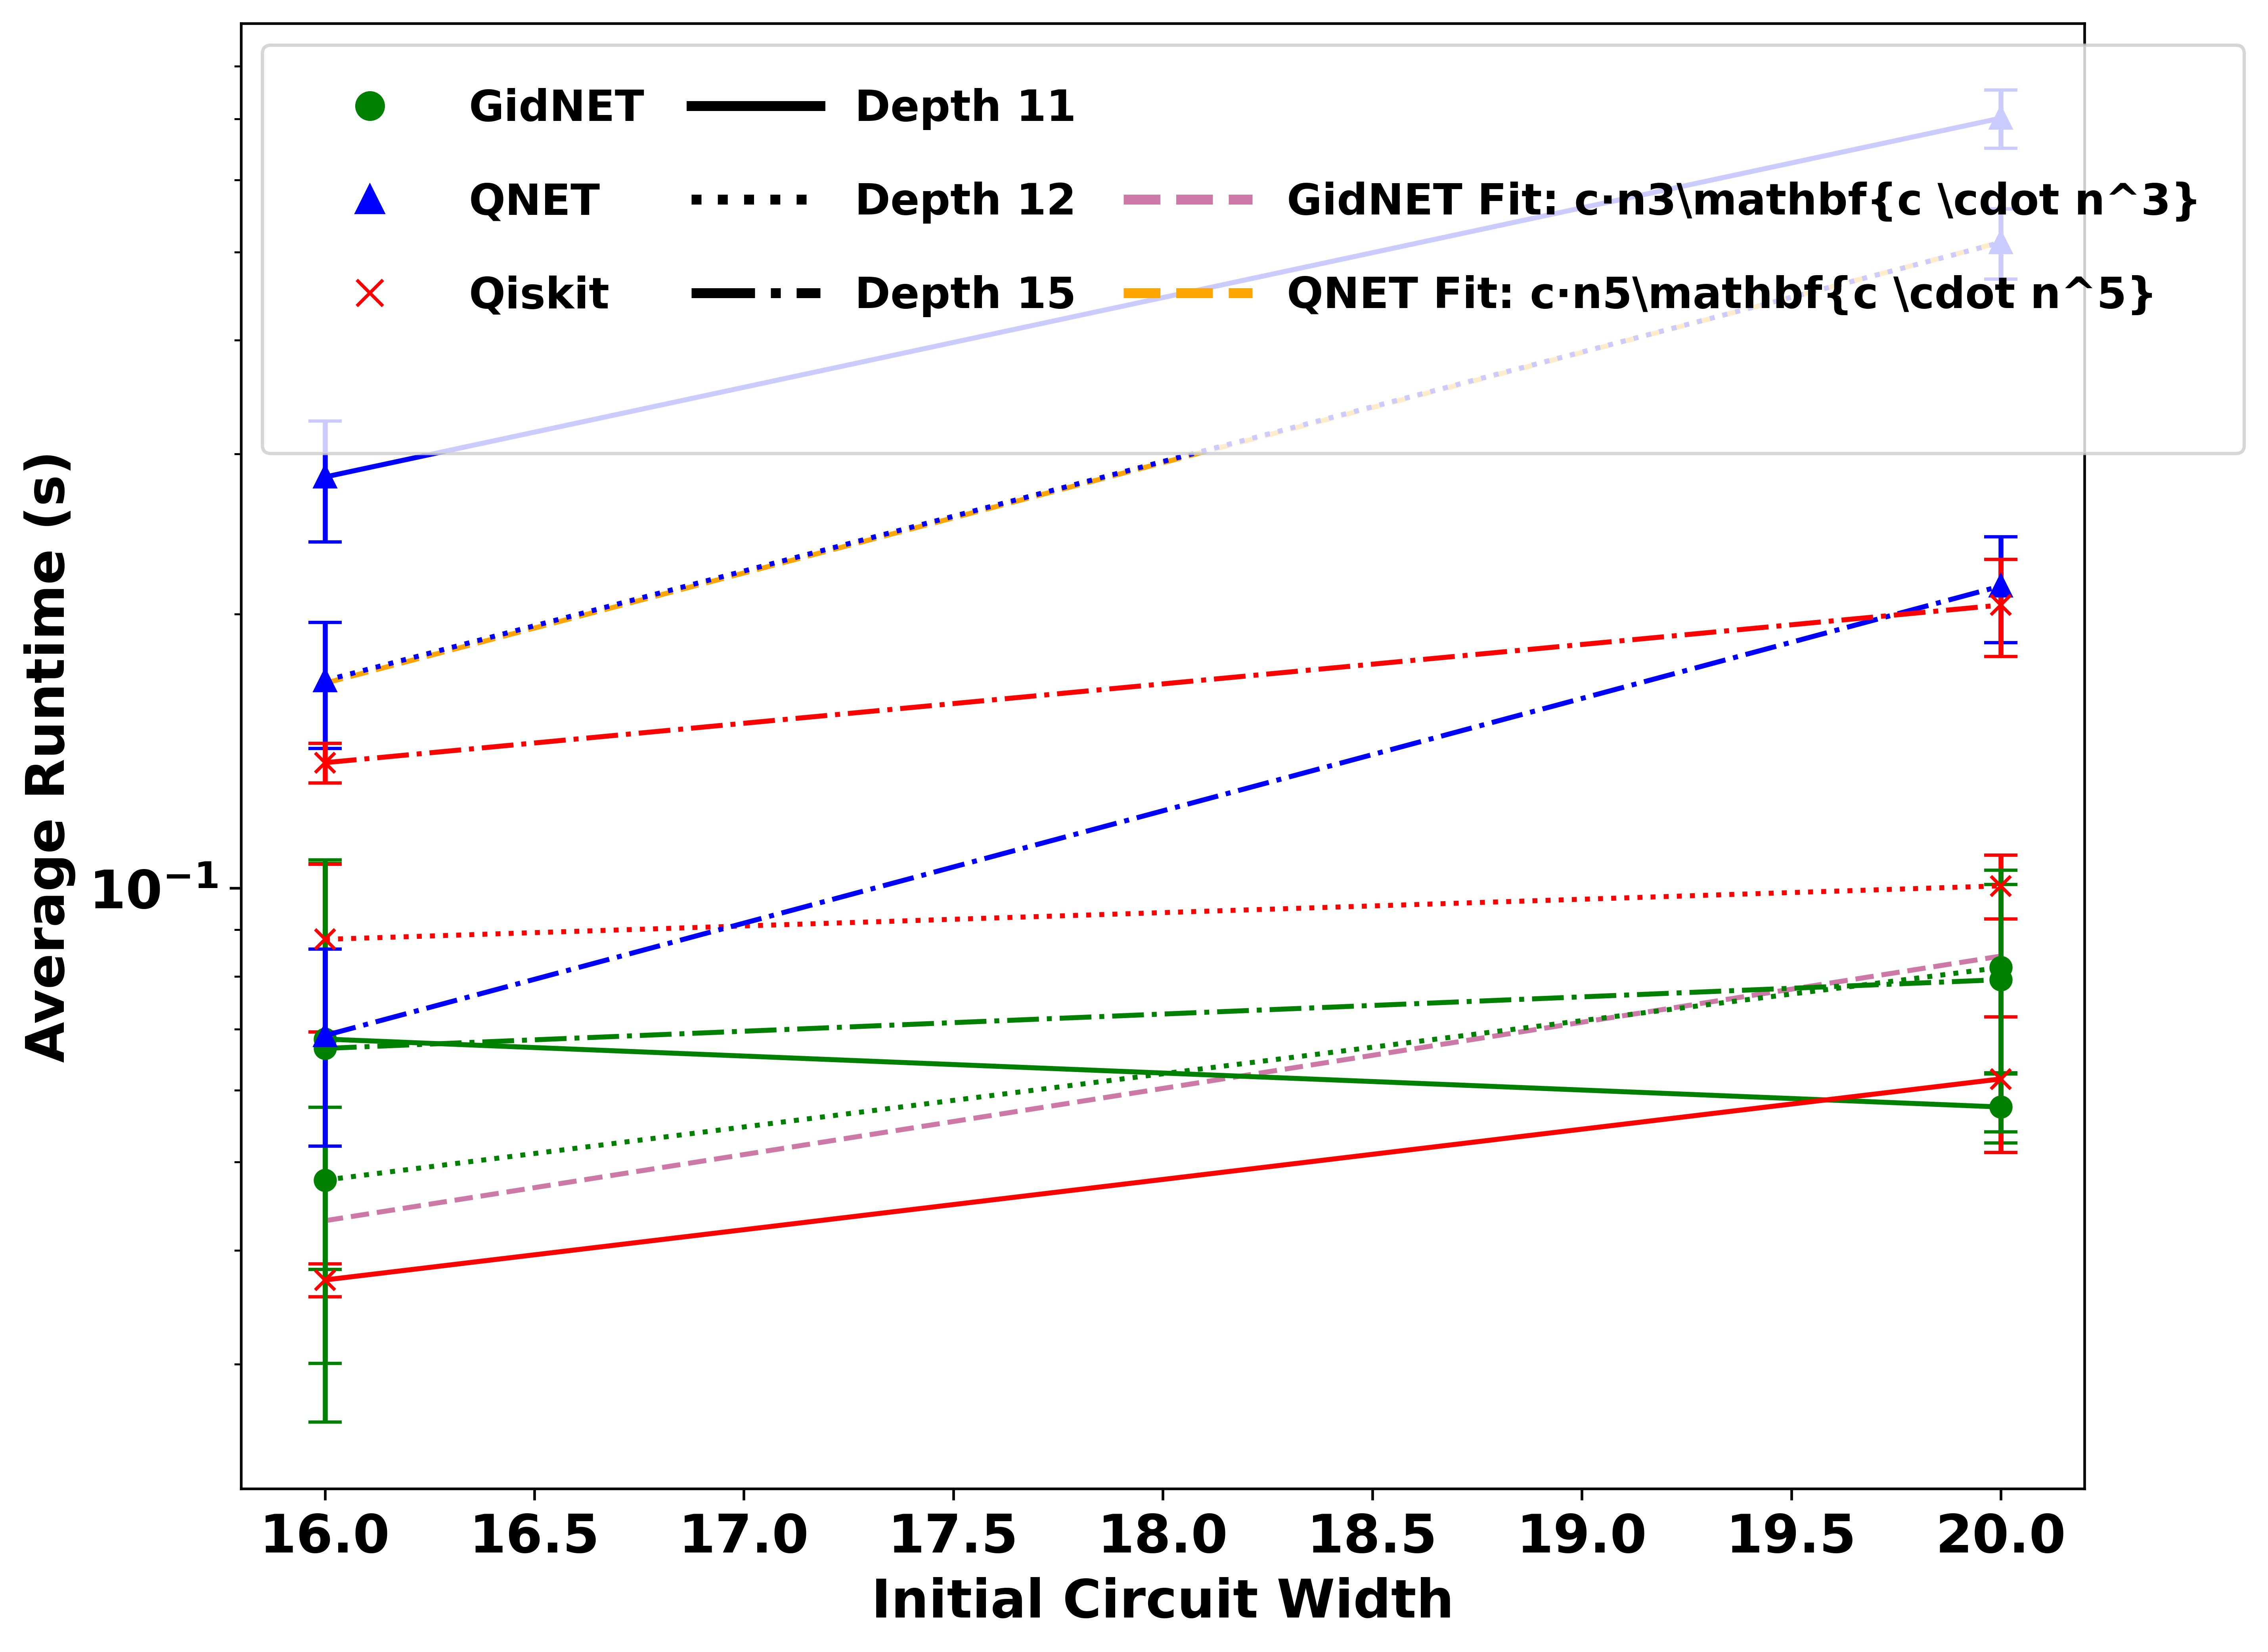

In [11]:
# second paper plot

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D

# Define model functions for polynomial fitting
def model_gidnet(n, c):
    # return c * np.log2(n) * n**3
    return c * n**3

def model_qnet(n, c):
    return c * n**5

# Load data for each depth
# df11 = pd.read_csv('combined_data/combined_v02_width_and_runtime_cutqc_supremacy_cct_data.csv')
# df12 = pd.read_csv('combined_data/combined_v02_width_and_runtime_supremacy_cct_cycle_10_data.csv')
# df15 = pd.read_csv('combined_data/combined_v02_width_and_runtime_supremacy_cct_cycle_13_data.csv')

# Load data for each depth
data_path = Path("GRCS_result")
df11 = pd.read_csv(data_path / "width_and_runtime_GRCS_cct_depth_11.csv")
df12 = pd.read_csv(data_path / "width_and_runtime_GRCS_cct_depth_12.csv")
df15 = pd.read_csv(data_path / "width_and_runtime_GRCS_cct_depth_15.csv")

# Figure settings
plt.figure(figsize=(10, 8), dpi=600)

# Define colors, markers, and styles
colors = {'GidNET': 'green', 'QNET': 'blue', 'Qiskit': 'red'}
markers = {'GidNET': 'o', 'QNET': '^', 'Qiskit': 'x'}
styles = ['-', ':', '-.']
depth_labels = ['Depth 11', 'Depth 12', 'Depth 15']
# fit_labels = [r'GidNET Fit: c⋅n3logn\mathbf{c \cdot n^3 \log{n}}', r'QNET Fit: c⋅n5\mathbf{c \cdot n^5}']
fit_labels = [r'GidNET Fit: c⋅n3\mathbf{c \cdot n^3}', r'QNET Fit: c⋅n5\mathbf{c \cdot n^5}']

# Plotting
dfs = [df11, df12, df15]
for i, df in enumerate(dfs):
    popt_gidnet, _ = curve_fit(model_gidnet, df["Circuit Size"], df["GidNET Mean Runtime"])
    popt_qnet, _ = curve_fit(model_qnet, df["Circuit Size"], df["QNET Mean Runtime"])

    plt.errorbar(df["Circuit Size"], df["GidNET Mean Runtime"], yerr=df["GidNET Stdev Runtime"],
                 fmt=styles[i], marker=markers['GidNET'], color=colors['GidNET'], capsize=5, label=f'GidNET {depth_labels[i]}')
    if i==1:
        plt.plot(df["Circuit Size"], model_gidnet(df["Circuit Size"], *popt_gidnet), color='#cc79a7', linestyle="--",
             label=fit_labels[0])

    plt.errorbar(df["Circuit Size"], df["QNET Mean Runtime"], yerr=df["QNET Stdev Runtime"],
                 fmt=styles[i], marker=markers['QNET'], color=colors['QNET'], capsize=5, label=f'QNET {depth_labels[i]}')
    if i==1:
        plt.plot(df["Circuit Size"], model_qnet(df["Circuit Size"], *popt_qnet), color="orange", linestyle="--",
             label=fit_labels[1])

    plt.errorbar(df["Circuit Size"], df["Qiskit Mean Runtime"], yerr=df["Qiskit Stdev Runtime"],
                 fmt=styles[i], marker=markers['Qiskit'], color=colors['Qiskit'], capsize=5, label=f'Qiskit {depth_labels[i]}')

# Labels and scale
plt.xlabel('Initial Circuit Width', fontsize=16, fontweight='bold')
plt.ylabel('Average Runtime (s)', fontsize=16, fontweight='bold')
plt.yscale('log')

plt.xticks(fontweight='bold', fontsize=16)
plt.yticks(fontweight='bold', fontsize=16)

# Legends
# algorithm_handles = [Line2D([0], [0], marker=markers[name], color=colors[name], linestyle='None', markersize=10) for name in colors]
# depth_handles = [Line2D([0], [0], color='black', linestyle=style, markersize=10) for style in styles]
# fit_handles = [Line2D([0], [0], color='black', linestyle='--', markersize=10) for _ in fit_labels]

# combined_handles = algorithm_handles + [Line2D([0], [0], marker='None', linestyle='None')] + depth_handles + fit_handles
# combined_labels = list(colors.keys()) + [''] + depths + fit_labels

# Create custom legends
from matplotlib.lines import Line2D

# Legend for algorithms with just markers
algorithm_handles = [Line2D([0], [0], color=colors[key], marker=markers[key], linestyle='None', markersize=8) for key in colors]

# Legend for depths
depth_handles = [Line2D([0], [0], color='black', lw=3, linestyle=style) for style in styles]

# Legend for fits
fit_handles = [Line2D([0], [0], color=color, lw=3, linestyle='--', markersize=10) for color in ['#cc79a7', "orange"]]

# Introduce spacer to align legends side by side properly
spacer = Line2D([0], [0], color='none', marker='None', linestyle='None')

# Combine handles and labels with spacer
combined_handles = algorithm_handles + [spacer] + depth_handles + [spacer] + fit_handles
combined_labels = algorithm_labels + [""] + depth_labels + [""] + fit_labels

# plt.legend(prop={'size': 12, 'weight': 'bold'}, handles=combined_handles, labels=combined_labels, loc='upper left', ncol=4, frameon=True, fontsize=12, handlelength=2.5, handletextpad=0.5, columnspacing=3, borderpad=1)
plt.legend(prop={'size': 13, 'weight': 'bold'}, handles=combined_handles, labels=combined_labels, loc='upper left', ncol=3, handlelength=3, fontsize=12, frameon=True, borderpad=1, labelspacing=1.2, columnspacing=1.1)

# Save and display
plt.savefig(data_path / 'GidNET_QNET_Qiskit_runtime_comparison.pdf', format='pdf', bbox_inches='tight')
plt.show()


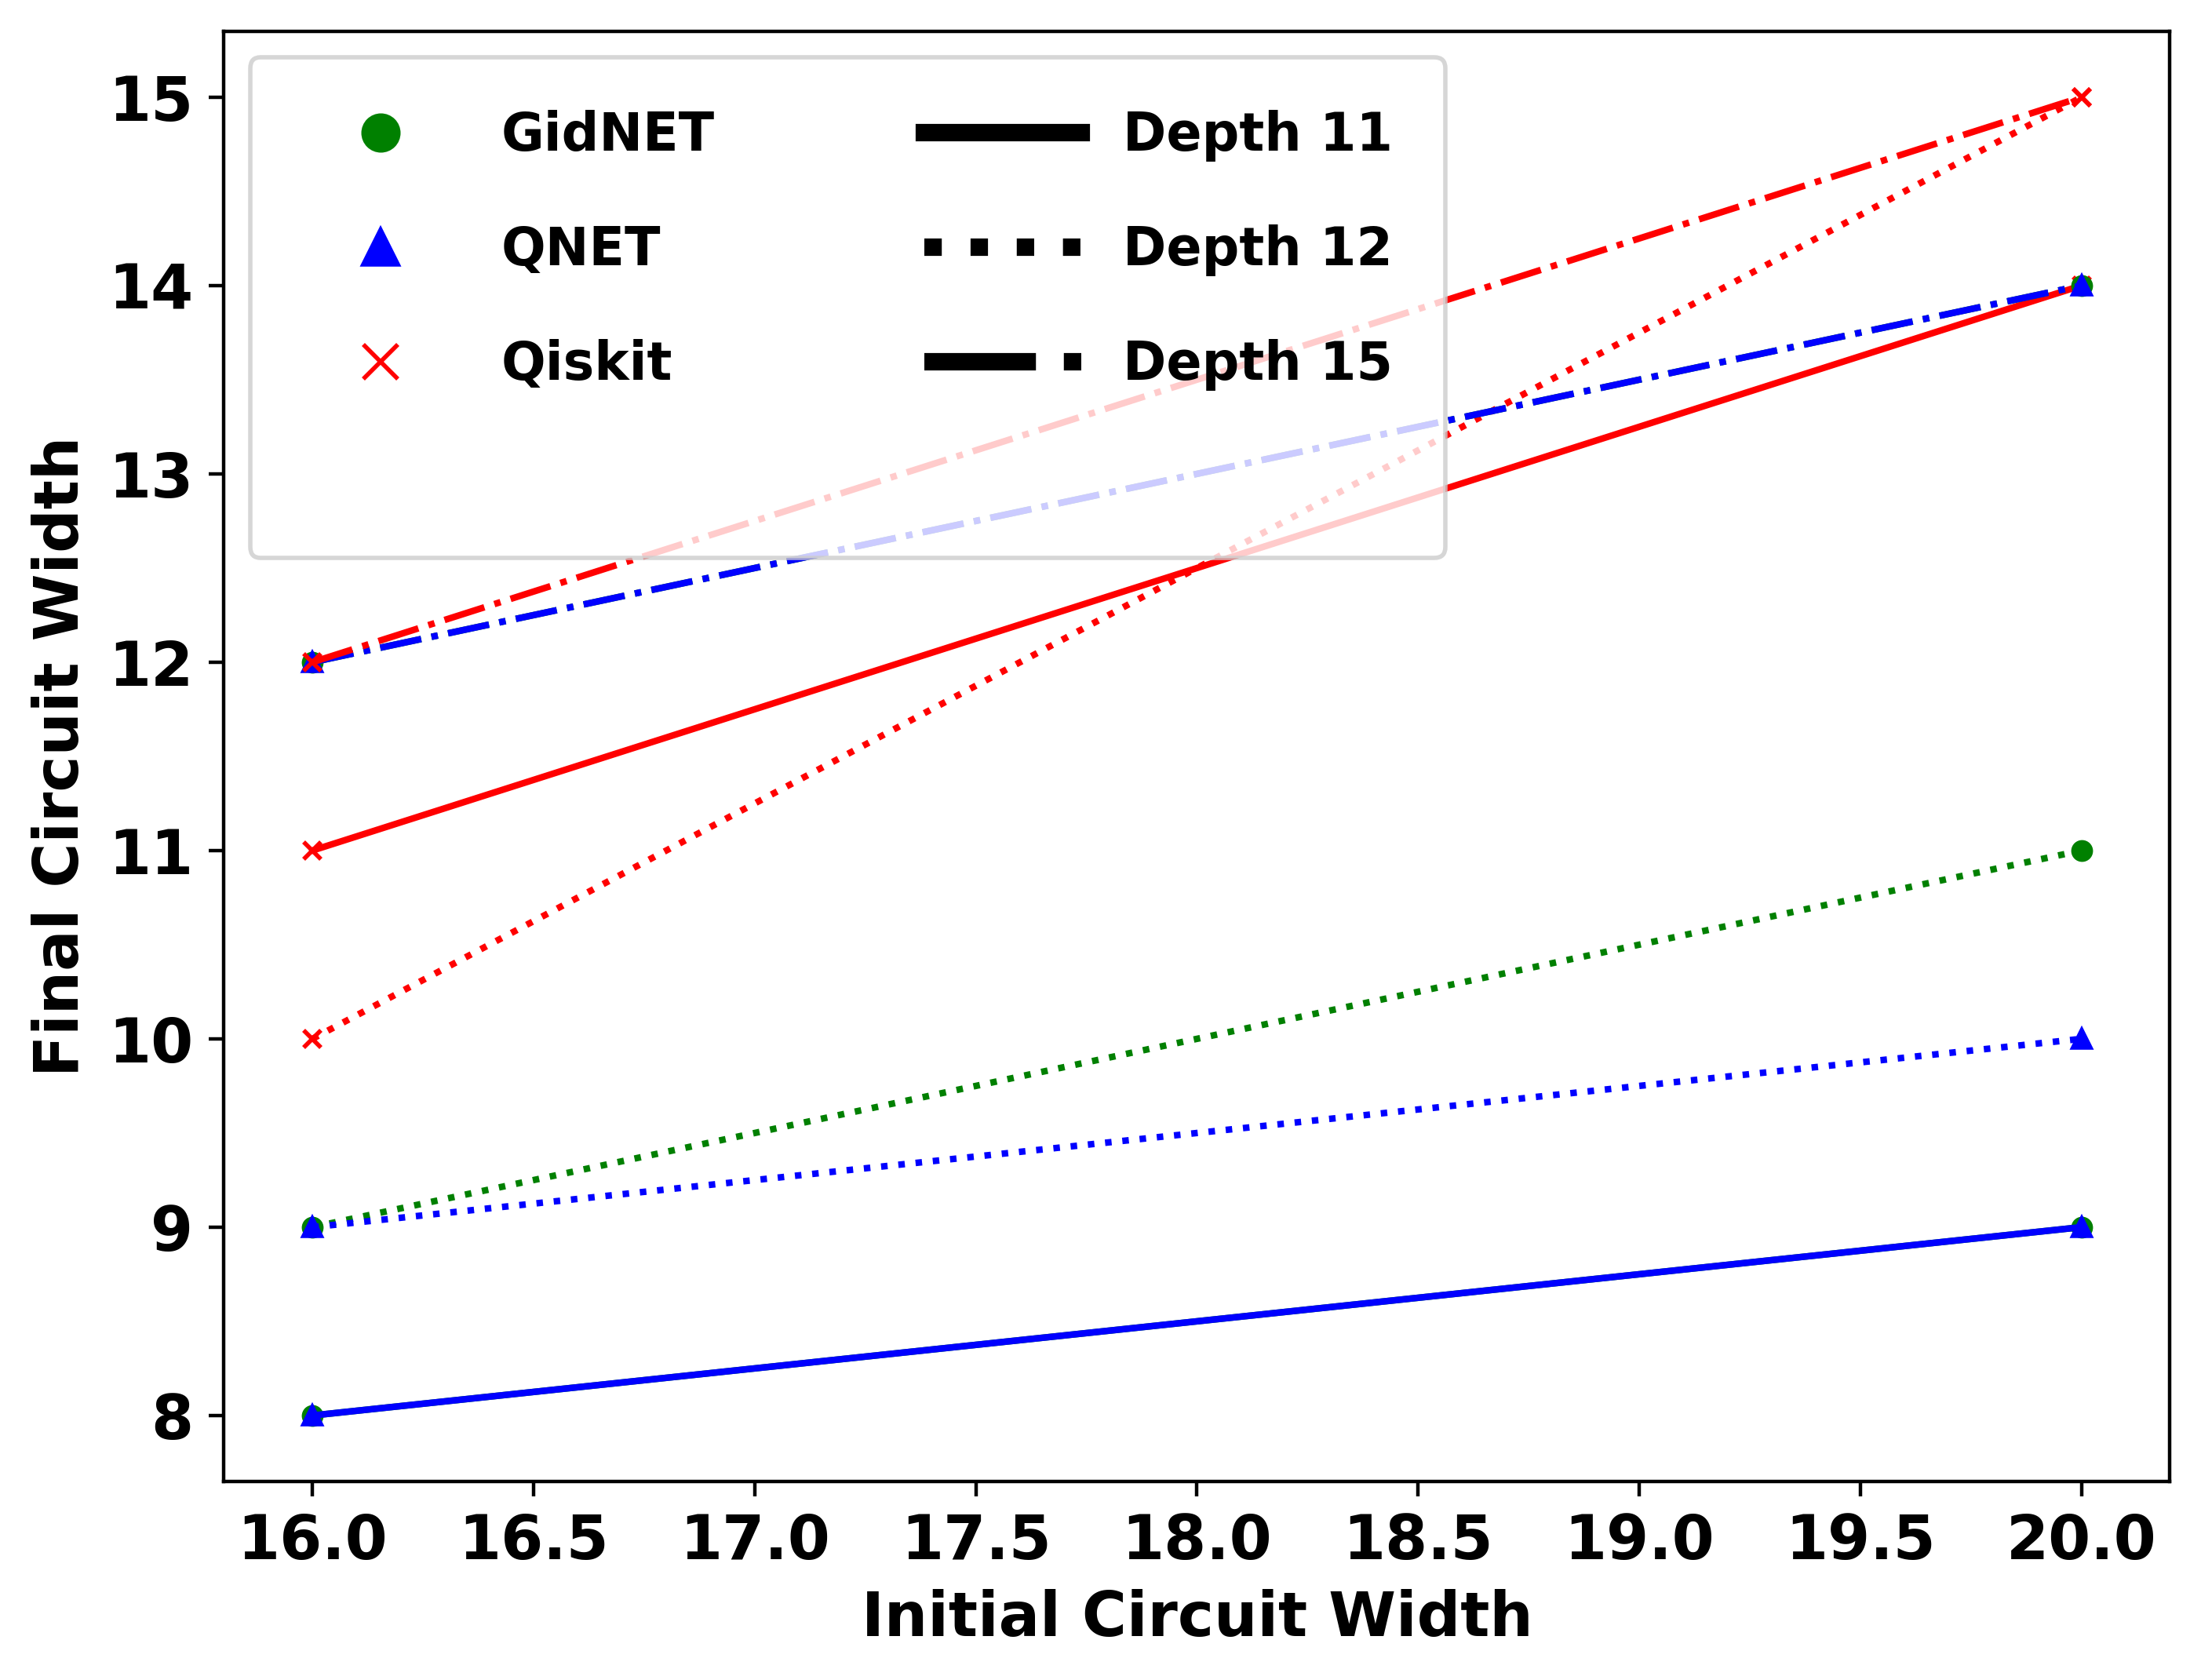

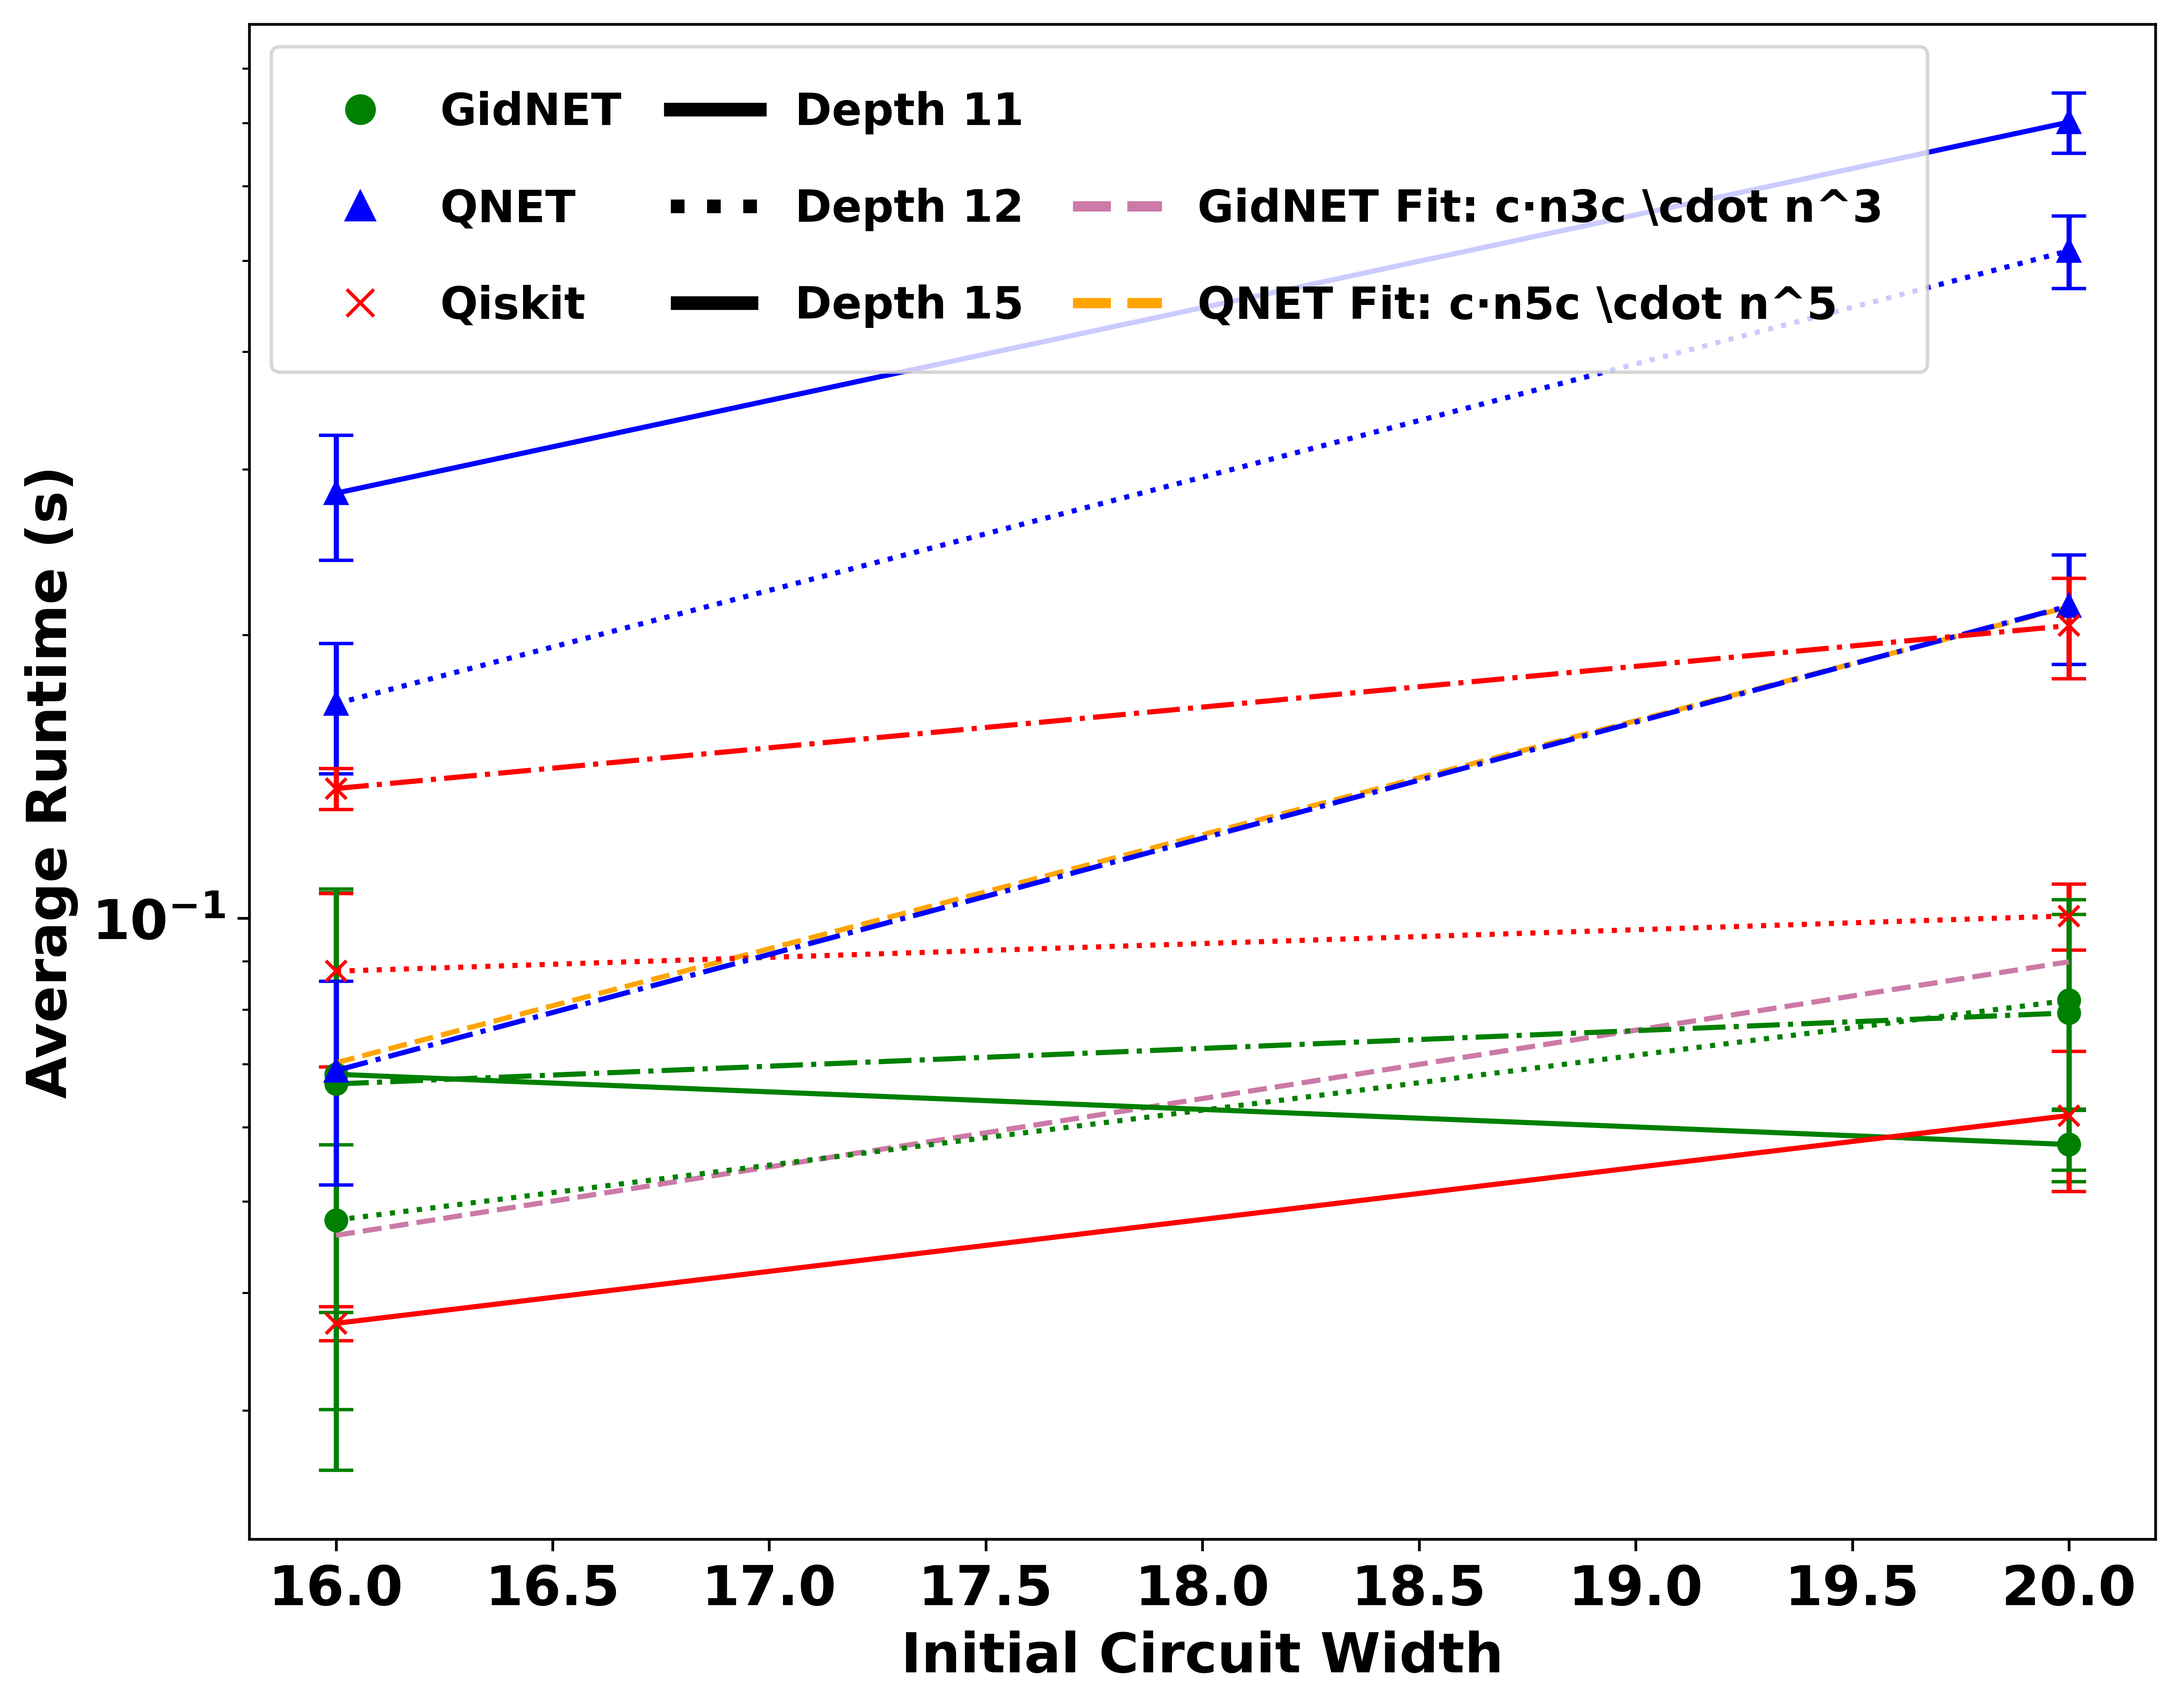

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from pathlib import Path
from matplotlib.lines import Line2D

# Load data for each depth
data_path = Path("GRCS_result")
df11 = pd.read_csv(data_path / "width_and_runtime_GRCS_cct_depth_11.csv")
df12 = pd.read_csv(data_path / "width_and_runtime_GRCS_cct_depth_12.csv")
df15 = pd.read_csv(data_path / "width_and_runtime_GRCS_cct_depth_15.csv")

# Adjust the figure size and set DPI for higher quality output
plt.figure(figsize=(8, 6), dpi=400)

# Define distinct linestyles
styles = ['-', ':', '-.']
depth_labels = ['Depth 11', 'Depth 12', 'Depth 15']

# Define colors and markers
colors = {'GidNET': 'green', 'QNET': 'blue', 'Qiskit': 'red'}
markers = {'GidNET': 'o', 'QNET': '^', 'Qiskit': 'x'}
algorithm_labels = list(colors.keys())

# Plot for each depth (GidNET, QNET, Qiskit)
for i, df in enumerate([df11, df12, df15]):
    plt.plot(df["Circuit Size"], df["GidNET Min Width"], marker=markers['GidNET'], color=colors['GidNET'], linestyle=styles[i], markersize=4)
    plt.plot(df["Circuit Size"], df["QNET Min Width"], marker=markers['QNET'], color=colors['QNET'], linestyle=styles[i], markersize=4)
    plt.plot(df["Circuit Size"], df["Qiskit Min Width"], marker=markers['Qiskit'], color=colors['Qiskit'], linestyle=styles[i], markersize=4)

# Adding titles and labels
plt.xlabel('Initial Circuit Width', fontsize=14, fontweight='bold')
plt.ylabel('Final Circuit Width', fontsize=14, fontweight='bold')

# Create custom legends
algorithm_handles = [Line2D([0], [0], color=colors[key], marker=markers[key], linestyle='None', markersize=8) for key in colors]
depth_handles = [Line2D([0], [0], color='black', lw=4, linestyle=style) for style in styles]
spacer = Line2D([0], [0], color='none', marker='None', linestyle='None')
combined_handles = algorithm_handles + [spacer] + depth_handles
combined_labels = algorithm_labels + [" "] + depth_labels

plt.legend(prop={'size': 12, 'weight': 'bold'}, handles=combined_handles, labels=combined_labels, loc='upper left', ncol=2, handlelength=3, fontsize=12, frameon=True, borderpad=1, labelspacing=1.2, columnspacing=4)
plt.xticks(fontweight='bold', fontsize=14)
plt.yticks(fontweight='bold', fontsize=14)
plt.savefig(data_path / 'GidNET_QNET_Qiskit_width_reduction.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Define polynomial model functions
def model_gidnet(n, c):
    return c * n**3

def model_qnet(n, c):
    return c * n**5

plt.figure(figsize=(10, 8), dpi=600)
for i, df in enumerate([df11, df12, df15]):
    popt_gidnet, _ = curve_fit(model_gidnet, df["Circuit Size"], df["GidNET Mean Runtime"])
    popt_qnet, _ = curve_fit(model_qnet, df["Circuit Size"], df["QNET Mean Runtime"])
    
    plt.errorbar(df["Circuit Size"], df["GidNET Mean Runtime"], yerr=df["GidNET Stdev Runtime"],
                 fmt=styles[i], marker=markers['GidNET'], color=colors['GidNET'], capsize=5, label=f'GidNET {depth_labels[i]}')
    plt.errorbar(df["Circuit Size"], df["QNET Mean Runtime"], yerr=df["QNET Stdev Runtime"],
                 fmt=styles[i], marker=markers['QNET'], color=colors['QNET'], capsize=5, label=f'QNET {depth_labels[i]}')
    plt.errorbar(df["Circuit Size"], df["Qiskit Mean Runtime"], yerr=df["Qiskit Stdev Runtime"],
                 fmt=styles[i], marker=markers['Qiskit'], color=colors['Qiskit'], capsize=5, label=f'Qiskit {depth_labels[i]}')
    
# if 1 in range(len([df11, df12, df15])):
#     plt.plot(df12["Circuit Size"], model_gidnet(df12["Circuit Size"], *popt_gidnet), color='#cc79a7', linestyle="--",
#              label=r'GidNET Fit: c⋅n3c \cdot n^3')
#     plt.plot(df12["Circuit Size"], model_qnet(df12["Circuit Size"], *popt_qnet), color="orange", linestyle="--",
#              label=r'QNET Fit: c⋅n5c \cdot n^5')

if 1 in range(len([df11, df12, df15])):
    plt.plot(df12["Circuit Size"], model_gidnet(df12["Circuit Size"], *popt_gidnet), color='#cc79a7', linestyle="--",
             label=r'GidNET Fit: c⋅n3c \cdot n^3')
    plt.plot(df12["Circuit Size"], model_qnet(df12["Circuit Size"], *popt_qnet), color="orange", linestyle="--",
             label=r'QNET Fit: c⋅n5c \cdot n^5')

plt.xlabel('Initial Circuit Width', fontsize=16, fontweight='bold')
plt.ylabel('Average Runtime (s)', fontsize=16, fontweight='bold')
plt.yscale('log')
plt.xticks(fontweight='bold', fontsize=16)
plt.yticks(fontweight='bold', fontsize=16)

legend_handles = algorithm_handles + depth_handles + [spacer] + [Line2D([0], [0], color='#cc79a7', linestyle="--", lw=3), Line2D([0], [0], color="orange", linestyle="--", lw=3)]
legend_labels = algorithm_labels + depth_labels + [" "] + [r'GidNET Fit: c⋅n3c \cdot n^3', r'QNET Fit: c⋅n5c \cdot n^5']

plt.legend(prop={'size': 13, 'weight': 'bold'}, handles=legend_handles, labels=legend_labels, loc='upper left', ncol=3, fontsize=12, frameon=True, borderpad=1, labelspacing=1.2, columnspacing=1.1)

# plt.legend(prop={'size': 13, 'weight': 'bold'}, handles=combined_handles, labels=combined_labels, loc='upper left', ncol=3, handlelength=3, fontsize=12, frameon=True, borderpad=1, labelspacing=1.2, columnspacing=1.1)


plt.savefig(data_path / 'GidNET_QNET_Qiskit_runtime_comparison.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [13]:
int(1e10)

10000000000

In [14]:
# from pathlib import Path

# # Get the current working directory (repo root if running from the repo)
# repo_path = Path.cwd()

# # Define the data directory path
# data_path = repo_path / "results" / "data" / "GRSC"

# print(f"Data directory: {data_path}")



In [15]:

# Generating data for Supremacy circuit of depth=11 
from benchmarks.biadu_qnet_qubit_reuse.baidu_qnet_qr import (compute_qnet_qubit_reuse_list, 
                                                  from_qiskit_to_qnet,
                                                 compute_qnet_qubit_reuse_list_timing)
from gidnet.qubitreuse import GidNET
from gidnet.utils import apply_qiskit_qubit_reuse
from benchmarks.qcg.helper_functions.benchmarks import generate_circ
from qiskit import QuantumCircuit
import numpy as np
import pandas as pd


circuit_sizes = [16, 20, 25, 30, 36, 42, 49, 56, 64, 72, 81, 90, 100, 110, 121, 132, 144]
circuit_sizes = [16, 20]
iterations = 10 # shots for qnet algorithm

# GidNET params
gidnet_average_time = []
gidnet_std_time = []
gidnet_qubit_width = []

# QNET params
qnet_average_time = []
qnet_std_time = []
qnet_qubit_width = []


# Qiskit Params
qiskit_average_time = []
qiskit_std_time = []
qiskit_qubit_width = []

for i, circuit_size in enumerate(circuit_sizes):
    print("circuit", i+1, "running")
    circuit_type = "supremacy"

    supremacy_circuit = generate_circ(
            num_qubits=circuit_size,
            depth=1,
            circuit_type=circuit_type,
            reg_name="q",
            connected_only=True,
            seed=None,
    )

    if supremacy_circuit is not None:
        supremacy_circuit.measure_all()

    gidnet = GidNET(supremacy_circuit)

    #### GIDNET EXPERIMENT BEGINS #####
    print("GidNET")
    gidnet_time = %timeit -o gidnet.compile_to_dynamic_circuit(iterations)

    gidnet_average_time.append(gidnet_time.average)
    gidnet_std_time.append(gidnet_time.stdev)
    gidnet_qubit_width.append(gidnet.dynamic_circuit_width)

    #### QNET EXPERIMENT BEGINS #####
    print("QNET")
    # convert Qiskit circuit to QNET circuit type
    qnet_supremacy_circuit = from_qiskit_to_qnet(supremacy_circuit)

    qnet_time = %timeit -o compute_qnet_qubit_reuse_list_timing(qnet_supremacy_circuit, method="random", shots=iterations)
    qnet_result = compute_qnet_qubit_reuse_list(qnet_supremacy_circuit, method="random", shots=iterations)

    qnet_average_time.append(qnet_time.average)
    qnet_std_time.append(qnet_time.stdev)
    qnet_qubit_width.append(len(qnet_result))


    #### Qiskit EXPERIMENT BEGINS #####
    print("Qiskit")
    qiskit_time = %timeit -o apply_qiskit_qubit_reuse(supremacy_circuit)
    compiled_qiskit_circuit = apply_qiskit_qubit_reuse(supremacy_circuit)

    qiskit_average_time.append(qiskit_time.average)
    qiskit_std_time.append(qiskit_time.stdev)
    qiskit_qubit_width.append(compiled_qiskit_circuit.num_qubits)

    print()



# Create DataFrames of results
df11_gidnet = pd.DataFrame(
    {
    'Circuit Sizes': circuit_sizes,
    'GidNET Average Runtime': gidnet_average_time,  # Added comma
    'GidNET Stdev Runtime': gidnet_std_time,  # Added comma
    'GidNET Width': gidnet_qubit_width,
    }
                        )


df11_qnet = pd.DataFrame( 
    {
    'Circuit Sizes': circuit_sizes,
    'QNET-random Average Runtime': qnet_average_time,  # Added comma
    'QNET-random Stdev Runtime': qnet_std_time,  # Added comma
    'QNET-random Width': qnet_qubit_width
    }
                        )

df11_qiskit = pd.DataFrame( 
    {
    'Circuit Sizes': circuit_sizes,
    'Qiskit Average Runtime': qiskit_average_time,  # Added comma
    'Qiskit Stdev Runtime': qiskit_std_time,  # Added comma
    'Qiskit Width': qiskit_qubit_width,
    }
                        )


# Merging the DataFrames on 'Circuit Sizes'
df11 = pd.merge(df11_gidnet, df11_qnet, on='Circuit Sizes', how='outer', suffixes=('_gidnet', '_qnet'))
df11 = pd.merge(df11, df11_qiskit, on='Circuit Sizes', how='outer', suffixes=('', '_qiskit'))

# Save the combined DataFrame to CSV
# df11.to_csv('data_supremacy_cct/width_and_runtime_supremacy_cct_depth_11.csv', index=False)

circuit 1 running
Generating 4x4, 1+8+1 supremacy circuit
GidNET
44.4 ms ± 3.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
QNET
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
305 ms ± 52.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Qiskit
38.1 ms ± 3.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

circuit 2 running
Generating 5x4, 1+8+1 supremacy circuit
GidNET
55.2 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
QNET
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1


KeyboardInterrupt: 

In [ ]:
# Generating data for Supremacy circuit of depth=12
from pathlib import Path
from benchmarks.biadu_qnet_qubit_reuse.baidu_qnet_qr import (compute_qnet_qubit_reuse_list, 
                                                  from_qiskit_to_qnet,
                                                 compute_qnet_qubit_reuse_list_timing)
from gidnet.qubitreuse import GidNET
from gidnet.utils import safe_eval, apply_qiskit_qubit_reuse, create_qiskit_and_qnet_GRCS_circuits
from benchmarks.qcg.helper_functions.benchmarks import generate_circ
from qiskit import QuantumCircuit
import numpy as np
import pandas as pd


# Get the current working directory (repo root if running from the repo)
repo_path = Path.cwd()

# Define the data directory path
directory_path = repo_path / "data" / "GRSC"

circuit_sizes = ["4x4", "4x5", "5x5", "5x6", "6x6", "6x7", "7x7", "7x8", "8x8", "8x9",
                "9x9", "9x10", "10x10", "10x11", "11x11", "11x12", "12x12"]

cycle_num = 10  # depth =12
iterations = 10


# GidNET params
gidnet_average_time = []
gidnet_std_time = []
gidnet_qubit_width = []

# QNET params
qnet_average_time = []
qnet_std_time = []
qnet_qubit_width = []


# Qiskit Params
qiskit_average_time = []
qiskit_std_time = []
qiskit_qubit_width = []

for i, num_qubits in enumerate(circuit_sizes):
    print("circuit", i+1, "running")
    qiskit_circuit, qnet_circuit = create_qiskit_and_qnet_GRCS_circuits(num_qubits, cycle_num, directory_path)


    #### GIDNET EXPERIMENT BEGINS #####
    print("GidNET")
    gidnet = GidNET(qiskit_circuit)
    gidnet_time = %timeit -o gidnet.compile_to_dynamic_circuit(iterations)

    gidnet_average_time.append(gidnet_time.average)
    gidnet_std_time.append(gidnet_time.stdev)
    gidnet_qubit_width.append(gidnet.dynamic_circuit_width)

    #### QNET EXPERIMENT BEGINS #####
    print("QNET")
    # convert Qiskit circuit to QNET circuit type
    qnet_time = %timeit -o compute_qnet_qubit_reuse_list_timing(qnet_circuit, method="random", shots=iterations)
    qnet_result = compute_qnet_qubit_reuse_list(qnet_circuit, method="random", shots=iterations)

    qnet_average_time.append(qnet_time.average)
    qnet_std_time.append(qnet_time.stdev)
    qnet_qubit_width.append(len(qnet_result))


    #### Qiskit EXPERIMENT BEGINS #####
    print("Qiskit")
    qiskit_time = %timeit -o apply_qiskit_qubit_reuse(qiskit_circuit)
    compiled_qiskit_circuit = apply_qiskit_qubit_reuse(qiskit_circuit)

    qiskit_average_time.append(qiskit_time.average)
    qiskit_std_time.append(qiskit_time.stdev)
    qiskit_qubit_width.append(compiled_qiskit_circuit.num_qubits)

    print()


# Create DataFrames of results
df12_gidnet = pd.DataFrame(
    {
    'Circuit Sizes': [safe_eval(s) for s in circuit_sizes],
    'GidNET Average Runtime': gidnet_average_time,  # Added comma
    'GidNET Stdev Runtime': gidnet_std_time,  # Added comma
    'GidNET Width': gidnet_qubit_width,
    }
                        )


df12_qnet = pd.DataFrame( 
    {
    'Circuit Sizes': [safe_eval(s) for s in circuit_sizes],
    'QNET-random Average Runtime': qnet_average_time,  # Added comma
    'QNET-random Stdev Runtime': qnet_std_time,  # Added comma
    'QNET-random Width': qnet_qubit_width
    }
                        )

df12_qiskit = pd.DataFrame( 
    {
    'Circuit Sizes': [safe_eval(s) for s in circuit_sizes],
    'Qiskit Average Runtime': qiskit_average_time,  # Added comma
    'Qiskit Stdev Runtime': qiskit_std_time,  # Added comma
    'Qiskit Width': qiskit_qubit_width,
    }
                        )


# Merging the DataFrames on 'Circuit Sizes'
df12 = pd.merge(df12_gidnet, df12_qnet, on='Circuit Sizes', how='outer', suffixes=('_gidnet', '_qnet'))
df12 = pd.merge(df12, df12_qiskit, on='Circuit Sizes', how='outer', suffixes=('', '_qiskit'))


In [ ]:
# Generating data for Supremacy circuit of depth=15
from pathlib import Path
from benchmarks.biadu_qnet_qubit_reuse.baidu_qnet_qr import (compute_qnet_qubit_reuse_list, 
                                                  from_qiskit_to_qnet,
                                                 compute_qnet_qubit_reuse_list_timing)
from gidnet.qubitreuse import GidNET
from gidnet.utils import safe_eval, apply_qiskit_qubit_reuse, create_qiskit_and_qnet_GRCS_circuits
from benchmarks.qcg.helper_functions.benchmarks import generate_circ
from qiskit import QuantumCircuit
import numpy as np
import pandas as pd



# Get the current working directory (repo root if running from the repo)
repo_path = Path.cwd()

# Define the data directory path
# directory_path = repo_path / "results" / "data" / "GRSC"
directory_path = repo_path / "data" / "GRSC"

# print(f"Data directory: {data_path}")

circuit_sizes = ["4x4", "4x5", "5x5", "5x6", "6x6", "6x7", "7x7", "7x8", "8x8", "8x9",
                "9x9", "9x10", "10x10", "10x11", "11x11", "11x12", "12x12"]

cycle_num = 13  # depth = 15
iterations = 10


# GidNET params
gidnet_average_time = []
gidnet_std_time = []
gidnet_qubit_width = []

# QNET params
qnet_average_time = []
qnet_std_time = []
qnet_qubit_width = []


# Qiskit Params
qiskit_average_time = []
qiskit_std_time = []
qiskit_qubit_width = []

for i, num_qubits in enumerate(circuit_sizes):
    print("circuit", i+1, "running")
    qiskit_circuit, qnet_circuit = create_qiskit_and_qnet_GRCS_circuits(num_qubits, cycle_num, directory_path)


    #### GIDNET EXPERIMENT BEGINS #####
    print("GidNET")
    gidnet = GidNET(qiskit_circuit)
    gidnet_time = %timeit -o gidnet.compile_to_dynamic_circuit(iterations)

    gidnet_average_time.append(gidnet_time.average)
    gidnet_std_time.append(gidnet_time.stdev)
    gidnet_qubit_width.append(gidnet.dynamic_circuit_width)

    #### QNET EXPERIMENT BEGINS #####
    print("QNET")
    # convert Qiskit circuit to QNET circuit type
    qnet_time = %timeit -o compute_qnet_qubit_reuse_list_timing(qnet_circuit, method="random", shots=iterations)
    qnet_result = compute_qnet_qubit_reuse_list(qnet_circuit, method="random", shots=iterations)

    qnet_average_time.append(qnet_time.average)
    qnet_std_time.append(qnet_time.stdev)
    qnet_qubit_width.append(len(qnet_result))


    #### Qiskit EXPERIMENT BEGINS #####
    print("Qiskit")
    qiskit_time = %timeit -o apply_qiskit_qubit_reuse(qiskit_circuit)
    compiled_qiskit_circuit = apply_qiskit_qubit_reuse(qiskit_circuit)

    qiskit_average_time.append(qiskit_time.average)
    qiskit_std_time.append(qiskit_time.stdev)
    qiskit_qubit_width.append(compiled_qiskit_circuit.num_qubits)

    print()


# Create DataFrames of results
df12_gidnet = pd.DataFrame(
    {
    'Circuit Sizes': [safe_eval(s) for s in circuit_sizes],
    'GidNET Average Runtime': gidnet_average_time,  # Added comma
    'GidNET Stdev Runtime': gidnet_std_time,  # Added comma
    'GidNET Width': gidnet_qubit_width,
    }
                        )


df12_qnet = pd.DataFrame( 
    {
    'Circuit Sizes': [safe_eval(s) for s in circuit_sizes],
    'QNET-random Average Runtime': qnet_average_time,  # Added comma
    'QNET-random Stdev Runtime': qnet_std_time,  # Added comma
    'QNET-random Width': qnet_qubit_width
    }
                        )

df12_qiskit = pd.DataFrame( 
    {
    'Circuit Sizes': [safe_eval(s) for s in circuit_sizes],
    'Qiskit Average Runtime': qiskit_average_time,  # Added comma
    'Qiskit Stdev Runtime': qiskit_std_time,  # Added comma
    'Qiskit Width': qiskit_qubit_width,
    }
                        )


# Merging the DataFrames on 'Circuit Sizes'
df12 = pd.merge(df12_gidnet, df12_qnet, on='Circuit Sizes', how='outer', suffixes=('_gidnet', '_qnet'))
df12 = pd.merge(df12, df12_qiskit, on='Circuit Sizes', how='outer', suffixes=('', '_qiskit'))


In [ ]:
# Combination of df11, df12 and df15 data

# first plot

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the data for each depth
df11 = pd.read_csv('combined_data/combined_v02_width_and_runtime_cutqc_supremacy_cct_data.csv')
df12 = pd.read_csv('combined_data/combined_v02_width_and_runtime_supremacy_cct_cycle_10_data.csv')
df15 = pd.read_csv('combined_data/combined_v02_width_and_runtime_supremacy_cct_cycle_13_data.csv')

# Adjust the figure size and set DPI for higher quality output
plt.figure(figsize=(8, 6), dpi=400)

# Define distinct linestyles
styles = ['-', ':', '-.']
depth_labels = ['Depth 11', 'Depth 12', 'Depth 15']

# Define colors and markers
colors = {'GidNET': 'green', 'QNET': 'blue', 'Qiskit': 'red'}
markers = {'GidNET': 'o', 'QNET': '^', 'Qiskit': 'x'}
algorithm_labels = list(colors.keys())

# Plot for each depth (GidNET, QNET, Qiskit)
for i, df in enumerate([df11, df12, df15]):
    plt.plot(df["Circuit Sizes"], df["GidNET Width"], marker=markers['GidNET'], color=colors['GidNET'], linestyle=styles[i], markersize=4)
    plt.plot(df["Circuit Sizes"], df["QNET Width"], marker=markers['QNET'], color=colors['QNET'], linestyle=styles[i], markersize=4)
    plt.plot(df["Circuit Sizes"], df["Qiskit Width"], marker=markers['Qiskit'], color=colors['Qiskit'], linestyle=styles[i], markersize=4)

# Adding titles and labels
plt.xlabel('Initial Circuit Width', fontsize=14, fontweight='bold')
plt.ylabel('Final Circuit Width', fontsize=14, fontweight='bold')

# Create custom legends
from matplotlib.lines import Line2D

# Legend for algorithms with just markers
algorithm_handles = [Line2D([0], [0], color=colors[key], marker=markers[key], linestyle='None', markersize=8) for key in colors]

# Legend for depths
depth_handles = [Line2D([0], [0], color='black', lw=4, linestyle=style) for style in styles]

# Introduce spacer to align legends side by side properly
spacer = Line2D([0], [0], color='none', marker='None', linestyle='None')

# Combine handles and labels with spacer
combined_handles = algorithm_handles + [spacer] + depth_handles
combined_labels = algorithm_labels + [""] + depth_labels

# Add single legend
plt.legend(prop={'size': 12, 'weight': 'bold'}, handles=combined_handles, labels=combined_labels, loc='upper left', ncol=2, handlelength=3, fontsize=12, frameon=True, borderpad=1, labelspacing=1.2, columnspacing=4)

plt.xticks(fontweight='bold', fontsize=14)
plt.yticks(fontweight='bold', fontsize=14)

# Enable grid for better visibility
# plt.grid(True)

# Save the figure as a PDF file for high-quality vector graphics
plt.savefig('combined_plots/GidNET_v02_QNET_and_Qiskit_width_reduction.pdf', format='pdf', bbox_inches='tight')

# Display the plot
plt.show()


In [ ]:
# second paper plot

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D

# Define model functions for polynomial fitting
def model_gidnet(n, c):
    # return c * np.log2(n) * n**3
    return c * n**3

def model_qnet(n, c):
    return c * n**5

# Load data for each depth
df11 = pd.read_csv('combined_data/combined_v02_width_and_runtime_cutqc_supremacy_cct_data.csv')
df12 = pd.read_csv('combined_data/combined_v02_width_and_runtime_supremacy_cct_cycle_10_data.csv')
df15 = pd.read_csv('combined_data/combined_v02_width_and_runtime_supremacy_cct_cycle_13_data.csv')

# Figure settings
plt.figure(figsize=(10, 8), dpi=600)

# Define colors, markers, and styles
colors = {'GidNET': 'green', 'QNET': 'blue', 'Qiskit': 'red'}
markers = {'GidNET': 'o', 'QNET': '^', 'Qiskit': 'x'}
styles = ['-', ':', '-.']
depth_labels = ['Depth 11', 'Depth 12', 'Depth 15']
# fit_labels = [r'GidNET Fit: c⋅n3logn\mathbf{c \cdot n^3 \log{n}}', r'QNET Fit: c⋅n5\mathbf{c \cdot n^5}']
fit_labels = [r'GidNET Fit: c⋅n3\mathbf{c \cdot n^3}', r'QNET Fit: c⋅n5\mathbf{c \cdot n^5}']

# Plotting
dfs = [df11, df12, df15]
for i, df in enumerate(dfs):
    popt_gidnet, _ = curve_fit(model_gidnet, df["Circuit Sizes"], df["GidNET Average Runtime"])
    popt_qnet, _ = curve_fit(model_qnet, df["Circuit Sizes"], df["QNET Average Runtime"])

    plt.errorbar(df["Circuit Sizes"], df["GidNET Average Runtime"], yerr=df["GidNET Stdev Runtime"],
                 fmt=styles[i], marker=markers['GidNET'], color=colors['GidNET'], capsize=5, label=f'GidNET {depth_labels[i]}')
    if i==1:
        plt.plot(df["Circuit Sizes"], model_gidnet(df["Circuit Sizes"], *popt_gidnet), color='#cc79a7', linestyle="--",
             label=fit_labels[0])

    plt.errorbar(df["Circuit Sizes"], df["QNET Average Runtime"], yerr=df["QNET Stdev Runtime"],
                 fmt=styles[i], marker=markers['QNET'], color=colors['QNET'], capsize=5, label=f'QNET {depth_labels[i]}')
    if i==1:
        plt.plot(df["Circuit Sizes"], model_qnet(df["Circuit Sizes"], *popt_qnet), color="orange", linestyle="--",
             label=fit_labels[1])

    plt.errorbar(df["Circuit Sizes"], df["Qiskit Average Runtime"], yerr=df["Qiskit Stdev Runtime"],
                 fmt=styles[i], marker=markers['Qiskit'], color=colors['Qiskit'], capsize=5, label=f'Qiskit {depth_labels[i]}')

# Labels and scale
plt.xlabel('Initial Circuit Width', fontsize=16, fontweight='bold')
plt.ylabel('Average Runtime (s)', fontsize=16, fontweight='bold')
plt.yscale('log')

plt.xticks(fontweight='bold', fontsize=16)
plt.yticks(fontweight='bold', fontsize=16)

# Legends
# algorithm_handles = [Line2D([0], [0], marker=markers[name], color=colors[name], linestyle='None', markersize=10) for name in colors]
# depth_handles = [Line2D([0], [0], color='black', linestyle=style, markersize=10) for style in styles]
# fit_handles = [Line2D([0], [0], color='black', linestyle='--', markersize=10) for _ in fit_labels]

# combined_handles = algorithm_handles + [Line2D([0], [0], marker='None', linestyle='None')] + depth_handles + fit_handles
# combined_labels = list(colors.keys()) + [''] + depths + fit_labels

# Create custom legends
from matplotlib.lines import Line2D

# Legend for algorithms with just markers
algorithm_handles = [Line2D([0], [0], color=colors[key], marker=markers[key], linestyle='None', markersize=8) for key in colors]

# Legend for depths
depth_handles = [Line2D([0], [0], color='black', lw=3, linestyle=style) for style in styles]

# Legend for fits
fit_handles = [Line2D([0], [0], color=color, lw=3, linestyle='--', markersize=10) for color in ['#cc79a7', "orange"]]

# Introduce spacer to align legends side by side properly
spacer = Line2D([0], [0], color='none', marker='None', linestyle='None')

# Combine handles and labels with spacer
combined_handles = algorithm_handles + [spacer] + depth_handles + [spacer] + fit_handles
combined_labels = algorithm_labels + [""] + depth_labels + [""] + fit_labels

# plt.legend(prop={'size': 12, 'weight': 'bold'}, handles=combined_handles, labels=combined_labels, loc='upper left', ncol=4, frameon=True, fontsize=12, handlelength=2.5, handletextpad=0.5, columnspacing=3, borderpad=1)
plt.legend(prop={'size': 13, 'weight': 'bold'}, handles=combined_handles, labels=combined_labels, loc='upper left', ncol=3, handlelength=3, fontsize=12, frameon=True, borderpad=1, labelspacing=1.2, columnspacing=1.1)

# Save and display
plt.savefig('combined_plots/GidNET_QNET_Qiskit_runtime_comparison.pdf', format='pdf', bbox_inches='tight')
plt.show()


### F-test and R-squared values

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Define your circuit sizes and corresponding theoretical and experimental values
circuit_size = np.array(df["Circuit Sizes"])
theoretical_values = np.array(model_gidnet(df["Circuit Sizes"], *popt_gidnet))
experimental_values = np.array(df["GidNET Average Runtime"])

# Fit the polynomial regression
degree=3
poly_features = PolynomialFeatures(degree)
X_poly = poly_features.fit_transform(circuit_size.reshape(-1, 1))
model = LinearRegression().fit(X_poly, experimental_values)
predicted_values = model.predict(X_poly)

# Calculate R-squared value
r_squared = r2_score(experimental_values, predicted_values)

# Compute the F-statistic
n = len(circuit_size)
k = degree + 1  # Degree of polynomial + 1 (for the intercept)
f_statistic = (r_squared / (1 - r_squared)) * ((n - k - 1) / k)

print("R-squared value:", r_squared)
print("F-statistic:", f_statistic)


In [ ]:
n=4
R-squared value: 0.9989617396275322
F-statistic: 2116.728987697878

In [ ]:
# Define your circuit sizes and corresponding theoretical and experimental values
circuit_size = np.array(df["Circuit Sizes"])
theoretical_values = np.array(model_qnet(df["Circuit Sizes"], *popt_qnet))
experimental_values = np.array(df["QNET Average Runtime"])


# Fit the polynomial regression
degree=5
poly_features = PolynomialFeatures(degree)
X_poly = poly_features.fit_transform(circuit_size.reshape(-1, 1))
model = LinearRegression().fit(X_poly, experimental_values)
predicted_values = model.predict(X_poly)

# Calculate R-squared value
r_squared = r2_score(experimental_values, predicted_values)

# Compute the F-statistic
n = len(circuit_size)
k = degree + 1  # Degree of polynomial + 1 (for the intercept)
f_statistic = (r_squared / (1 - r_squared)) * ((n - k - 1) / k)

print("R-squared value:", r_squared)
print("F-statistic:", f_statistic)

### GidNET Speedup

#### Geometric mean speedup

In [ ]:
import pandas as pd
import numpy as np

# Load the data
data_path = 'data_cutqc_supremacy_cct/combined_v02_width_and_runtime_cutqc_supremacy_cct_data.csv'
data = pd.read_csv(data_path)

# Calculate the individual speedups
speedup_vs_qnet = data['QNET Average Runtime'] / data['GidNET Average Runtime']
# speedup_vs_qiskit = data['Qiskit Average Runtime'] / data['GidNET Average Runtime']
speedup_vs_qiskit = data['GidNET Average Runtime'] / data['Qiskit Average Runtime']

# Calculate the geometric mean of the speedups
geo_mean_speedup_vs_qnet = np.prod(speedup_vs_qnet) ** (1 / len(speedup_vs_qnet))
geo_mean_speedup_vs_qiskit = np.prod(speedup_vs_qiskit) ** (1 / len(speedup_vs_qiskit))

# Calculate the percentage execution time reduction
percent_reduction_vs_qnet = 100 * (1 - 1 / geo_mean_speedup_vs_qnet)
percent_reduction_vs_qiskit = 100 * (1 - 1 / geo_mean_speedup_vs_qiskit)

# Create a summary DataFrame
performance_improvement_geo_mean = pd.DataFrame({
    'Geometric Mean Speedup vs QNET (X)': [geo_mean_speedup_vs_qnet],
    'Percentage Execution Time Reduction vs QNET (%)': [percent_reduction_vs_qnet],
    'Geometric Mean Speedup vs Qiskit (X)': [geo_mean_speedup_vs_qiskit],
    'Percentage Execution Time Reduction vs Qiskit (%)': [percent_reduction_vs_qiskit]
})

performance_improvement_geo_mean


In [ ]:
# speedup_vs_qnet

In [ ]:
import pandas as pd
import numpy as np

# Load the data
data_path = 'data_cutqc_supremacy_cct/combined_v02_width_and_runtime_cutqc_supremacy_cct_data.csv'
data = pd.read_csv(data_path)

# Calculate the individual speedups for width
speedup_width_vs_qnet = data['QNET Width'] / data['GidNET Width']
speedup_width_vs_qiskit = data['Qiskit Width'] / data['GidNET Width']

# Calculate the geometric mean of the speedups for width
geo_mean_speedup_width_vs_qnet = np.prod(speedup_width_vs_qnet) ** (1 / len(speedup_width_vs_qnet))
geo_mean_speedup_width_vs_qiskit = np.prod(speedup_width_vs_qiskit) ** (1 / len(speedup_width_vs_qiskit))

# Calculate the percentage width reduction
percent_width_reduction_vs_qnet = 100 * (1 - 1 / geo_mean_speedup_width_vs_qnet)
percent_width_reduction_vs_qiskit = 100 * (1 - 1 / geo_mean_speedup_width_vs_qiskit)

# Create a summary DataFrame
width_improvement_geo_mean = pd.DataFrame({
    'Geometric Mean Speedup Width vs QNET': [geo_mean_speedup_width_vs_qnet],
    'Geometric Mean Speedup Width vs Qiskit': [geo_mean_speedup_width_vs_qiskit],
    'Percentage Width Reduction vs QNET (%)': [percent_width_reduction_vs_qnet],
    'Percentage Width Reduction vs Qiskit (%)': [percent_width_reduction_vs_qiskit]
})

width_improvement_geo_mean


In [ ]:
# speedup_width_vs_qnet

#### Arithmetic mean speedup

In [ ]:
# Load the data
# Load the data
data_path = 'data_cutqc_supremacy_cct/combined_v02_width_and_runtime_cutqc_supremacy_cct_data.csv'
data = pd.read_csv(data_path)

# Calculate the percentage reduction in average runtime
runtime_reduction_vs_qnet = (1 - data['GidNET Average Runtime'] / data['QNET Average Runtime']) * 100
runtime_reduction_vs_qiskit = (1 - data['Qiskit Average Runtime'] / data['GidNET Average Runtime']) * 100

# Calculate the percentage reduction in final circuit width
width_reduction_vs_qnet = (1 - data['GidNET Width'] / data['QNET Width']) * 100
width_reduction_vs_qiskit = (1 - data['GidNET Width'] / data['Qiskit Width']) * 100

# Create a summary DataFrame
performance_improvement = pd.DataFrame({
    'Circuit Sizes': data['Circuit Sizes'],
    'Runtime Reduction vs QNET (%)': runtime_reduction_vs_qnet,
    'Runtime Reduction vs Qiskit (%)': runtime_reduction_vs_qiskit,
    'Width Reduction vs QNET (%)': width_reduction_vs_qnet,
    'Width Reduction vs Qiskit (%)': width_reduction_vs_qiskit
})

performance_improvement


In [ ]:
performance_improvement["Runtime Reduction vs QNET (%)"].mean()

In [ ]:
performance_improvement["Runtime Reduction vs Qiskit (%)"].mean()

In [ ]:
# Load the data
# Load the data
data_path = 'data_cutqc_supremacy_cct/combined_v02_width_and_runtime_cutqc_supremacy_cct_data.csv'
data = pd.read_csv(data_path)

# Calculate how many X faster
runtime_reduction_vs_qnet = (data['QNET Average Runtime'] / data['GidNET Average Runtime'])
runtime_reduction_vs_qiskit = (data['GidNET Average Runtime'] / data['Qiskit Average Runtime'])

# Calculate the percentage reduction in final circuit width
width_reduction_vs_qnet = (1 - data['GidNET Width'] / data['QNET Width']) * 100
width_reduction_vs_qiskit = (1 - data['GidNET Width'] / data['Qiskit Width']) * 100

# Create a summary DataFrame with corrected values
performance_improvement_corrected = pd.DataFrame({
    'Circuit Sizes': data['Circuit Sizes'],
    'Runtime Reduction vs QNET (x)': runtime_reduction_vs_qnet,
    'Runtime Reduction vs Qiskit (x)': runtime_reduction_vs_qiskit,
    'Width Reduction vs QNET (%)': width_reduction_vs_qnet,
    'Width Reduction vs Qiskit (%)': width_reduction_vs_qiskit
})

performance_improvement_corrected


In [ ]:
performance_improvement_corrected["Runtime Reduction vs QNET (x)"].mean()

In [ ]:
performance_improvement_corrected["Runtime Reduction vs Qiskit (x)"].mean()

In [ ]:
performance_improvement_corrected["Width Reduction vs QNET (%)"].mean()

In [ ]:
performance_improvement_corrected["Width Reduction vs Qiskit (%)"].mean()

In [ ]:
# Calculate the average improvement of GidNET over QNET and Qiskit in terms of runtime
gidnet_faster_than_qnet = (data['QNET Average Runtime'] - data['GidNET Average Runtime']) / data['QNET Average Runtime']
# gidnet_faster_than_qiskit = (data['Qiskit Average Runtime'] - data['GidNET Average Runtime']) / data['Qiskit Average Runtime']
# Calculate how much faster Qiskit is compared to GidNET in percentage terms
qiskit_faster_than_gidnet = (data['GidNET Average Runtime'] - data['Qiskit Average Runtime']) / data['GidNET Average Runtime']



average_improvement_qnet = gidnet_faster_than_qnet.mean() * 100
# average_improvement_qiskit = gidnet_faster_than_qiskit.mean() * 100
average_faster_qiskit = qiskit_faster_than_gidnet.mean() * 100

average_improvement_qnet, average_faster_qiskit


In [ ]:
# Re-load the data from the newly provided file path and calculate the circuit width differences
# file_path_new = '/mnt/data/combined_width_and_runtime_cutqc_supremacy_data.csv'
# data_new = pd.read_csv(file_path_new)

# Calculate the percentage improvements in circuit width for GidNET compared to QNET and Qiskit
gidnet_better_than_qnet_width_new = ((data['QNET Width'] - data['GidNET Width']) / data['QNET Width']) 
gidnet_better_than_qiskit_width_new = ((data['Qiskit Width'] - data['GidNET Width']) / data['Qiskit Width']) 

average_better_width_qnet_new = gidnet_better_than_qnet_width_new.mean() * 100
average_better_width_qiskit_new = gidnet_better_than_qiskit_width_new.mean() * 100

average_better_width_qnet_new, average_better_width_qiskit_new


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Define your circuit sizes and corresponding theoretical and experimental values
circuit_size = np.array(df["Circuit Sizes"])
theoretical_values = np.array(model_gidnet(df["Circuit Sizes"], *popt_gidnet))
experimental_values = np.array(df["GidNET Average Runtime"])

# Fit the polynomial regression
degree=3
poly_features = PolynomialFeatures(degree)
X_poly = poly_features.fit_transform(circuit_size.reshape(-1, 1))
model = LinearRegression().fit(X_poly, experimental_values)
predicted_values = model.predict(X_poly)

# Calculate R-squared value
r_squared = r2_score(experimental_values, predicted_values)

# Compute the F-statistic
n = len(circuit_size)
k = degree + 1  # Degree of polynomial + 1 (for the intercept)
f_statistic = (r_squared / (1 - r_squared)) * ((n - k - 1) / k)

print("R-squared value:", r_squared)
print("F-statistic:", f_statistic)
